In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter
import umap
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim

from torchvision.utils import make_grid

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
import os
os.chdir('../IConNet/')
os.getcwd()

'/home/linh/projects/IConNet'

In [5]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
import gc
import sys
import numpy as np
from tqdm import tqdm

In [6]:
from IConNet.acov.audio_vqvae import VqVaeClsLoss
from IConNet.trainer.train_torch import get_dataloader
from IConNet.trainer.train_torch import Trainer_SCB10 as Trainer
from IConNet.acov.model import SCB16 as SCB
from omegaconf import OmegaConf as ocf

In [7]:
from IConNet.acov.audio_vqvae import VqVaeClsLoss
from IConNet.trainer.train_torch import get_dataloader
from IConNet.trainer.train_torch import Trainer_SCB10 as Trainer
from IConNet.acov.model import SCB16 as SCB
from omegaconf import OmegaConf as ocf

In [8]:
dataset_name = 'meld'
experiment_prefix = "scb16"
log_dir = f'../{experiment_prefix}_models/{dataset_name}/run0/'
data_dir = "../data/data_preprocessed/"
dataset_config_path = f'config/dataset/{dataset_name}4.yaml'
dataset_config = ocf.load(dataset_config_path)
print(dataset_config)
batch_size = 2

{'name': 'meld', 'dataset_class': 'WaveformDataset', 'root': 'meld/', 'audio_dir': 'full_release/', 'feature_dir': 'features_4balanced/', 'label_name': 'label_emotion', 'feature_name': 'audio16k', 'num_classes': 4, 'label_values': [0, 1, 2, 3], 'classnames': ['neu', 'hap', 'sad', 'ang'], 'target_labels': ['ang', 'neu', 'sad', 'hap']}


In [9]:
in_channels = 1
out_channels = 8
embedding_dim = 1023
num_embeddings = 384
commitment_cost = 0.25
learning_rate = 1e-4
num_tokens = 256
num_classes = 4

In [10]:
iconnet_config_path = f'config/model/m19win.yaml'
iconnet_config = ocf.load(iconnet_config_path)
print(iconnet_config)

{'name': 'M19', 'description': 'FirConv with learnable windows', 'fe': {'n_block': 1, 'n_channel': [256], 'kernel_size': [511], 'stride': [2], 'window_k': [5], 'pooling': 'mean', 'filter_type': 'sinc', 'learnable_bands': False, 'learnable_windows': True, 'shared_window': False, 'window_func': 'hamming', 'mel_resolution': 3, 'conv_mode': 'conv', 'norm_type': 'LocalResponseNorm'}, 'cls': {'n_block': 2, 'n_hidden_dim': [512, 512], 'norm_type': 'LayerNorm'}}


In [11]:
codebook_pretrained_path = f'../scb7_models/ravdess/codebook.step=10000.pt'
model = SCB(
    in_channels=in_channels,
    out_channels=out_channels,
    num_embeddings=num_embeddings, 
    embedding_dim=embedding_dim, 
    num_tokens=num_tokens,
    num_classes=num_classes, 
    cls_dim=embedding_dim,
    sample_rate=16000,
    commitment_cost=commitment_cost,
    distance_type='euclidean',
    codebook_pretrained_path=codebook_pretrained_path,
    freeze_codebook=True,
    loss_type='signal_loss',
    iconnet_config=iconnet_config,
)

In [12]:
train_loader, test_loader, batch_size = get_dataloader(
    dataset_config, data_dir, batch_size=batch_size)

In [13]:
loss_ratio=VqVaeClsLoss(perplexity=0, loss_vq=1, loss_recon=1, loss_cls=1)
trainer = Trainer(batch_size=batch_size, log_dir=log_dir, 
                  experiment_prefix=experiment_prefix, device=device,
                 accumulate_grad_batches=4)
trainer.prepare(train_loader=train_loader, 
                test_loader=test_loader, 
                batch_size=batch_size,
               loss_ratio=loss_ratio)

In [14]:
trainer.setup(model=model, lr=learning_rate)

In [15]:
trainer.fit(n_epoch=70, self_supervised=False, train_task='embedding', test_n_epoch=10)

  1%|▌                                                                             | 0.47632390025215354/70 [10:47<1409:15:42, 72972.87s/it]

Epoch: 1	Loss: 0.645 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.645]	Val_acc: 198/340 (58.24%)

Saved new best val model: ../scb16_models/meld/run0/model.epoch=1.step=1275.loss=0.645.val_acc=0.582.pt


  1%|█                                                                              | 0.9523676099747226/70 [21:45<1411:40:12, 73601.55s/it]

Epoch: 1	Loss: 0.504 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.504]	Val_acc: 198/340 (58.24%)



  2%|█▋                                                                                 | 1.4286915102270215/70 [29:21<18:32:21, 973.32s/it]

Correct: 937/1700 (0.5512)
Saved new best test model: ../scb16_models/meld/run0/model.epoch=1.step=2549.test_acc=0.5512.pt
{'acc_unweighted': tensor(0.2500, device='cuda:0'),
 'acc_weighted': tensor(0.5512, device='cuda:0'),
 'f1s_unweighted': tensor(0.1777, device='cuda:0'),
 'f1s_weighted': tensor(0.3917, device='cuda:0'),
 'rocauc': tensor(0.5403, device='cuda:0'),
 'uar': tensor(0.2500, device='cuda:0'),
 'wap': tensor(0.3038, device='cuda:0')}
{'acc_detail': tensor([0., 1., 0., 0.], device='cuda:0'),
 'f1s_detail': tensor([0.0000, 0.7107, 0.0000, 0.0000], device='cuda:0'),
 'precision_detail': tensor([0.0000, 0.5512, 0.0000, 0.0000], device='cuda:0'),
 'recall_detail': tensor([0., 1., 0., 0.], device='cuda:0'),
 'rocauc_detail': tensor([0.6590, 0.5662, 0.4095, 0.5264], device='cuda:0')}
tensor([[  0, 257,   0,   0],
        [  0, 937,   0,   0],
        [  0, 161,   0,   0],
        [  0, 345,   0,   0]], device='cuda:0')


  3%|██▏                                                                            | 1.9050154104793393/70 [40:24<1392:02:36, 73593.62s/it]

Epoch: 2	Loss: 0.596 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.596]	Val_acc: 198/340 (58.24%)



  3%|██▋                                                                            | 2.3810591202020968/70 [51:31<1392:05:14, 74114.07s/it]

Epoch: 2	Loss: 1.085 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.085]	Val_acc: 198/340 (58.24%)



  4%|███▏                                                                         | 2.8573830204544146/70 [1:02:40<1397:43:34, 74942.18s/it]

Epoch: 3	Loss: 0.655 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.655]	Val_acc: 198/340 (58.24%)



  5%|███▋                                                                         | 3.3334267301771723/70 [1:13:46<1376:51:03, 74350.06s/it]

Epoch: 3	Loss: 1.445 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.445]	Val_acc: 198/340 (58.24%)



  5%|████▎                                                                          | 3.80975063042949/70 [1:24:53<1369:14:26, 74471.19s/it]

Epoch: 4	Loss: 1.862 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.862]	Val_acc: 198/340 (58.24%)



  6%|████▊                                                                         | 4.285794340152248/70 [1:36:03<1373:04:38, 75220.86s/it]

Epoch: 4	Loss: 1.807 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.807]	Val_acc: 196/340 (57.65%)



  7%|█████▎                                                                        | 4.762118240404566/70 [1:47:16<1358:55:23, 74989.00s/it]

Epoch: 5	Loss: 1.693 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.693]	Val_acc: 201/340 (59.12%)

Saved new best val model: ../scb16_models/meld/run0/model.epoch=5.step=11471.loss=1.693.val_acc=0.591.pt


  7%|█████▊                                                                        | 5.238161950127323/70 [1:58:27<1372:13:17, 76279.46s/it]

Epoch: 5	Loss: 1.684 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.684]	Val_acc: 197/340 (57.94%)



  8%|██████▎                                                                       | 5.714485850379641/70 [2:09:43<1360:15:29, 76174.70s/it]

Epoch: 6	Loss: 1.140 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.140]	Val_acc: 198/340 (58.24%)



  9%|██████▉                                                                       | 6.190529560102399/70 [2:20:57<1350:26:58, 76189.60s/it]

Epoch: 6	Loss: 1.268 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.268]	Val_acc: 197/340 (57.94%)



 10%|███████▍                                                                      | 6.666853460354717/70 [2:32:13<1325:06:58, 75322.62s/it]

Epoch: 7	Loss: 1.392 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.392]	Val_acc: 198/340 (58.24%)



 10%|███████▉                                                                      | 7.142897170077474/70 [2:43:31<1328:33:35, 76090.30s/it]

Epoch: 7	Loss: 0.986 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.986]	Val_acc: 197/340 (57.94%)



 11%|████████▍                                                                     | 7.619221070329792/70 [2:54:48<1305:40:57, 75351.05s/it]

Epoch: 8	Loss: 1.928 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.928]	Val_acc: 198/340 (58.24%)



 12%|█████████                                                                     | 8.095264780052549/70 [3:06:09<1304:24:21, 75856.26s/it]

Epoch: 8	Loss: 1.465 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.465]	Val_acc: 198/340 (58.24%)



 12%|█████████▌                                                                    | 8.571588680304867/70 [3:17:30<1296:48:00, 75998.72s/it]

Epoch: 9	Loss: 0.631 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.631]	Val_acc: 194/340 (57.06%)



 13%|██████████                                                                    | 9.047632390027625/70 [3:28:51<1303:15:51, 76974.06s/it]

Epoch: 9	Loss: 0.991 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.991]	Val_acc: 197/340 (57.94%)



 14%|██████████▌                                                                   | 9.523956290279942/70 [3:40:14<1277:51:16, 76067.75s/it]

Epoch: 10	Loss: 2.245 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=2.245]	Val_acc: 196/340 (57.65%)



 14%|███████████▎                                                                   | 10.0000000000027/70 [3:51:37<1291:44:36, 77504.61s/it]

Epoch: 10	Loss: 0.409 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.409]	Val_acc: 198/340 (58.24%)



 15%|███████████▌                                                                 | 10.476323900255018/70 [4:03:03<1259:36:31, 76181.32s/it]

Epoch: 11	Loss: 0.501 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.501]	Val_acc: 196/340 (57.65%)



 16%|████████████                                                                 | 10.952367609977776/70 [4:14:26<1248:57:49, 76146.48s/it]

Epoch: 11	Loss: 1.499 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.499]	Val_acc: 198/340 (58.24%)



 16%|█████████████                                                                   | 11.428691510230093/70 [4:22:31<16:36:13, 1020.52s/it]

Correct: 946/1700 (0.5565)
Saved new best test model: ../scb16_models/meld/run0/model.epoch=11.step=28039.test_acc=0.5565.pt
{'acc_unweighted': tensor(0.2849, device='cuda:0'),
 'acc_weighted': tensor(0.5565, device='cuda:0'),
 'f1s_unweighted': tensor(0.2408, device='cuda:0'),
 'f1s_weighted': tensor(0.4305, device='cuda:0'),
 'rocauc': tensor(0.5987, device='cuda:0'),
 'uar': tensor(0.2849, device='cuda:0'),
 'wap': tensor(0.3756, device='cuda:0')}
{'acc_detail': tensor([0.1790, 0.9605, 0.0000, 0.0000], device='cuda:0'),
 'f1s_detail': tensor([0.2514, 0.7120, 0.0000, 0.0000], device='cuda:0'),
 'precision_detail': tensor([0.4220, 0.5657, 0.0000, 0.0000], device='cuda:0'),
 'recall_detail': tensor([0.1790, 0.9605, 0.0000, 0.0000], device='cuda:0'),
 'rocauc_detail': tensor([0.6880, 0.5821, 0.5803, 0.5445], device='cuda:0')}
tensor([[ 46, 211,   0,   0],
        [ 37, 900,   0,   0],
        [  8, 153,   0,   0],
        [ 18, 327,   0,   0]], device='cuda:0')


 17%|█████████████                                                                | 11.905015410482411/70 [4:33:57<1229:40:13, 76199.59s/it]

Epoch: 12	Loss: 1.162 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.162]	Val_acc: 197/340 (57.94%)



 18%|█████████████▌                                                               | 12.381059120205169/70 [4:45:21<1234:24:43, 77125.40s/it]

Epoch: 12	Loss: 1.074 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.074]	Val_acc: 197/340 (57.94%)



 18%|██████████████▏                                                              | 12.857383020457487/70 [4:56:50<1209:01:09, 76168.53s/it]

Epoch: 13	Loss: 1.002 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.002]	Val_acc: 193/340 (56.76%)



 19%|██████████████▋                                                              | 13.333426730180244/70 [5:08:11<1214:43:16, 77170.65s/it]

Epoch: 13	Loss: 1.220 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.220]	Val_acc: 198/340 (58.24%)



 20%|███████████████▏                                                             | 13.809750630432562/70 [5:19:42<1204:48:32, 77189.77s/it]

Epoch: 14	Loss: 1.143 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.143]	Val_acc: 196/340 (57.65%)



 20%|███████████████▉                                                              | 14.28579434015532/70 [5:31:08<1190:11:29, 76904.80s/it]

Epoch: 14	Loss: 1.597 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.597]	Val_acc: 195/340 (57.35%)



 21%|████████████████▏                                                            | 14.762118240407638/70 [5:42:56<1225:53:57, 79895.12s/it]

Epoch: 15	Loss: 0.771 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.771]	Val_acc: 193/340 (56.76%)



 22%|████████████████▊                                                            | 15.238161950130396/70 [5:54:57<1216:12:05, 79952.13s/it]

Epoch: 15	Loss: 0.383 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.383]	Val_acc: 197/340 (57.94%)



 22%|█████████████████▎                                                           | 15.714485850382713/70 [6:07:02<1199:00:17, 79513.25s/it]

Epoch: 16	Loss: 1.409 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.409]	Val_acc: 193/340 (56.76%)



 23%|█████████████████▊                                                           | 16.190529560104263/70 [6:19:03<1206:46:39, 80736.71s/it]

Epoch: 16	Loss: 1.917 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.917]	Val_acc: 185/340 (54.41%)



 24%|██████████████████▌                                                           | 16.66685346035356/70 [6:31:08<1183:24:59, 79880.90s/it]

Epoch: 17	Loss: 1.344 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.344]	Val_acc: 159/340 (46.76%)



 24%|███████████████████▎                                                           | 17.1428971700733/70 [6:43:17<1186:48:08, 80830.93s/it]

Epoch: 17	Loss: 0.412 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.412]	Val_acc: 190/340 (55.88%)



 25%|███████████████████▉                                                           | 17.6192210703226/70 [6:55:25<1169:32:21, 80379.52s/it]

Epoch: 18	Loss: 0.541 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.541]	Val_acc: 177/340 (52.06%)



 26%|████████████████████▏                                                         | 18.09526478004234/70 [7:07:35<1151:07:25, 79839.45s/it]

Epoch: 18	Loss: 1.819 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.819]	Val_acc: 172/340 (50.59%)



 27%|████████████████████▍                                                        | 18.571588680291637/70 [7:19:44<1150:21:20, 80525.14s/it]

Epoch: 19	Loss: 1.099 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.099]	Val_acc: 182/340 (53.53%)



 27%|████████████████████▉                                                        | 19.047632390011376/70 [7:31:54<1128:07:50, 79707.20s/it]

Epoch: 19	Loss: 0.186 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.186]	Val_acc: 178/340 (52.35%)



 28%|█████████████████████▍                                                       | 19.523956290260674/70 [7:44:09<1145:29:09, 81697.17s/it]

Epoch: 20	Loss: 0.488 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.488]	Val_acc: 167/340 (49.12%)



 29%|█████████████████████▉                                                       | 19.999999999980414/70 [7:56:21<1118:17:30, 80517.01s/it]

Epoch: 20	Loss: 1.300 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.300]	Val_acc: 155/340 (45.59%)



 29%|██████████████████████▌                                                      | 20.476323900229712/70 [8:08:37<1111:15:04, 80779.63s/it]

Epoch: 21	Loss: 1.057 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.057]	Val_acc: 165/340 (48.53%)



 30%|███████████████████████▎                                                      | 20.95236760994945/70 [8:20:50<1112:42:27, 81670.56s/it]

Epoch: 21	Loss: 1.245 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.245]	Val_acc: 166/340 (48.82%)



 31%|████████████████████████▊                                                        | 21.42869151019875/70 [8:29:16<14:28:20, 1072.65s/it]

Correct: 844/1700 (0.4965)
{'acc_unweighted': tensor(0.2940, device='cuda:0'),
 'acc_weighted': tensor(0.4965, device='cuda:0'),
 'f1s_unweighted': tensor(0.2679, device='cuda:0'),
 'f1s_weighted': tensor(0.4363, device='cuda:0'),
 'rocauc': tensor(0.5728, device='cuda:0'),
 'uar': tensor(0.2940, device='cuda:0'),
 'wap': tensor(0.4068, device='cuda:0')}
{'acc_detail': tensor([0.3035, 0.7855, 0.0000, 0.0870], device='cuda:0'),
 'f1s_detail': tensor([0.2756, 0.6694, 0.0000, 0.1266], device='cuda:0'),
 'precision_detail': tensor([0.2524, 0.5832, 0.0000, 0.2326], device='cuda:0'),
 'recall_detail': tensor([0.3035, 0.7855, 0.0000, 0.0870], device='cuda:0'),
 'rocauc_detail': tensor([0.6470, 0.5719, 0.5272, 0.5452], device='cuda:0')}
tensor([[ 78, 155,   0,  24],
        [137, 736,   0,  64],
        [ 17, 133,   0,  11],
        [ 77, 238,   0,  30]], device='cuda:0')


 31%|████████████████████████                                                     | 21.905015410448048/70 [8:41:32<1093:19:47, 81837.79s/it]

Epoch: 22	Loss: 0.752 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.752]	Val_acc: 157/340 (46.18%)



 32%|████████████████████████▌                                                    | 22.381059120167787/70 [8:53:48<1072:21:22, 81070.32s/it]

Epoch: 22	Loss: 0.387 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.387]	Val_acc: 173/340 (50.88%)



 33%|█████████████████████████▏                                                   | 22.857383020417085/70 [9:06:05<1064:54:16, 81320.40s/it]

Epoch: 23	Loss: 0.636 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.636]	Val_acc: 171/340 (50.29%)



 33%|█████████████████████████▋                                                   | 23.333426730136825/70 [9:18:25<1067:12:44, 82327.98s/it]

Epoch: 23	Loss: 0.993 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.993]	Val_acc: 163/340 (47.94%)



 34%|██████████████████████████▏                                                  | 23.809750630386123/70 [9:30:48<1050:48:15, 81898.14s/it]

Epoch: 24	Loss: 1.243 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.243]	Val_acc: 155/340 (45.59%)



 35%|██████████████████████████▋                                                  | 24.285794340105863/70 [9:43:08<1033:57:10, 81423.94s/it]

Epoch: 24	Loss: 1.190 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.190]	Val_acc: 160/340 (47.06%)



 35%|███████████████████████████▌                                                  | 24.76211824035516/70 [9:55:28<1025:17:43, 81592.32s/it]

Epoch: 25	Loss: 0.650 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.650]	Val_acc: 169/340 (49.71%)



 36%|████████████████████████████                                                  | 25.2381619500749/70 [10:07:52<1027:12:08, 82613.43s/it]

Epoch: 25	Loss: 0.787 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.787]	Val_acc: 163/340 (47.94%)



 37%|████████████████████████████▋                                                 | 25.7144858503242/70 [10:20:15<1006:07:47, 81788.98s/it]

Epoch: 26	Loss: 0.534 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.534]	Val_acc: 163/340 (47.94%)



 37%|████████████████████████████▊                                                | 26.190529560043938/70 [10:32:40<996:24:45, 81879.23s/it]

Epoch: 26	Loss: 1.654 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.654]	Val_acc: 155/340 (45.59%)



 38%|█████████████████████████████▎                                               | 26.666853460293236/70 [10:45:01<956:59:50, 79504.74s/it]

Epoch: 27	Loss: 0.562 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.562]	Val_acc: 163/340 (47.94%)



 39%|█████████████████████████████▊                                               | 27.142897170012976/70 [10:56:57<965:00:20, 81060.56s/it]

Epoch: 27	Loss: 2.881 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=2.881]	Val_acc: 177/340 (52.06%)



 39%|██████████████████████████████▍                                              | 27.619221070262274/70 [11:08:55<938:12:29, 79695.31s/it]

Epoch: 28	Loss: 0.333 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.333]	Val_acc: 172/340 (50.59%)



 40%|██████████████████████████████▉                                              | 28.095264779982013/70 [11:20:56<939:33:13, 80716.27s/it]

Epoch: 28	Loss: 0.618 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.618]	Val_acc: 150/340 (44.12%)



 41%|███████████████████████████████▊                                              | 28.57158868023131/70 [11:32:56<924:52:10, 80368.30s/it]

Epoch: 29	Loss: 0.394 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.394]	Val_acc: 149/340 (43.82%)



 41%|████████████████████████████████▎                                             | 29.04763238995105/70 [11:45:01<913:13:04, 80278.25s/it]

Epoch: 29	Loss: 0.925 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.925]	Val_acc: 152/340 (44.71%)



 42%|████████████████████████████████▉                                             | 29.52395629020035/70 [11:57:07<898:50:13, 79943.92s/it]

Epoch: 30	Loss: 0.163 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.163]	Val_acc: 154/340 (45.29%)



 43%|█████████████████████████████████▍                                            | 29.99999999992009/70 [12:09:12<899:25:20, 80948.02s/it]

Epoch: 30	Loss: 0.588 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.588]	Val_acc: 143/340 (42.06%)



 44%|█████████████████████████████████▌                                           | 30.476323900169387/70 [12:21:17<877:39:25, 79941.09s/it]

Epoch: 31	Loss: 0.456 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.456]	Val_acc: 163/340 (47.94%)



 44%|██████████████████████████████████                                           | 30.952367609889126/70 [12:33:21<872:06:41, 80404.40s/it]

Epoch: 31	Loss: 0.076 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.076]	Val_acc: 158/340 (46.47%)



 45%|███████████████████████████████████▍                                           | 31.428691510138425/70 [12:42:06<11:49:25, 1103.56s/it]

Correct: 820/1700 (0.4824)
{'acc_unweighted': tensor(0.2902, device='cuda:0'),
 'acc_weighted': tensor(0.4824, device='cuda:0'),
 'f1s_unweighted': tensor(0.2768, device='cuda:0'),
 'f1s_weighted': tensor(0.4394, device='cuda:0'),
 'rocauc': tensor(0.5751, device='cuda:0'),
 'uar': tensor(0.2902, device='cuda:0'),
 'wap': tensor(0.4082, device='cuda:0')}
{'acc_detail': tensor([0.2296, 0.7428, 0.0000, 0.1884], device='cuda:0'),
 'f1s_detail': tensor([0.2495, 0.6535, 0.0000, 0.2044], device='cuda:0'),
 'precision_detail': tensor([0.2731, 0.5834, 0.0000, 0.2234], device='cuda:0'),
 'recall_detail': tensor([0.2296, 0.7428, 0.0000, 0.1884], device='cuda:0'),
 'rocauc_detail': tensor([0.6440, 0.5813, 0.5318, 0.5434], device='cuda:0')}
tensor([[ 59, 138,   0,  60],
        [100, 696,   0, 141],
        [ 11, 125,   0,  25],
        [ 46, 234,   0,  65]], device='cuda:0')


 46%|███████████████████████████████████                                          | 31.905015410387723/70 [12:54:13<850:32:08, 80376.15s/it]

Epoch: 32	Loss: 0.151 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.151]	Val_acc: 140/340 (41.18%)



 46%|███████████████████████████████████▌                                         | 32.381059120107466/70 [13:06:20<842:22:35, 80612.47s/it]

Epoch: 32	Loss: 0.495 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.495]	Val_acc: 162/340 (47.65%)



 47%|████████████████████████████████████▏                                        | 32.857383020356764/70 [13:18:32<842:49:15, 81689.33s/it]

Epoch: 33	Loss: 0.277 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.277]	Val_acc: 135/340 (39.71%)



 48%|█████████████████████████████████████▌                                         | 33.3334267300765/70 [13:30:38<821:16:04, 80633.79s/it]

Epoch: 33	Loss: 0.110 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.110]	Val_acc: 156/340 (45.88%)



 48%|██████████████████████████████████████▏                                        | 33.8097506303258/70 [13:42:49<811:53:50, 80762.92s/it]

Epoch: 34	Loss: 0.784 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.784]	Val_acc: 153/340 (45.00%)



 49%|██████████████████████████████████████▏                                       | 34.28579434004554/70 [13:54:58<800:54:13, 80731.27s/it]

Epoch: 34	Loss: 0.123 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.123]	Val_acc: 154/340 (45.29%)



 50%|██████████████████████████████████████▋                                       | 34.76211824029484/70 [14:07:12<795:24:31, 81261.18s/it]

Epoch: 35	Loss: 0.061 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.061]	Val_acc: 127/340 (37.35%)



 50%|███████████████████████████████████████▎                                      | 35.23816195001458/70 [14:19:23<784:58:33, 81293.56s/it]

Epoch: 35	Loss: 0.137 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.137]	Val_acc: 152/340 (44.71%)



 51%|███████████████████████████████████████▊                                      | 35.71448585026388/70 [14:31:38<772:08:49, 81075.91s/it]

Epoch: 36	Loss: 0.664 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.664]	Val_acc: 147/340 (43.24%)



 52%|████████████████████████████████████████▎                                     | 36.19052955998362/70 [14:43:53<767:47:45, 81754.19s/it]

Epoch: 36	Loss: 1.469 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.469]	Val_acc: 140/340 (41.18%)



 52%|████████████████████████████████████████▎                                    | 36.666853460232915/70 [14:56:12<750:48:40, 81088.08s/it]

Epoch: 37	Loss: 0.079 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.079]	Val_acc: 167/340 (49.12%)



 53%|████████████████████████████████████████▊                                    | 37.142897169952654/70 [15:08:25<757:04:56, 82950.01s/it]

Epoch: 37	Loss: 0.031 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.031]	Val_acc: 168/340 (49.41%)



 54%|█████████████████████████████████████████▉                                    | 37.61922107020195/70 [15:20:45<734:23:32, 81647.58s/it]

Epoch: 38	Loss: 0.048 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.048]	Val_acc: 152/340 (44.71%)



 54%|██████████████████████████████████████████▍                                   | 38.09526477992169/70 [15:33:04<719:07:07, 81142.41s/it]

Epoch: 38	Loss: 0.131 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.131]	Val_acc: 164/340 (48.24%)



 55%|██████████████████████████████████████████▉                                   | 38.57158868017099/70 [15:45:24<722:56:48, 82810.68s/it]

Epoch: 39	Loss: 1.303 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.303]	Val_acc: 135/340 (39.71%)



 56%|███████████████████████████████████████████▌                                  | 39.04763238989073/70 [15:57:47<711:33:21, 82759.48s/it]

Epoch: 39	Loss: 0.954 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.954]	Val_acc: 144/340 (42.35%)



 56%|████████████████████████████████████████████                                  | 39.52395629014003/70 [16:10:11<695:10:48, 82118.55s/it]

Epoch: 40	Loss: 0.085 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.085]	Val_acc: 152/340 (44.71%)



 57%|████████████████████████████████████████████▌                                 | 39.99999999985977/70 [16:22:33<698:37:52, 83835.73s/it]

Epoch: 40	Loss: 0.031 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.031]	Val_acc: 159/340 (46.76%)



 58%|████████████████████████████████████████████▌                                | 40.476323900109065/70 [16:34:58<671:23:56, 81867.73s/it]

Epoch: 41	Loss: 0.312 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.312]	Val_acc: 122/340 (35.88%)



 59%|█████████████████████████████████████████████                                | 40.952367609828805/70 [16:47:21<676:09:36, 83799.48s/it]

Epoch: 41	Loss: 0.002 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.002]	Val_acc: 155/340 (45.59%)



 59%|████████████████████████████████████████████████▌                                 | 41.4286915100781/70 [16:56:24<9:02:17, 1138.81s/it]

Correct: 783/1700 (0.4606)
{'acc_unweighted': tensor(0.3079, device='cuda:0'),
 'acc_weighted': tensor(0.4606, device='cuda:0'),
 'f1s_unweighted': tensor(0.2955, device='cuda:0'),
 'f1s_weighted': tensor(0.4395, device='cuda:0'),
 'rocauc': tensor(0.5819, device='cuda:0'),
 'uar': tensor(0.3079, device='cuda:0'),
 'wap': tensor(0.4273, device='cuda:0')}
{'acc_detail': tensor([0.3424, 0.6617, 0.0186, 0.2087], device='cuda:0'),
 'f1s_detail': tensor([0.3003, 0.6278, 0.0314, 0.2222], device='cuda:0'),
 'precision_detail': tensor([0.2675, 0.5973, 0.1000, 0.2376], device='cuda:0'),
 'recall_detail': tensor([0.3424, 0.6617, 0.0186, 0.2087], device='cuda:0'),
 'rocauc_detail': tensor([0.6468, 0.5885, 0.5342, 0.5583], device='cuda:0')}
tensor([[ 88, 112,   6,  51],
        [145, 620,  17, 155],
        [ 25, 108,   3,  25],
        [ 71, 198,   4,  72]], device='cuda:0')


 60%|███████████████████████████████████████████████▎                               | 41.9050154103274/70 [17:08:55<649:07:30, 83176.79s/it]

Epoch: 42	Loss: 0.006 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.006]	Val_acc: 159/340 (46.76%)



 61%|███████████████████████████████████████████████▏                              | 42.38105912004714/70 [17:21:21<634:14:54, 82671.32s/it]

Epoch: 42	Loss: 0.039 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.039]	Val_acc: 126/340 (37.06%)



 61%|███████████████████████████████████████████████▊                              | 42.85738302029644/70 [17:33:54<626:11:23, 83053.28s/it]

Epoch: 43	Loss: 0.512 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.512]	Val_acc: 160/340 (47.06%)



 62%|████████████████████████████████████████████████▎                             | 43.33342673001618/70 [17:46:22<615:27:17, 83086.68s/it]

Epoch: 43	Loss: 1.662 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.662]	Val_acc: 118/340 (34.71%)



 63%|████████████████████████████████████████████████▏                            | 43.809750630265476/70 [17:58:53<605:16:25, 83198.34s/it]

Epoch: 44	Loss: 0.137 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.137]	Val_acc: 161/340 (47.35%)



 63%|████████████████████████████████████████████████▋                            | 44.285794339985216/70 [18:11:28<595:37:53, 83388.67s/it]

Epoch: 44	Loss: 0.968 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.968]	Val_acc: 141/340 (41.47%)



 64%|█████████████████████████████████████████████████▏                           | 44.762118240234514/70 [18:24:06<584:45:58, 83412.64s/it]

Epoch: 45	Loss: 0.017 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.017]	Val_acc: 156/340 (45.88%)



 65%|█████████████████████████████████████████████████▊                           | 45.238161949954254/70 [18:36:38<569:06:25, 82739.65s/it]

Epoch: 45	Loss: 0.482 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.482]	Val_acc: 153/340 (45.00%)



 65%|██████████████████████████████████████████████████▉                           | 45.71448585020355/70 [18:49:17<566:35:34, 83989.78s/it]

Epoch: 46	Loss: 0.010 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.010]	Val_acc: 150/340 (44.12%)



 66%|███████████████████████████████████████████████████▍                          | 46.19052955992329/70 [19:01:52<552:46:14, 83579.11s/it]

Epoch: 46	Loss: 0.007 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.007]	Val_acc: 154/340 (45.29%)



 67%|████████████████████████████████████████████████████                          | 46.66685346017259/70 [19:14:33<550:06:13, 84873.83s/it]

Epoch: 47	Loss: 0.228 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.228]	Val_acc: 158/340 (46.47%)



 67%|████████████████████████████████████████████████████▌                         | 47.14289716989233/70 [19:27:11<532:54:46, 83933.94s/it]

Epoch: 47	Loss: 0.430 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.430]	Val_acc: 145/340 (42.65%)



 68%|█████████████████████████████████████████████████████                         | 47.61922107014163/70 [19:39:56<527:50:27, 84904.44s/it]

Epoch: 48	Loss: 0.161 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.161]	Val_acc: 137/340 (40.29%)



 69%|█████████████████████████████████████████████████████▌                        | 48.09526477986137/70 [19:52:37<511:36:26, 84081.67s/it]

Epoch: 48	Loss: 0.414 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.414]	Val_acc: 145/340 (42.65%)



 69%|█████████████████████████████████████████████████████▍                       | 48.571588680110665/70 [20:05:23<505:19:59, 84896.62s/it]

Epoch: 49	Loss: 0.114 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.114]	Val_acc: 147/340 (43.24%)



 70%|█████████████████████████████████████████████████████▉                       | 49.047632389830405/70 [20:18:10<489:07:41, 84041.16s/it]

Epoch: 49	Loss: 0.971 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.971]	Val_acc: 143/340 (42.06%)



 71%|███████████████████████████████████████████████████████▉                       | 49.5239562900797/70 [20:30:58<487:37:23, 85731.55s/it]

Epoch: 50	Loss: 0.908 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.908]	Val_acc: 143/340 (42.06%)



 71%|███████████████████████████████████████████████████████▋                      | 49.99999999979944/70 [20:43:46<472:03:33, 84970.69s/it]

Epoch: 50	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 126/340 (37.06%)



 72%|████████████████████████████████████████████████████████▏                     | 50.47632390004874/70 [20:56:38<460:52:40, 84981.99s/it]

Epoch: 51	Loss: 0.129 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.129]	Val_acc: 141/340 (41.47%)



 73%|████████████████████████████████████████████████████████▊                     | 50.95236760976848/70 [21:09:24<446:36:28, 84408.82s/it]

Epoch: 51	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 159/340 (46.76%)



 73%|███████████████████████████████████████████████████████████▌                     | 51.42869151001778/70 [21:18:46<6:11:14, 1199.42s/it]

Correct: 817/1700 (0.4806)
{'acc_unweighted': tensor(0.2767, device='cuda:0'),
 'acc_weighted': tensor(0.4806, device='cuda:0'),
 'f1s_unweighted': tensor(0.2651, device='cuda:0'),
 'f1s_weighted': tensor(0.4328, device='cuda:0'),
 'rocauc': tensor(0.5700, device='cuda:0'),
 'uar': tensor(0.2767, device='cuda:0'),
 'wap': tensor(0.4185, device='cuda:0')}
{'acc_detail': tensor([0.0739, 0.7556, 0.0311, 0.2464], device='cuda:0'),
 'f1s_detail': tensor([0.1159, 0.6571, 0.0485, 0.2391], device='cuda:0'),
 'precision_detail': tensor([0.2676, 0.5813, 0.1111, 0.2322], device='cuda:0'),
 'recall_detail': tensor([0.0739, 0.7556, 0.0311, 0.2464], device='cuda:0'),
 'rocauc_detail': tensor([0.6487, 0.5789, 0.5161, 0.5362], device='cuda:0')}
tensor([[ 19, 154,  12,  72],
        [ 33, 708,  16, 180],
        [  4, 123,   5,  29],
        [ 15, 233,  12,  85]], device='cuda:0')


 74%|█████████████████████████████████████████████████████████                    | 51.905015410267076/70 [21:31:36<428:56:52, 85339.24s/it]

Epoch: 52	Loss: 2.869 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=2.869]	Val_acc: 145/340 (42.65%)



 75%|█████████████████████████████████████████████████████████▌                   | 52.381059119986816/70 [21:44:25<416:26:22, 85089.27s/it]

Epoch: 52	Loss: 0.969 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.969]	Val_acc: 133/340 (39.12%)



 76%|██████████████████████████████████████████████████████████▏                  | 52.857383020236114/70 [21:57:17<406:30:40, 85368.53s/it]

Epoch: 53	Loss: 1.962 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.962]	Val_acc: 140/340 (41.18%)



 76%|███████████████████████████████████████████████████████████▍                  | 53.33342672995585/70 [22:10:04<391:19:38, 84527.18s/it]

Epoch: 53	Loss: 0.756 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.756]	Val_acc: 152/340 (44.71%)



 77%|███████████████████████████████████████████████████████████▉                  | 53.80975063020515/70 [22:22:57<381:40:58, 84869.51s/it]

Epoch: 54	Loss: 0.205 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.205]	Val_acc: 128/340 (37.65%)



 78%|████████████████████████████████████████████████████████████▍                 | 54.28579433992489/70 [22:35:46<370:18:00, 84832.82s/it]

Epoch: 54	Loss: 0.275 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.275]	Val_acc: 139/340 (40.88%)



 78%|█████████████████████████████████████████████████████████████                 | 54.76211824017419/70 [22:48:42<359:19:30, 84891.77s/it]

Epoch: 55	Loss: 0.003 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.003]	Val_acc: 145/340 (42.65%)



 79%|█████████████████████████████████████████████████████████████▌                | 55.23816194989393/70 [23:01:34<355:19:58, 86655.74s/it]

Epoch: 55	Loss: 0.001 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.001]	Val_acc: 149/340 (43.82%)



 80%|██████████████████████████████████████████████████████████████                | 55.71448585014323/70 [23:14:34<339:56:32, 85666.71s/it]

Epoch: 56	Loss: 1.879 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.879]	Val_acc: 157/340 (46.18%)



 80%|█████████████████████████████████████████████████████████████▊               | 56.190529559862966/70 [23:27:28<328:46:35, 85709.00s/it]

Epoch: 56	Loss: 0.345 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.345]	Val_acc: 137/340 (40.29%)



 81%|██████████████████████████████████████████████████████████████▎              | 56.666853460112264/70 [23:40:29<315:16:04, 85123.53s/it]

Epoch: 57	Loss: 0.526 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.526]	Val_acc: 134/340 (39.41%)



 82%|██████████████████████████████████████████████████████████████▊              | 57.142897169832004/70 [23:53:27<308:59:53, 86519.78s/it]

Epoch: 57	Loss: 0.403 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.403]	Val_acc: 133/340 (39.12%)



 82%|█████████████████████████████████████████████████████████████████              | 57.6192210700813/70 [24:06:32<297:25:21, 86482.57s/it]

Epoch: 58	Loss: 0.630 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.630]	Val_acc: 121/340 (35.59%)



 83%|████████████████████████████████████████████████████████████████▋             | 58.09526477980104/70 [24:19:31<286:14:25, 86559.26s/it]

Epoch: 58	Loss: 1.003 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.003]	Val_acc: 162/340 (47.65%)



 84%|█████████████████████████████████████████████████████████████████▎            | 58.57158868005034/70 [24:32:34<271:43:15, 85593.34s/it]

Epoch: 59	Loss: 0.050 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.050]	Val_acc: 141/340 (41.47%)



 84%|█████████████████████████████████████████████████████████████████▊            | 59.04763238977008/70 [24:45:36<263:19:54, 86556.16s/it]

Epoch: 59	Loss: 0.011 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.011]	Val_acc: 154/340 (45.29%)



 85%|██████████████████████████████████████████████████████████████████▎           | 59.52395629001938/70 [24:58:42<252:43:17, 86845.55s/it]

Epoch: 60	Loss: 0.042 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.042]	Val_acc: 135/340 (39.71%)



 86%|██████████████████████████████████████████████████████████████████▊           | 59.99999999973912/70 [25:11:46<240:44:35, 86667.58s/it]

Epoch: 60	Loss: 0.575 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.575]	Val_acc: 153/340 (45.00%)



 86%|██████████████████████████████████████████████████████████████████▌          | 60.476323899988415/70 [25:24:53<227:43:53, 86083.76s/it]

Epoch: 61	Loss: 0.001 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.001]	Val_acc: 124/340 (36.47%)



 87%|███████████████████████████████████████████████████████████████████          | 60.952367609708155/70 [25:37:59<218:23:31, 86896.97s/it]

Epoch: 61	Loss: 0.749 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.749]	Val_acc: 139/340 (40.88%)



 88%|███████████████████████████████████████████████████████████████████████          | 61.42869150995745/70 [25:47:44<2:55:09, 1226.17s/it]

Correct: 700/1700 (0.4118)
{'acc_unweighted': tensor(0.2796, device='cuda:0'),
 'acc_weighted': tensor(0.4118, device='cuda:0'),
 'f1s_unweighted': tensor(0.2680, device='cuda:0'),
 'f1s_weighted': tensor(0.4050, device='cuda:0'),
 'rocauc': tensor(0.5778, device='cuda:0'),
 'uar': tensor(0.2796, device='cuda:0'),
 'wap': tensor(0.4182, device='cuda:0')}
{'acc_detail': tensor([0.1790, 0.5592, 0.0062, 0.3739], device='cuda:0'),
 'f1s_detail': tensor([0.2255, 0.5752, 0.0112, 0.2603], device='cuda:0'),
 'precision_detail': tensor([0.3046, 0.5921, 0.0556, 0.1997], device='cuda:0'),
 'recall_detail': tensor([0.1790, 0.5592, 0.0062, 0.3739], device='cuda:0'),
 'rocauc_detail': tensor([0.6606, 0.5743, 0.5491, 0.5272], device='cuda:0')}
tensor([[ 46,  93,   1, 117],
        [ 67, 524,   8, 338],
        [  8,  90,   1,  62],
        [ 30, 178,   8, 129]], device='cuda:0')


 88%|████████████████████████████████████████████████████████████████████▉         | 61.90501541020675/70 [26:00:54<194:29:42, 86495.85s/it]

Epoch: 62	Loss: 0.122 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.122]	Val_acc: 132/340 (38.82%)



 89%|█████████████████████████████████████████████████████████████████████▌        | 62.38105911992649/70 [26:14:06<183:41:29, 86795.51s/it]

Epoch: 62	Loss: 1.785 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.785]	Val_acc: 168/340 (49.41%)



 90%|██████████████████████████████████████████████████████████████████████        | 62.85738302017579/70 [26:27:20<171:56:24, 86660.70s/it]

Epoch: 63	Loss: 0.228 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.228]	Val_acc: 129/340 (37.94%)



 90%|██████████████████████████████████████████████████████████████████████▌       | 63.33342672989553/70 [26:40:32<162:14:15, 87609.53s/it]

Epoch: 63	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 159/340 (46.76%)



 91%|██████████████████████████████████████████████████████████████████████▏      | 63.809750630144826/70 [26:53:47<149:25:15, 86897.26s/it]

Epoch: 64	Loss: 0.464 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.464]	Val_acc: 123/340 (36.18%)



 92%|███████████████████████████████████████████████████████████████████████▋      | 64.28579433987181/70 [27:07:00<137:39:43, 86728.30s/it]

Epoch: 64	Loss: 0.851 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.851]	Val_acc: 148/340 (43.53%)



 93%|████████████████████████████████████████████████████████████████████████▏     | 64.76211824013319/70 [27:20:16<126:49:38, 87168.50s/it]

Epoch: 65	Loss: 0.901 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.901]	Val_acc: 155/340 (45.59%)



 93%|██████████████████████████████████████████████████████████████████████████▌     | 65.238161949865/70 [27:33:35<117:28:01, 88806.26s/it]

Epoch: 65	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 160/340 (47.06%)



 94%|█████████████████████████████████████████████████████████████████████████▏    | 65.71448585012638/70 [27:46:56<105:57:09, 89004.35s/it]

Epoch: 66	Loss: 0.018 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.018]	Val_acc: 135/340 (39.71%)



 95%|██████████████████████████████████████████████████████████████████████████▋    | 66.19052955985819/70 [28:00:14<92:38:17, 87544.22s/it]

Epoch: 66	Loss: 7.065 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=7.065]	Val_acc: 140/340 (41.18%)



 95%|███████████████████████████████████████████████████████████████████████████▏   | 66.66685346011957/70 [28:13:34<81:05:40, 87587.20s/it]

Epoch: 67	Loss: 0.289 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.289]	Val_acc: 142/340 (41.76%)



 96%|███████████████████████████████████████████████████████████████████████████▊   | 67.14289716985138/70 [28:26:56<69:21:45, 87398.06s/it]

Epoch: 67	Loss: 0.010 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.010]	Val_acc: 145/340 (42.65%)



 97%|████████████████████████████████████████████████████████████████████████████▎  | 67.61922107011276/70 [28:40:19<58:23:01, 88282.58s/it]

Epoch: 68	Loss: 0.024 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.024]	Val_acc: 139/340 (40.88%)



 97%|████████████████████████████████████████████████████████████████████████████▊  | 68.09526477984457/70 [28:53:40<46:40:44, 88224.82s/it]

Epoch: 68	Loss: 0.805 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.805]	Val_acc: 153/340 (45.00%)



 98%|█████████████████████████████████████████████████████████████████████████████▍ | 68.57158868010595/70 [29:07:06<34:46:58, 87662.93s/it]

Epoch: 69	Loss: 0.629 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.629]	Val_acc: 153/340 (45.00%)



 99%|█████████████████████████████████████████████████████████████████████████████▉ | 69.04763238983776/70 [29:20:27<23:23:05, 88396.39s/it]

Epoch: 69	Loss: 1.523 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.523]	Val_acc: 138/340 (40.59%)



 99%|██████████████████████████████████████████████████████████████████████████████▍| 69.52395629009914/70 [29:33:54<11:50:36, 89564.78s/it]

Epoch: 70	Loss: 0.384 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.384]	Val_acc: 124/340 (36.47%)



100%|██████████████████████████████████████████████████████████████████████████████████▉| 69.99999999983095/70 [29:47:19<00:00, 1531.99s/it]

Epoch: 70	Loss: 1.498 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.498]	Val_acc: 127/340 (37.35%)



In [16]:
trainer.fit(n_epoch=30, self_supervised=False, train_task='embedding', test_n_epoch=1)

  1%|▊                                                                            | 0.33339870562854323/30 [13:24<1035:08:55, 125613.82s/it]

Epoch: 71	Loss: 0.047 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.047]	Val_acc: 152/340 (44.71%)



  2%|█▋                                                                            | 0.6666012943714613/30 [26:41<1026:15:44, 125950.10s/it]

Epoch: 71	Loss: 0.076 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.076]	Val_acc: 104/340 (30.59%)



  3%|██▋                                                                               | 1.0000000000000904/30 [36:38<14:40:57, 1822.66s/it]

Correct: 480/1700 (0.2824)
{'acc_unweighted': tensor(0.3458, device='cuda:0'),
 'acc_weighted': tensor(0.2824, device='cuda:0'),
 'f1s_unweighted': tensor(0.2759, device='cuda:0'),
 'f1s_weighted': tensor(0.3057, device='cuda:0'),
 'rocauc': tensor(0.5811, device='cuda:0'),
 'uar': tensor(0.3458, device='cuda:0'),
 'wap': tensor(0.4771, device='cuda:0')}
{'acc_detail': tensor([0.3969, 0.2316, 0.5404, 0.2145], device='cuda:0'),
 'f1s_detail': tensor([0.3301, 0.3447, 0.1962, 0.2327], device='cuda:0'),
 'precision_detail': tensor([0.2825, 0.6739, 0.1198, 0.2543], device='cuda:0'),
 'recall_detail': tensor([0.3969, 0.2316, 0.5404, 0.2145], device='cuda:0'),
 'rocauc_detail': tensor([0.6509, 0.5838, 0.5683, 0.5214], device='cuda:0')}
tensor([[102,  27,  91,  37],
        [157, 217, 404, 159],
        [ 23,  30,  87,  21],
        [ 79,  48, 144,  74]], device='cuda:0')


  4%|███▍                                                                          | 1.3333987056287195/30 [50:08<1005:23:45, 126259.31s/it]

Epoch: 72	Loss: 0.296 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.296]	Val_acc: 137/340 (40.29%)



  6%|████▎                                                                        | 1.6666012943716848/30 [1:03:35<999:31:49, 126998.86s/it]

Epoch: 72	Loss: 0.005 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.005]	Val_acc: 144/340 (42.35%)



  7%|█████▍                                                                           | 2.000000000000314/30 [1:13:38<14:05:57, 1812.76s/it]

Correct: 750/1700 (0.4412)
{'acc_unweighted': tensor(0.2967, device='cuda:0'),
 'acc_weighted': tensor(0.4412, device='cuda:0'),
 'f1s_unweighted': tensor(0.2992, device='cuda:0'),
 'f1s_weighted': tensor(0.4366, device='cuda:0'),
 'rocauc': tensor(0.5743, device='cuda:0'),
 'uar': tensor(0.2967, device='cuda:0'),
 'wap': tensor(0.4392, device='cuda:0')}
{'acc_detail': tensor([0.1751, 0.6457, 0.1429, 0.2232], device='cuda:0'),
 'f1s_detail': tensor([0.2184, 0.6231, 0.1103, 0.2448], device='cuda:0'),
 'precision_detail': tensor([0.2903, 0.6020, 0.0898, 0.2711], device='cuda:0'),
 'recall_detail': tensor([0.1751, 0.6457, 0.1429, 0.2232], device='cuda:0'),
 'rocauc_detail': tensor([0.6487, 0.5783, 0.5283, 0.5422], device='cuda:0')}
tensor([[ 45, 106,  57,  49],
        [ 72, 605, 123, 137],
        [  8, 109,  23,  21],
        [ 30, 185,  53,  77]], device='cuda:0')


  8%|█████▉                                                                       | 2.3333987056285657/30 [1:27:11<976:00:07, 126998.17s/it]

Epoch: 73	Loss: 0.014 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.014]	Val_acc: 128/340 (37.65%)



  9%|██████▊                                                                      | 2.6666012943711537/30 [1:40:44<965:06:54, 127112.42s/it]

Epoch: 73	Loss: 0.031 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.031]	Val_acc: 141/340 (41.47%)



 10%|███████▉                                                                        | 2.9999999999994054/30 [1:50:50<13:39:45, 1821.69s/it]

Correct: 719/1700 (0.4229)
{'acc_unweighted': tensor(0.3064, device='cuda:0'),
 'acc_weighted': tensor(0.4229, device='cuda:0'),
 'f1s_unweighted': tensor(0.3061, device='cuda:0'),
 'f1s_weighted': tensor(0.4287, device='cuda:0'),
 'rocauc': tensor(0.5737, device='cuda:0'),
 'uar': tensor(0.3064, device='cuda:0'),
 'wap': tensor(0.4368, device='cuda:0')}
{'acc_detail': tensor([0.2490, 0.5912, 0.1739, 0.2116], device='cuda:0'),
 'f1s_detail': tensor([0.2695, 0.5992, 0.1340, 0.2219], device='cuda:0'),
 'precision_detail': tensor([0.2936, 0.6075, 0.1089, 0.2332], device='cuda:0'),
 'recall_detail': tensor([0.2490, 0.5912, 0.1739, 0.2116], device='cuda:0'),
 'rocauc_detail': tensor([0.6559, 0.5775, 0.5289, 0.5323], device='cuda:0')}
tensor([[ 64,  89,  49,  55],
        [ 93, 554, 131, 159],
        [ 12,  95,  28,  26],
        [ 49, 174,  49,  73]], device='cuda:0')


 11%|████████▋                                                                     | 3.333398705627657/30 [2:04:25<941:58:42, 127167.41s/it]

Epoch: 74	Loss: 0.224 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.224]	Val_acc: 140/340 (41.18%)



 12%|█████████▌                                                                    | 3.666601294370245/30 [2:17:59<934:13:43, 127717.03s/it]

Epoch: 74	Loss: 0.080 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.080]	Val_acc: 141/340 (41.47%)



 13%|██████████▋                                                                     | 3.9999999999984968/30 [2:28:09<13:07:14, 1816.71s/it]

Correct: 754/1700 (0.4435)
{'acc_unweighted': tensor(0.3075, device='cuda:0'),
 'acc_weighted': tensor(0.4435, device='cuda:0'),
 'f1s_unweighted': tensor(0.3082, device='cuda:0'),
 'f1s_weighted': tensor(0.4407, device='cuda:0'),
 'rocauc': tensor(0.5778, device='cuda:0'),
 'uar': tensor(0.3075, device='cuda:0'),
 'wap': tensor(0.4409, device='cuda:0')}
{'acc_detail': tensor([0.2412, 0.6158, 0.0745, 0.2986], device='cuda:0'),
 'f1s_detail': tensor([0.2684, 0.6142, 0.0870, 0.2631], device='cuda:0'),
 'precision_detail': tensor([0.3024, 0.6125, 0.1043, 0.2352], device='cuda:0'),
 'recall_detail': tensor([0.2412, 0.6158, 0.0745, 0.2986], device='cuda:0'),
 'rocauc_detail': tensor([0.6539, 0.5806, 0.5373, 0.5393], device='cuda:0')}
tensor([[ 62,  97,  23,  75],
        [ 87, 577,  56, 217],
        [ 11,  95,  12,  43],
        [ 45, 173,  24, 103]], device='cuda:0')


 14%|███████████▎                                                                  | 4.333398705626749/30 [2:41:49<925:16:53, 129780.08s/it]

Epoch: 75	Loss: 0.811 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.811]	Val_acc: 126/340 (37.06%)



 16%|████████████▏                                                                 | 4.666601294369337/30 [2:55:23<903:57:36, 128457.16s/it]

Epoch: 75	Loss: 0.235 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.235]	Val_acc: 155/340 (45.59%)



 17%|█████████████▍                                                                   | 4.999999999997589/30 [3:05:35<12:59:00, 1869.60s/it]

Correct: 763/1700 (0.4488)
{'acc_unweighted': tensor(0.2806, device='cuda:0'),
 'acc_weighted': tensor(0.4488, device='cuda:0'),
 'f1s_unweighted': tensor(0.2684, device='cuda:0'),
 'f1s_weighted': tensor(0.4243, device='cuda:0'),
 'rocauc': tensor(0.5699, device='cuda:0'),
 'uar': tensor(0.2806, device='cuda:0'),
 'wap': tensor(0.4215, device='cuda:0')}
{'acc_detail': tensor([0.1051, 0.6542, 0.0124, 0.3507], device='cuda:0'),
 'f1s_detail': tensor([0.1547, 0.6217, 0.0191, 0.2782], device='cuda:0'),
 'precision_detail': tensor([0.2935, 0.5923, 0.0417, 0.2305], device='cuda:0'),
 'recall_detail': tensor([0.1051, 0.6542, 0.0124, 0.3507], device='cuda:0'),
 'rocauc_detail': tensor([0.6536, 0.5759, 0.5117, 0.5384], device='cuda:0')}
tensor([[ 27, 112,  11, 107],
        [ 46, 613,  24, 254],
        [  5, 111,   2,  43],
        [ 14, 199,  11, 121]], device='cuda:0')


 18%|██████████████                                                                 | 5.33339870562584/30 [3:19:17<873:08:35, 127432.04s/it]

Epoch: 76	Loss: 0.418 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.418]	Val_acc: 139/340 (40.88%)



 19%|██████████████▋                                                               | 5.666601294368428/30 [3:32:52<884:54:39, 130917.97s/it]

Epoch: 76	Loss: 0.161 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.161]	Val_acc: 120/340 (35.29%)



 20%|████████████████▍                                                                 | 5.99999999999668/30 [3:43:08<12:14:36, 1836.53s/it]

Correct: 637/1700 (0.3747)
{'acc_unweighted': tensor(0.3150, device='cuda:0'),
 'acc_weighted': tensor(0.3747, device='cuda:0'),
 'f1s_unweighted': tensor(0.3017, device='cuda:0'),
 'f1s_weighted': tensor(0.3992, device='cuda:0'),
 'rocauc': tensor(0.5841, device='cuda:0'),
 'uar': tensor(0.3150, device='cuda:0'),
 'wap': tensor(0.4561, device='cuda:0')}
{'acc_detail': tensor([0.1751, 0.4546, 0.2795, 0.3507], device='cuda:0'),
 'f1s_detail': tensor([0.2273, 0.5279, 0.1645, 0.2871], device='cuda:0'),
 'precision_detail': tensor([0.3237, 0.6292, 0.1166, 0.2430], device='cuda:0'),
 'recall_detail': tensor([0.1751, 0.4546, 0.2795, 0.3507], device='cuda:0'),
 'rocauc_detail': tensor([0.6563, 0.5813, 0.5532, 0.5457], device='cuda:0')}
tensor([[ 45,  59,  70,  83],
        [ 61, 426, 199, 251],
        [  8,  65,  45,  43],
        [ 25, 127,  72, 121]], device='cuda:0')


 21%|████████████████▍                                                             | 6.333398705624932/30 [3:56:53<856:22:26, 130265.69s/it]

Epoch: 77	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 147/340 (43.24%)



 22%|█████████████████▌                                                             | 6.66660129436752/30 [4:10:35<846:36:08, 130618.30s/it]

Epoch: 77	Loss: 0.134 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.134]	Val_acc: 134/340 (39.41%)



 23%|██████████████████▉                                                              | 6.999999999995771/30 [4:20:52<12:01:24, 1881.94s/it]

Correct: 713/1700 (0.4194)
{'acc_unweighted': tensor(0.3076, device='cuda:0'),
 'acc_weighted': tensor(0.4194, device='cuda:0'),
 'f1s_unweighted': tensor(0.3072, device='cuda:0'),
 'f1s_weighted': tensor(0.4257, device='cuda:0'),
 'rocauc': tensor(0.5725, device='cuda:0'),
 'uar': tensor(0.3076, device='cuda:0'),
 'wap': tensor(0.4355, device='cuda:0')}
{'acc_detail': tensor([0.2374, 0.5592, 0.1180, 0.3159], device='cuda:0'),
 'f1s_detail': tensor([0.2579, 0.5806, 0.1159, 0.2746], device='cuda:0'),
 'precision_detail': tensor([0.2824, 0.6037, 0.1138, 0.2428], device='cuda:0'),
 'recall_detail': tensor([0.2374, 0.5592, 0.1180, 0.3159], device='cuda:0'),
 'rocauc_detail': tensor([0.6469, 0.5792, 0.5318, 0.5320], device='cuda:0')}
tensor([[ 61,  90,  26,  80],
        [ 98, 524,  92, 223],
        [ 12,  93,  19,  37],
        [ 45, 161,  30, 109]], device='cuda:0')


 24%|███████████████████                                                           | 7.333398705624023/30 [4:34:37<813:14:31, 129162.37s/it]

Epoch: 78	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 128/340 (37.65%)



 26%|███████████████████▉                                                          | 7.666601294366611/30 [4:48:19<805:36:53, 129859.91s/it]

Epoch: 78	Loss: 0.004 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.004]	Val_acc: 124/340 (36.47%)



 27%|█████████████████████▌                                                           | 7.999999999994863/30 [4:58:40<11:16:37, 1845.35s/it]

Correct: 678/1700 (0.3988)
{'acc_unweighted': tensor(0.3008, device='cuda:0'),
 'acc_weighted': tensor(0.3988, device='cuda:0'),
 'f1s_unweighted': tensor(0.2985, device='cuda:0'),
 'f1s_weighted': tensor(0.4120, device='cuda:0'),
 'rocauc': tensor(0.5791, device='cuda:0'),
 'uar': tensor(0.3008, device='cuda:0'),
 'wap': tensor(0.4348, device='cuda:0')}
{'acc_detail': tensor([0.2335, 0.5155, 0.1180, 0.3362], device='cuda:0'),
 'f1s_detail': tensor([0.2526, 0.5597, 0.1121, 0.2698], device='cuda:0'),
 'precision_detail': tensor([0.2752, 0.6122, 0.1067, 0.2252], device='cuda:0'),
 'recall_detail': tensor([0.2335, 0.5155, 0.1180, 0.3362], device='cuda:0'),
 'rocauc_detail': tensor([0.6493, 0.5810, 0.5507, 0.5355], device='cuda:0')}
tensor([[ 60,  79,  32,  86],
        [101, 483,  90, 263],
        [ 14,  78,  19,  50],
        [ 43, 149,  37, 116]], device='cuda:0')


 28%|█████████████████████▋                                                        | 8.333398705624624/30 [5:12:34<781:13:01, 129802.63s/it]

Epoch: 79	Loss: 0.156 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.156]	Val_acc: 140/340 (41.18%)



 29%|██████████████████████▌                                                       | 8.666601294368721/30 [5:26:15<772:44:20, 130399.30s/it]

Epoch: 79	Loss: 1.826 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.826]	Val_acc: 126/340 (37.06%)



 30%|████████████████████████▎                                                        | 8.999999999998483/30 [5:36:33<11:02:03, 1891.62s/it]

Correct: 668/1700 (0.3929)
{'acc_unweighted': tensor(0.3044, device='cuda:0'),
 'acc_weighted': tensor(0.3929, device='cuda:0'),
 'f1s_unweighted': tensor(0.2982, device='cuda:0'),
 'f1s_weighted': tensor(0.4062, device='cuda:0'),
 'rocauc': tensor(0.5736, device='cuda:0'),
 'uar': tensor(0.3044, device='cuda:0'),
 'wap': tensor(0.4319, device='cuda:0')}
{'acc_detail': tensor([0.3113, 0.4920, 0.0870, 0.3275], device='cuda:0'),
 'f1s_detail': tensor([0.2909, 0.5449, 0.0979, 0.2592], device='cuda:0'),
 'precision_detail': tensor([0.2730, 0.6106, 0.1120, 0.2144], device='cuda:0'),
 'recall_detail': tensor([0.3113, 0.4920, 0.0870, 0.3275], device='cuda:0'),
 'rocauc_detail': tensor([0.6473, 0.5752, 0.5544, 0.5175], device='cuda:0')}
tensor([[ 80,  76,  19,  82],
        [136, 461,  63, 277],
        [ 22,  70,  14,  55],
        [ 55, 148,  29, 113]], device='cuda:0')


 31%|████████████████████████▎                                                     | 9.333398705628245/30 [5:50:23<737:30:47, 128470.43s/it]

Epoch: 80	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 146/340 (42.94%)



 32%|█████████████████████████▏                                                    | 9.666601294372342/30 [6:04:12<736:50:07, 130455.67s/it]

Epoch: 80	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 152/340 (44.71%)



 33%|██████████████████████████▋                                                     | 10.000000000002103/30 [6:14:34<10:26:12, 1878.61s/it]

Correct: 765/1700 (0.4500)
{'acc_unweighted': tensor(0.2738, device='cuda:0'),
 'acc_weighted': tensor(0.4500, device='cuda:0'),
 'f1s_unweighted': tensor(0.2727, device='cuda:0'),
 'f1s_weighted': tensor(0.4264, device='cuda:0'),
 'rocauc': tensor(0.5669, device='cuda:0'),
 'uar': tensor(0.2738, device='cuda:0'),
 'wap': tensor(0.4210, device='cuda:0')}
{'acc_detail': tensor([0.1673, 0.7097, 0.0994, 0.1188], device='cuda:0'),
 'f1s_detail': tensor([0.2108, 0.6447, 0.0792, 0.1562], device='cuda:0'),
 'precision_detail': tensor([0.2848, 0.5906, 0.0658, 0.2278], device='cuda:0'),
 'recall_detail': tensor([0.1673, 0.7097, 0.0994, 0.1188], device='cuda:0'),
 'rocauc_detail': tensor([0.6539, 0.5753, 0.5121, 0.5264], device='cuda:0')}
tensor([[ 43, 127,  50,  37],
        [ 66, 665, 120,  86],
        [  8, 121,  16,  16],
        [ 34, 213,  57,  41]], device='cuda:0')


 34%|██████████████████████████▌                                                  | 10.333398705631865/30 [6:28:31<718:07:33, 131454.03s/it]

Epoch: 81	Loss: 0.001 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.001]	Val_acc: 142/340 (41.76%)



 36%|███████████████████████████▍                                                 | 10.666601294375962/30 [6:42:19<707:46:30, 131792.18s/it]

Epoch: 81	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 143/340 (42.06%)



 37%|█████████████████████████████▋                                                   | 11.000000000005723/30 [6:52:41<9:49:51, 1862.71s/it]

Correct: 721/1700 (0.4241)
{'acc_unweighted': tensor(0.2988, device='cuda:0'),
 'acc_weighted': tensor(0.4241, device='cuda:0'),
 'f1s_unweighted': tensor(0.2990, device='cuda:0'),
 'f1s_weighted': tensor(0.4257, device='cuda:0'),
 'rocauc': tensor(0.5685, device='cuda:0'),
 'uar': tensor(0.2988, device='cuda:0'),
 'wap': tensor(0.4276, device='cuda:0')}
{'acc_detail': tensor([0.2685, 0.5902, 0.0932, 0.2435], device='cuda:0'),
 'f1s_detail': tensor([0.2727, 0.5959, 0.0968, 0.2308], device='cuda:0'),
 'precision_detail': tensor([0.2771, 0.6017, 0.1007, 0.2193], device='cuda:0'),
 'recall_detail': tensor([0.2685, 0.5902, 0.0932, 0.2435], device='cuda:0'),
 'rocauc_detail': tensor([0.6464, 0.5720, 0.5401, 0.5154], device='cuda:0')}
tensor([[ 69, 100,  27,  61],
        [111, 553,  73, 200],
        [ 19,  89,  15,  38],
        [ 50, 177,  34,  84]], device='cuda:0')


 38%|█████████████████████████████                                                | 11.333398705635485/30 [7:06:37<692:56:50, 133640.31s/it]

Epoch: 82	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 157/340 (46.18%)



 39%|█████████████████████████████▉                                               | 11.666601294379582/30 [7:20:54<662:23:13, 130068.25s/it]

Epoch: 82	Loss: 0.328 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.328]	Val_acc: 156/340 (45.88%)



 40%|████████████████████████████████▍                                                | 12.000000000009344/30 [7:31:20<9:35:40, 1918.91s/it]

Correct: 768/1700 (0.4518)
{'acc_unweighted': tensor(0.2889, device='cuda:0'),
 'acc_weighted': tensor(0.4518, device='cuda:0'),
 'f1s_unweighted': tensor(0.2890, device='cuda:0'),
 'f1s_weighted': tensor(0.4341, device='cuda:0'),
 'rocauc': tensor(0.5671, device='cuda:0'),
 'uar': tensor(0.2889, device='cuda:0'),
 'wap': tensor(0.4233, device='cuda:0')}
{'acc_detail': tensor([0.1868, 0.6670, 0.0497, 0.2522], device='cuda:0'),
 'f1s_detail': tensor([0.2270, 0.6259, 0.0620, 0.2410], device='cuda:0'),
 'precision_detail': tensor([0.2892, 0.5896, 0.0825, 0.2308], device='cuda:0'),
 'recall_detail': tensor([0.1868, 0.6670, 0.0497, 0.2522], device='cuda:0'),
 'rocauc_detail': tensor([0.6445, 0.5706, 0.5297, 0.5236], device='cuda:0')}
tensor([[ 48, 116,  20,  73],
        [ 74, 625,  49, 189],
        [ 11, 114,   8,  28],
        [ 33, 205,  20,  87]], device='cuda:0')


 41%|███████████████████████████████▋                                             | 12.333398705639105/30 [7:45:18<638:11:48, 130048.11s/it]

Epoch: 83	Loss: 0.001 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.001]	Val_acc: 144/340 (42.35%)



 42%|████████████████████████████████▌                                            | 12.666601294383202/30 [7:59:06<630:01:36, 130851.23s/it]

Epoch: 83	Loss: 0.080 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.080]	Val_acc: 125/340 (36.76%)



 43%|███████████████████████████████████                                              | 13.000000000012964/30 [8:09:28<8:56:06, 1892.16s/it]

Correct: 660/1700 (0.3882)
{'acc_unweighted': tensor(0.2910, device='cuda:0'),
 'acc_weighted': tensor(0.3882, device='cuda:0'),
 'f1s_unweighted': tensor(0.2843, device='cuda:0'),
 'f1s_weighted': tensor(0.3990, device='cuda:0'),
 'rocauc': tensor(0.5811, device='cuda:0'),
 'uar': tensor(0.2910, device='cuda:0'),
 'wap': tensor(0.4302, device='cuda:0')}
{'acc_detail': tensor([0.2335, 0.4867, 0.0497, 0.3942], device='cuda:0'),
 'f1s_detail': tensor([0.2614, 0.5406, 0.0608, 0.2745], device='cuda:0'),
 'precision_detail': tensor([0.2970, 0.6080, 0.0784, 0.2105], device='cuda:0'),
 'recall_detail': tensor([0.2335, 0.4867, 0.0497, 0.3942], device='cuda:0'),
 'rocauc_detail': tensor([0.6563, 0.5807, 0.5596, 0.5280], device='cuda:0')}
tensor([[ 60,  79,  13, 105],
        [ 88, 456,  56, 337],
        [ 12,  73,   8,  68],
        [ 42, 142,  25, 136]], device='cuda:0')


 44%|██████████████████████████████████▏                                          | 13.333398705642725/30 [8:23:25<600:04:42, 129617.45s/it]

Epoch: 84	Loss: 0.007 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.007]	Val_acc: 122/340 (35.88%)



 46%|███████████████████████████████████                                          | 13.666601294386822/30 [8:37:19<590:17:24, 130104.25s/it]

Epoch: 84	Loss: 0.062 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.062]	Val_acc: 125/340 (36.76%)



 47%|█████████████████████████████████████▊                                           | 14.000000000016584/30 [8:47:47<8:26:09, 1898.09s/it]

Correct: 639/1700 (0.3759)
{'acc_unweighted': tensor(0.3058, device='cuda:0'),
 'acc_weighted': tensor(0.3759, device='cuda:0'),
 'f1s_unweighted': tensor(0.2980, device='cuda:0'),
 'f1s_weighted': tensor(0.3959, device='cuda:0'),
 'rocauc': tensor(0.5752, device='cuda:0'),
 'uar': tensor(0.3058, device='cuda:0'),
 'wap': tensor(0.4308, device='cuda:0')}
{'acc_detail': tensor([0.3541, 0.4578, 0.1242, 0.2870], device='cuda:0'),
 'f1s_detail': tensor([0.3187, 0.5219, 0.1042, 0.2472], device='cuda:0'),
 'precision_detail': tensor([0.2898, 0.6068, 0.0897, 0.2171], device='cuda:0'),
 'recall_detail': tensor([0.3541, 0.4578, 0.1242, 0.2870], device='cuda:0'),
 'rocauc_detail': tensor([0.6590, 0.5762, 0.5514, 0.5140], device='cuda:0')}
tensor([[ 91,  71,  37,  58],
        [138, 429, 120, 250],
        [ 19,  73,  20,  49],
        [ 66, 134,  46,  99]], device='cuda:0')


 48%|████████████████████████████████████▊                                        | 14.333398705646346/30 [9:01:47<562:25:34, 129238.90s/it]

Epoch: 85	Loss: 0.264 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.264]	Val_acc: 116/340 (34.12%)



 49%|█████████████████████████████████████▋                                       | 14.666601294390443/30 [9:15:42<551:48:58, 129556.28s/it]

Epoch: 85	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 136/340 (40.00%)



 50%|████████████████████████████████████████▌                                        | 15.000000000020204/30 [9:26:14<7:56:37, 1906.51s/it]

Correct: 686/1700 (0.4035)
{'acc_unweighted': tensor(0.3095, device='cuda:0'),
 'acc_weighted': tensor(0.4035, device='cuda:0'),
 'f1s_unweighted': tensor(0.3078, device='cuda:0'),
 'f1s_weighted': tensor(0.4182, device='cuda:0'),
 'rocauc': tensor(0.5786, device='cuda:0'),
 'uar': tensor(0.3095, device='cuda:0'),
 'wap': tensor(0.4372, device='cuda:0')}
{'acc_detail': tensor([0.2918, 0.5347, 0.1739, 0.2377], device='cuda:0'),
 'f1s_detail': tensor([0.3012, 0.5693, 0.1324, 0.2281], device='cuda:0'),
 'precision_detail': tensor([0.3112, 0.6087, 0.1069, 0.2193], device='cuda:0'),
 'recall_detail': tensor([0.2918, 0.5347, 0.1739, 0.2377], device='cuda:0'),
 'rocauc_detail': tensor([0.6623, 0.5835, 0.5416, 0.5270], device='cuda:0')}
tensor([[ 75,  83,  46,  53],
        [ 98, 501, 134, 204],
        [ 14,  84,  28,  35],
        [ 54, 155,  54,  82]], device='cuda:0')


 51%|███████████████████████████████████████▎                                     | 15.333398705649966/30 [9:40:17<530:55:06, 130316.91s/it]

Epoch: 86	Loss: 0.001 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.001]	Val_acc: 143/340 (42.06%)



 52%|████████████████████████████████████████▏                                    | 15.666601294394063/30 [9:54:11<516:57:02, 129838.19s/it]

Epoch: 86	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 134/340 (39.41%)



 53%|██████████████████████████████████████████▋                                     | 16.000000000023824/30 [10:04:46<7:24:25, 1904.65s/it]

Correct: 725/1700 (0.4265)
{'acc_unweighted': tensor(0.3045, device='cuda:0'),
 'acc_weighted': tensor(0.4265, device='cuda:0'),
 'f1s_unweighted': tensor(0.3043, device='cuda:0'),
 'f1s_weighted': tensor(0.4278, device='cuda:0'),
 'rocauc': tensor(0.5738, device='cuda:0'),
 'uar': tensor(0.3045, device='cuda:0'),
 'wap': tensor(0.4350, device='cuda:0')}
{'acc_detail': tensor([0.1829, 0.6019, 0.1925, 0.2406], device='cuda:0'),
 'f1s_detail': tensor([0.2282, 0.6003, 0.1520, 0.2368], device='cuda:0'),
 'precision_detail': tensor([0.3032, 0.5987, 0.1255, 0.2331], device='cuda:0'),
 'recall_detail': tensor([0.1829, 0.6019, 0.1925, 0.2406], device='cuda:0'),
 'rocauc_detail': tensor([0.6500, 0.5775, 0.5445, 0.5234], device='cuda:0')}
tensor([[ 47, 103,  51,  56],
        [ 68, 564, 118, 187],
        [  6,  94,  31,  30],
        [ 34, 181,  47,  83]], device='cuda:0')


 54%|█████████████████████████████████████████▍                                  | 16.333398705653586/30 [10:18:53<500:03:52, 131724.94s/it]

Epoch: 87	Loss: 1.367 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.367]	Val_acc: 146/340 (42.94%)



 56%|██████████████████████████████████████████▏                                 | 16.666601294397683/30 [10:32:52<482:14:23, 130204.14s/it]

Epoch: 87	Loss: 0.008 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.008]	Val_acc: 138/340 (40.59%)



 57%|█████████████████████████████████████████████▎                                  | 17.000000000027445/30 [10:43:30<6:54:06, 1911.28s/it]

Correct: 744/1700 (0.4376)
{'acc_unweighted': tensor(0.3062, device='cuda:0'),
 'acc_weighted': tensor(0.4376, device='cuda:0'),
 'f1s_unweighted': tensor(0.3062, device='cuda:0'),
 'f1s_weighted': tensor(0.4363, device='cuda:0'),
 'rocauc': tensor(0.5767, device='cuda:0'),
 'uar': tensor(0.3062, device='cuda:0'),
 'wap': tensor(0.4357, device='cuda:0')}
{'acc_detail': tensor([0.2763, 0.6073, 0.0745, 0.2667], device='cuda:0'),
 'f1s_detail': tensor([0.2857, 0.6073, 0.0825, 0.2493], device='cuda:0'),
 'precision_detail': tensor([0.2958, 0.6073, 0.0923, 0.2341], device='cuda:0'),
 'recall_detail': tensor([0.2763, 0.6073, 0.0745, 0.2667], device='cuda:0'),
 'rocauc_detail': tensor([0.6540, 0.5799, 0.5426, 0.5302], device='cuda:0')}
tensor([[ 71,  94,  28,  64],
        [101, 569,  65, 202],
        [ 16,  98,  12,  35],
        [ 52, 176,  25,  92]], device='cuda:0')


 58%|███████████████████████████████████████████▉                                | 17.333398705657206/30 [10:57:28<462:08:51, 131347.91s/it]

Epoch: 88	Loss: 0.012 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.012]	Val_acc: 150/340 (44.12%)



 59%|████████████████████████████████████████████▊                               | 17.666601294401303/30 [11:11:30<449:18:29, 131148.71s/it]

Epoch: 88	Loss: 0.009 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.009]	Val_acc: 120/340 (35.29%)



 60%|████████████████████████████████████████████████                                | 18.000000000031065/30 [11:22:11<6:27:44, 1938.74s/it]

Correct: 650/1700 (0.3824)
{'acc_unweighted': tensor(0.3117, device='cuda:0'),
 'acc_weighted': tensor(0.3824, device='cuda:0'),
 'f1s_unweighted': tensor(0.2972, device='cuda:0'),
 'f1s_weighted': tensor(0.4042, device='cuda:0'),
 'rocauc': tensor(0.5766, device='cuda:0'),
 'uar': tensor(0.3117, device='cuda:0'),
 'wap': tensor(0.4437, device='cuda:0')}
{'acc_detail': tensor([0.2374, 0.5069, 0.3230, 0.1797], device='cuda:0'),
 'f1s_detail': tensor([0.2596, 0.5595, 0.1705, 0.1994], device='cuda:0'),
 'precision_detail': tensor([0.2864, 0.6242, 0.1158, 0.2238], device='cuda:0'),
 'recall_detail': tensor([0.2374, 0.5069, 0.3230, 0.1797], device='cuda:0'),
 'rocauc_detail': tensor([0.6561, 0.5813, 0.5454, 0.5235], device='cuda:0')}
tensor([[ 61,  73,  75,  48],
        [ 93, 475, 224, 145],
        [ 12,  75,  52,  22],
        [ 47, 138,  98,  62]], device='cuda:0')


 61%|██████████████████████████████████████████████▍                             | 18.333398705660827/30 [11:36:23<424:00:07, 130835.63s/it]

Epoch: 89	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 146/340 (42.94%)



 62%|███████████████████████████████████████████████▎                            | 18.666601294404924/30 [11:50:28<415:07:14, 131861.09s/it]

Epoch: 89	Loss: 0.001 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.001]	Val_acc: 128/340 (37.65%)



 63%|██████████████████████████████████████████████████▋                             | 19.000000000034685/30 [12:01:12<5:55:15, 1937.80s/it]

Correct: 696/1700 (0.4094)
{'acc_unweighted': tensor(0.3062, device='cuda:0'),
 'acc_weighted': tensor(0.4094, device='cuda:0'),
 'f1s_unweighted': tensor(0.3016, device='cuda:0'),
 'f1s_weighted': tensor(0.4200, device='cuda:0'),
 'rocauc': tensor(0.5742, device='cuda:0'),
 'uar': tensor(0.3062, device='cuda:0'),
 'wap': tensor(0.4357, device='cuda:0')}
{'acc_detail': tensor([0.3191, 0.5326, 0.0745, 0.2986], device='cuda:0'),
 'f1s_detail': tensor([0.2960, 0.5706, 0.0759, 0.2638], device='cuda:0'),
 'precision_detail': tensor([0.2761, 0.6145, 0.0774, 0.2362], device='cuda:0'),
 'recall_detail': tensor([0.3191, 0.5326, 0.0745, 0.2986], device='cuda:0'),
 'rocauc_detail': tensor([0.6495, 0.5784, 0.5467, 0.5221], device='cuda:0')}
tensor([[ 82,  79,  25,  71],
        [136, 499,  79, 223],
        [ 22,  88,  12,  39],
        [ 57, 146,  39, 103]], device='cuda:0')


 64%|████████████████████████████████████████████████▉                           | 19.333398705664447/30 [12:15:27<394:56:50, 133295.52s/it]

Epoch: 90	Loss: 0.471 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.471]	Val_acc: 124/340 (36.47%)



 66%|█████████████████████████████████████████████████▊                          | 19.666601294408544/30 [12:29:34<382:17:53, 133186.96s/it]

Epoch: 90	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 147/340 (43.24%)



 67%|█████████████████████████████████████████████████████▎                          | 20.000000000038305/30 [12:40:20<5:21:15, 1927.56s/it]

Correct: 753/1700 (0.4429)
{'acc_unweighted': tensor(0.3072, device='cuda:0'),
 'acc_weighted': tensor(0.4429, device='cuda:0'),
 'f1s_unweighted': tensor(0.3073, device='cuda:0'),
 'f1s_weighted': tensor(0.4398, device='cuda:0'),
 'rocauc': tensor(0.5718, device='cuda:0'),
 'uar': tensor(0.3072, device='cuda:0'),
 'wap': tensor(0.4372, device='cuda:0')}
{'acc_detail': tensor([0.2879, 0.6275, 0.0932, 0.2203], device='cuda:0'),
 'f1s_detail': tensor([0.2874, 0.6176, 0.0912, 0.2331], device='cuda:0'),
 'precision_detail': tensor([0.2868, 0.6081, 0.0893, 0.2476], device='cuda:0'),
 'recall_detail': tensor([0.2879, 0.6275, 0.0932, 0.2203], device='cuda:0'),
 'rocauc_detail': tensor([0.6517, 0.5763, 0.5305, 0.5288], device='cuda:0')}
tensor([[ 74,  99,  35,  49],
        [116, 588,  80, 153],
        [ 17, 100,  15,  29],
        [ 51, 180,  38,  76]], device='cuda:0')


 68%|███████████████████████████████████████████████████▌                        | 20.333398705668067/30 [12:54:41<358:50:06, 133636.01s/it]

Epoch: 91	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 111/340 (32.65%)



 69%|████████████████████████████████████████████████████▎                       | 20.666601294412164/30 [13:08:58<348:59:21, 134609.20s/it]

Epoch: 91	Loss: 0.001 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.001]	Val_acc: 139/340 (40.88%)



 70%|████████████████████████████████████████████████████████                        | 21.000000000041926/30 [13:19:54<4:57:34, 1983.89s/it]

Correct: 741/1700 (0.4359)
{'acc_unweighted': tensor(0.2989, device='cuda:0'),
 'acc_weighted': tensor(0.4359, device='cuda:0'),
 'f1s_unweighted': tensor(0.3021, device='cuda:0'),
 'f1s_weighted': tensor(0.4348, device='cuda:0'),
 'rocauc': tensor(0.5667, device='cuda:0'),
 'uar': tensor(0.2989, device='cuda:0'),
 'wap': tensor(0.4402, device='cuda:0')}
{'acc_detail': tensor([0.1829, 0.6169, 0.1118, 0.2841], device='cuda:0'),
 'f1s_detail': tensor([0.2333, 0.6094, 0.0976, 0.2681], device='cuda:0'),
 'precision_detail': tensor([0.3219, 0.6021, 0.0865, 0.2539], device='cuda:0'),
 'recall_detail': tensor([0.1829, 0.6169, 0.1118, 0.2841], device='cuda:0'),
 'rocauc_detail': tensor([0.6451, 0.5721, 0.5205, 0.5290], device='cuda:0')}
tensor([[ 47, 105,  42,  63],
        [ 66, 578, 103, 190],
        [  7, 101,  18,  35],
        [ 26, 176,  45,  98]], device='cuda:0')


 70%|████████████████████████████████████████████████████████                        | 21.015885467780755/30 [13:20:31<5:26:50, 2182.81s/it]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x705953c31070>>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
 70%|████████████████████████████████████████████████████████                        | 21.015885467780755/30 [13:20:32<5:42:13, 2285.52s/it]

KeyboardInterrupt



In [17]:
from pprint import pprint
from einops import reduce
import pandas as pd
import IPython.display as ipd
import seaborn as sns
from scipy.signal import savgol_filter
from IConNet.acov.visualize import (
    visualize_speech_codebook, get_embedding_color, 
    visualize_embedding_umap, visualize_training_curves,
    get_embedding_color_v2, get_zcs_color_v2
)

In [19]:
me = {'acc_unweighted': torch.tensor(0.3150),
 'acc_weighted': torch.tensor(0.3747),
 'f1s_unweighted': torch.tensor(0.3017),
 'f1s_weighted': torch.tensor(0.3992),
 'rocauc': torch.tensor(0.5841),
 'uar': torch.tensor(0.3150),
 'wap': torch.tensor(0.4561)}
med = {'acc_detail': torch.tensor([0.1751, 0.4546, 0.2795, 0.3507]),
 'f1s_detail': torch.tensor([0.2273, 0.5279, 0.1645, 0.2871]),
 'precision_detail': torch.tensor([0.3237, 0.6292, 0.1166, 0.2430]),
 'recall_detail': torch.tensor([0.1751, 0.4546, 0.2795, 0.3507]),
 'rocauc_detail': torch.tensor([0.6563, 0.5813, 0.5532, 0.5457])}

cm = torch.tensor([[ 45,  59,  70,  83],
        [ 61, 426, 199, 251],
        [  8,  65,  45,  43],
        [ 25, 127,  72, 121]])

<Axes: xlabel='Predicted', ylabel='Actual'>

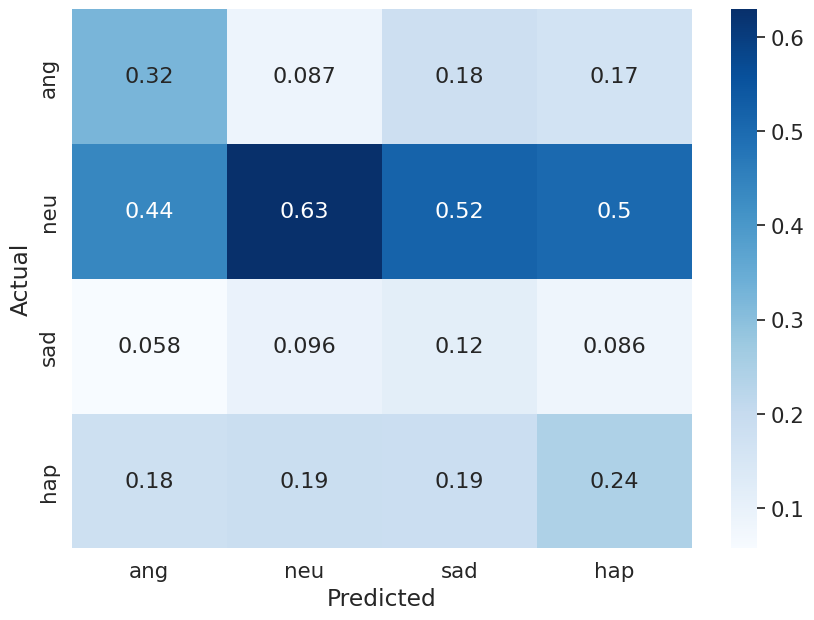

In [22]:
labels = dataset_config.target_labels
a = cm
a = a / reduce(a, 'y yh -> 1 yh', 'sum')
df_cm = pd.DataFrame(a, columns=labels, index = labels)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4) #for label size
sns.heatmap(
    df_cm, cmap="Blues", 
    annot=True,
    annot_kws={"size": 16})# font size

<Axes: xlabel='Predicted', ylabel='Actual'>

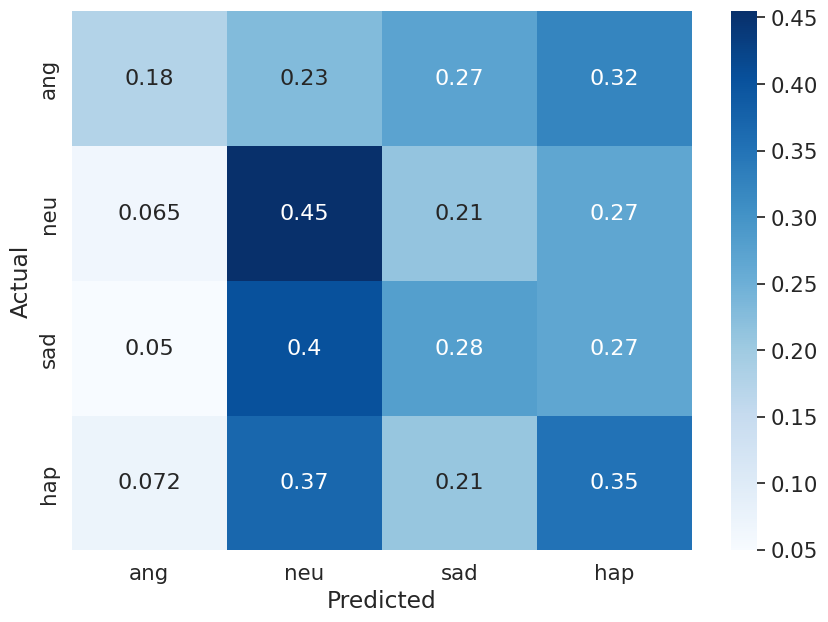

In [24]:
labels = dataset_config.target_labels
a = cm
a = a / reduce(a, 'y yh -> y 1', 'sum')
df_cm = pd.DataFrame(a, columns=labels, index = labels)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4) #for label size
sns.heatmap(
    df_cm, cmap="Blues", 
    annot=True,
    annot_kws={"size": 16})# font size

<Axes: xlabel='Predicted', ylabel='Actual'>

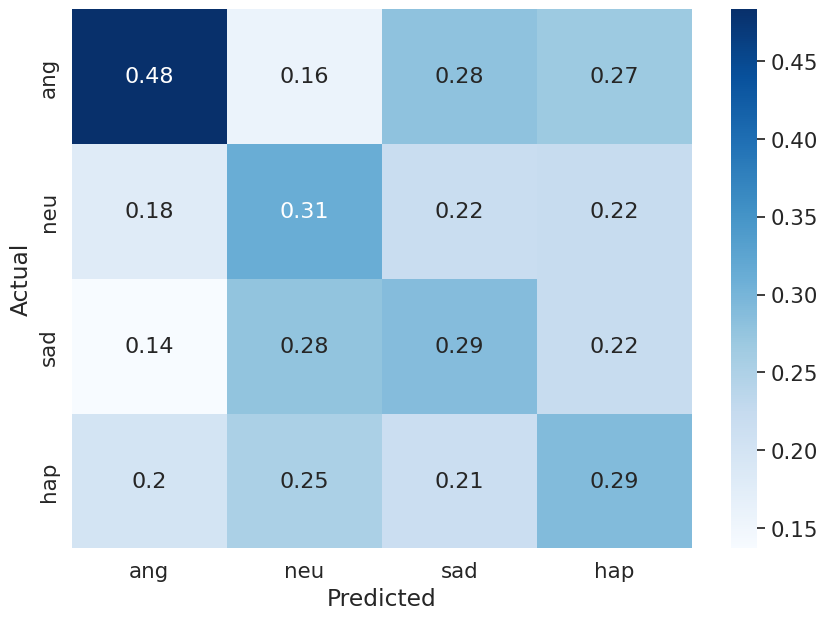

In [23]:
a = cm
a = a / reduce(a, 'y yh -> y 1', 'sum')
a = a / reduce(a, 'y yh -> 1 yh', 'sum')
df_cm = pd.DataFrame(a, columns=labels, index = labels)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4) #for label size
sns.heatmap(
    df_cm, cmap="Blues", 
    annot=True,
    annot_kws={"size": 16})# font size

In [25]:
dt = []
for i, ld in enumerate(trainer.train_losses_detail):
    d = {'loss': trainer.train_losses[i]}
    for j, k in enumerate(ld._fields):
        d[k] = ld[j]
    dt.append(d)
loss_df = pd.DataFrame(dt)
trained_epoch = trainer.current_epoch
n = len(trainer.train_losses)
trained_steps = n - (n % trained_epoch)
train_losses = reduce(np.array(
    trainer.train_losses[:trained_steps]), '(n k) -> n', 'mean', n=trained_epoch)

Text(0.5, 1.0, 'Test accuracy per 10 epochs')

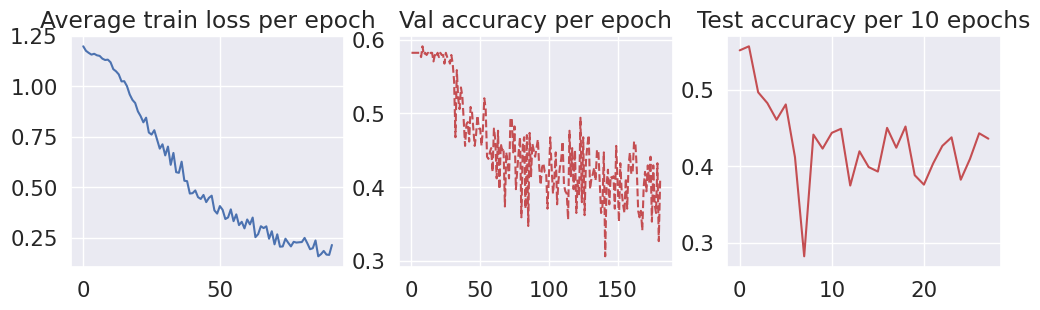

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(12,3))
axes[0].plot(train_losses, color="b")
axes[0].set_title("Average train loss per epoch")
axes[1].plot(trainer.val_accuracy, color="r", linestyle="dashed")
axes[1].set_title("Val accuracy per epoch")
axes[2].plot(trainer.test_accuracy, color="r")
axes[2].set_title("Test accuracy per 10 epochs")

Text(0.5, 1.0, 'Test accuracy per 10 epochs')

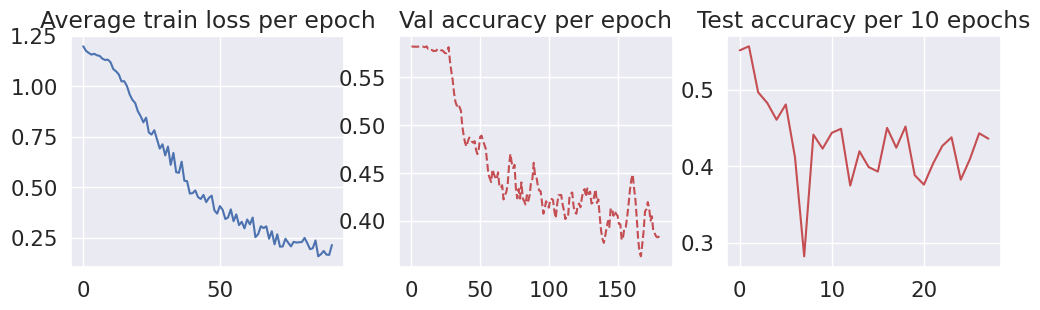

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(12,3))
axes[0].plot(train_losses, color="b")
axes[0].set_title("Average train loss per epoch")
axes[1].plot(savgol_filter(trainer.val_accuracy, 10, 2), color="r", linestyle="dashed")
axes[1].set_title("Val accuracy per epoch")
axes[2].plot(trainer.test_accuracy, color="r")
axes[2].set_title("Test accuracy per 10 epochs")

In [28]:
train_log = {
    'train_loss': torch.tensor(train_losses),
    'val_acc': torch.tensor(trainer.val_accuracy),
    'test_acc': torch.tensor(trainer.test_accuracy),
    'test_confusion_matrix': cm,
    'test_metrics': me,
    'test_metrics_detail': med,
    'best_model_path': log_dir + "model.epoch=76.step=193724.pt"
}
torch.save(train_log, log_dir+"train_metrics.pt")
loss_df.to_csv(log_dir+"train_losses.csv")

In [29]:
log_dir = f'../{experiment_prefix}_models/{dataset_name}/run1/'
trainer.log_dir = log_dir

In [30]:
iconnet_config = ocf.load(iconnet_config_path)
iconnet_config.fe.n_channel = [456]
iconnet_config.fe.window_k = [2]
iconnet_config.cls = {'n_block': 1, 'n_hidden_dim': [512,], 'norm_type': 'LayerNorm'}
print(iconnet_config)

{'name': 'M19', 'description': 'FirConv with learnable windows', 'fe': {'n_block': 1, 'n_channel': [456], 'kernel_size': [511], 'stride': [2], 'window_k': [2], 'pooling': 'mean', 'filter_type': 'sinc', 'learnable_bands': False, 'learnable_windows': True, 'shared_window': False, 'window_func': 'hamming', 'mel_resolution': 3, 'conv_mode': 'conv', 'norm_type': 'LocalResponseNorm'}, 'cls': {'n_block': 1, 'n_hidden_dim': [512], 'norm_type': 'LayerNorm'}}


In [31]:
codebook_pretrained_path = f'../scb7_models/iemocap/codebook.epoch=76.pt'

model = SCB(
    in_channels=in_channels,
    out_channels=out_channels,
    num_embeddings=num_embeddings, 
    embedding_dim=embedding_dim, 
    num_tokens=num_tokens,
    num_classes=num_classes, 
    cls_dim=embedding_dim,
    sample_rate=16000,
    commitment_cost=commitment_cost,
    distance_type='euclidean',
    codebook_pretrained_path=codebook_pretrained_path,
    freeze_codebook=True,
    loss_type='signal_loss',
    iconnet_config=iconnet_config,
)

In [33]:
trainer.setup(model=model, lr=learning_rate)

In [34]:
trainer.fit(n_epoch=50, self_supervised=False, train_task='embedding', test_n_epoch=10)

  1%|▋                                                                             | 0.47632390025215354/50 [15:16<1311:44:39, 95353.97s/it]

Epoch: 1	Loss: 0.611 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.611]	Val_acc: 198/340 (58.24%)

Saved new best val model: ../scb16_models/meld/run1/model.epoch=1.step=1275.loss=0.611.val_acc=0.582.pt


  1%|▉                                                                                  | 0.592322779490025/50 [18:29<22:12:00, 1617.56s/it]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x705953c31070>>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
  1%|▉                                                                                  | 0.592322779490025/50 [18:30<25:43:14, 1874.09s/it]


KeyboardInterrupt: 

In [35]:
trainer.fit(n_epoch=50, self_supervised=False, train_task='embedding', test_n_epoch=1)

  1%|▌                                                                            | 0.33339870562854323/50 [14:26<1809:47:50, 131180.12s/it]

Epoch: 2	Loss: 0.567 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.567]	Val_acc: 198/340 (58.24%)



  1%|█                                                                             | 0.6666012943714613/50 [28:57<1806:10:01, 131801.21s/it]

Epoch: 2	Loss: 1.293 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.293]	Val_acc: 197/340 (57.94%)



  2%|█▋                                                                                | 1.0000000000000904/50 [37:42<21:38:47, 1590.35s/it]

Correct: 915/1700 (0.5382)
Saved new best test model: ../scb16_models/meld/run1/model.epoch=2.step=4135.test_acc=0.5382.pt
{'acc_unweighted': tensor(0.2547, device='cuda:0'),
 'acc_weighted': tensor(0.5382, device='cuda:0'),
 'f1s_unweighted': tensor(0.2032, device='cuda:0'),
 'f1s_weighted': tensor(0.4077, device='cuda:0'),
 'rocauc': tensor(0.5730, device='cuda:0'),
 'uar': tensor(0.2547, device='cuda:0'),
 'wap': tensor(0.3953, device='cuda:0')}
{'acc_detail': tensor([0.0156, 0.9541, 0.0000, 0.0493], device='cuda:0'),
 'f1s_detail': tensor([0.0294, 0.7015, 0.0000, 0.0819], device='cuda:0'),
 'precision_detail': tensor([0.2667, 0.5546, 0.0000, 0.2429], device='cuda:0'),
 'recall_detail': tensor([0.0156, 0.9541, 0.0000, 0.0493], device='cuda:0'),
 'rocauc_detail': tensor([0.6316, 0.5580, 0.5641, 0.5383], device='cuda:0')}
tensor([[  4, 236,   1,  16],
        [  8, 894,   1,  34],
        [  1, 157,   0,   3],
        [  2, 325,   1,  17]], device='cuda:0')


  2%|█▊                                                                                | 1.1190429495980774/50 [42:27<33:14:28, 2448.16s/it]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x705953c31070>>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x705953c31070>>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
  2%|█▊                                                                                | 1.1192390664837413/50 [42:28<30:54:53, 2276.83s/i

In [36]:
log_dir = f'../{experiment_prefix}_models/{dataset_name}/run2/'
trainer.log_dir = log_dir

In [37]:
codebook_pretrained_path = f'../scb7_models/ravdess/codebook.step=10000.pt'
model = SCB(
    in_channels=in_channels,
    out_channels=out_channels,
    num_embeddings=num_embeddings, 
    embedding_dim=embedding_dim, 
    num_tokens=num_tokens,
    num_classes=num_classes, 
    cls_dim=embedding_dim,
    sample_rate=16000,
    commitment_cost=commitment_cost,
    distance_type='euclidean',
    codebook_pretrained_path=codebook_pretrained_path,
    freeze_codebook=True,
    loss_type='signal_loss',
    iconnet_config=iconnet_config,
)

In [38]:
trainer.setup(model=model, lr=learning_rate)

In [39]:
trainer.fit(n_epoch=50, self_supervised=False, train_task='embedding', test_n_epoch=10)

  1%|▋                                                                             | 0.47632390025215354/50 [14:20<1266:45:16, 92083.55s/it]

Epoch: 1	Loss: 1.255 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.255]	Val_acc: 198/340 (58.24%)

Saved new best val model: ../scb16_models/meld/run2/model.epoch=1.step=1275.loss=1.255.val_acc=0.582.pt


  2%|█▌                                                                             | 0.9523676099747226/50 [28:42<1271:42:37, 93341.04s/it]

Epoch: 1	Loss: 0.971 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.971]	Val_acc: 198/340 (58.24%)



  3%|██▎                                                                               | 1.4286915102270215/50 [37:32<15:25:37, 1143.43s/it]

Correct: 937/1700 (0.5512)
Saved new best test model: ../scb16_models/meld/run2/model.epoch=1.step=2549.test_acc=0.5512.pt
{'acc_unweighted': tensor(0.2500, device='cuda:0'),
 'acc_weighted': tensor(0.5512, device='cuda:0'),
 'f1s_unweighted': tensor(0.1777, device='cuda:0'),
 'f1s_weighted': tensor(0.3917, device='cuda:0'),
 'rocauc': tensor(0.5493, device='cuda:0'),
 'uar': tensor(0.2500, device='cuda:0'),
 'wap': tensor(0.3038, device='cuda:0')}
{'acc_detail': tensor([0., 1., 0., 0.], device='cuda:0'),
 'f1s_detail': tensor([0.0000, 0.7107, 0.0000, 0.0000], device='cuda:0'),
 'precision_detail': tensor([0.0000, 0.5512, 0.0000, 0.0000], device='cuda:0'),
 'recall_detail': tensor([0., 1., 0., 0.], device='cuda:0'),
 'rocauc_detail': tensor([0.5948, 0.5431, 0.5037, 0.5556], device='cuda:0')}
tensor([[  0, 257,   0,   0],
        [  0, 937,   0,   0],
        [  0, 161,   0,   0],
        [  0, 345,   0,   0]], device='cuda:0')


  4%|███                                                                            | 1.9050154104793393/50 [52:06<1249:10:07, 93502.63s/it]

Epoch: 2	Loss: 0.636 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.636]	Val_acc: 197/340 (57.94%)



  5%|███▋                                                                         | 2.3810591202020968/50 [1:06:38<1237:58:26, 93591.05s/it]

Epoch: 2	Loss: 0.646 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.646]	Val_acc: 198/340 (58.24%)



  6%|████▍                                                                        | 2.8573830204544146/50 [1:21:16<1220:58:47, 93238.95s/it]

Epoch: 3	Loss: 0.382 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.382]	Val_acc: 200/340 (58.82%)

Saved new best val model: ../scb16_models/meld/run2/model.epoch=3.step=6373.loss=0.382.val_acc=0.588.pt


  7%|█████▏                                                                       | 3.3334267301771723/50 [1:36:45<1262:48:54, 97417.37s/it]

Epoch: 3	Loss: 0.974 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.974]	Val_acc: 198/340 (58.24%)



  8%|██████                                                                         | 3.80975063042949/50 [1:52:26<1245:19:31, 97058.83s/it]

Epoch: 4	Loss: 1.870 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.870]	Val_acc: 198/340 (58.24%)



  9%|██████▋                                                                       | 4.285794340152248/50 [2:07:56<1238:24:36, 97524.98s/it]

Epoch: 4	Loss: 1.790 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.790]	Val_acc: 179/340 (52.65%)



 10%|███████▍                                                                      | 4.762118240404566/50 [2:23:43<1226:52:58, 97634.51s/it]

Epoch: 5	Loss: 2.160 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=2.160]	Val_acc: 197/340 (57.94%)



 10%|████████▏                                                                     | 5.238161950127323/50 [2:39:16<1228:12:31, 98779.49s/it]

Epoch: 5	Loss: 1.250 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.250]	Val_acc: 196/340 (57.65%)



 11%|████████▉                                                                     | 5.714485850379641/50 [2:54:55<1216:14:42, 98869.40s/it]

Epoch: 6	Loss: 1.354 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.354]	Val_acc: 197/340 (57.94%)



 12%|█████████▋                                                                    | 6.190529560102399/50 [3:10:37<1197:15:41, 98383.78s/it]

Epoch: 6	Loss: 0.542 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.542]	Val_acc: 197/340 (57.94%)



 13%|██████████▍                                                                   | 6.666853460354717/50 [3:26:21<1194:09:47, 99207.84s/it]

Epoch: 7	Loss: 0.206 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.206]	Val_acc: 201/340 (59.12%)

Saved new best val model: ../scb16_models/meld/run2/model.epoch=7.step=16569.loss=0.206.val_acc=0.591.pt


 14%|███████████▏                                                                  | 7.142897170077474/50 [3:42:08<1180:11:56, 99136.81s/it]

Epoch: 7	Loss: 0.974 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.974]	Val_acc: 197/340 (57.94%)



 15%|███████████▉                                                                  | 7.619221070329792/50 [3:57:53<1156:48:45, 98264.48s/it]

Epoch: 8	Loss: 0.869 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.869]	Val_acc: 199/340 (58.53%)



 16%|████████████▋                                                                 | 8.095264780052549/50 [4:13:39<1162:19:18, 99854.08s/it]

Epoch: 8	Loss: 0.361 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.361]	Val_acc: 194/340 (57.06%)



 17%|█████████████▎                                                                | 8.571588680304867/50 [4:29:25<1128:44:18, 98083.86s/it]

Epoch: 9	Loss: 0.665 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.665]	Val_acc: 187/340 (55.00%)



 18%|██████████████                                                                | 9.047632390027625/50 [4:45:10<1127:24:25, 99106.99s/it]

Epoch: 9	Loss: 1.112 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.112]	Val_acc: 189/340 (55.59%)



 19%|██████████████▊                                                               | 9.523956290279942/50 [5:00:55<1109:34:20, 98687.03s/it]

Epoch: 10	Loss: 1.168 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.168]	Val_acc: 196/340 (57.65%)



 20%|███████████████▊                                                               | 10.0000000000027/50 [5:16:43<1094:21:22, 98492.07s/it]

Epoch: 10	Loss: 1.046 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.046]	Val_acc: 191/340 (56.18%)



 21%|████████████████▏                                                            | 10.476323900255018/50 [5:32:28<1082:40:10, 98614.57s/it]

Epoch: 11	Loss: 1.870 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.870]	Val_acc: 190/340 (55.88%)



 22%|████████████████▋                                                           | 10.952367609977776/50 [5:48:19<1087:31:31, 100264.51s/it]

Epoch: 11	Loss: 0.816 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.816]	Val_acc: 195/340 (57.35%)



 23%|██████████████████▎                                                             | 11.428691510230093/50 [5:57:32<12:29:07, 1165.31s/it]

Correct: 930/1700 (0.5471)
{'acc_unweighted': tensor(0.2931, device='cuda:0'),
 'acc_weighted': tensor(0.5471, device='cuda:0'),
 'f1s_unweighted': tensor(0.2654, device='cuda:0'),
 'f1s_weighted': tensor(0.4458, device='cuda:0'),
 'rocauc': tensor(0.6173, device='cuda:0'),
 'uar': tensor(0.2931, device='cuda:0'),
 'wap': tensor(0.4369, device='cuda:0')}
{'acc_detail': tensor([0.2023, 0.9178, 0.0000, 0.0522], device='cuda:0'),
 'f1s_detail': tensor([0.2708, 0.7018, 0.0000, 0.0891], device='cuda:0'),
 'precision_detail': tensor([0.4094, 0.5680, 0.0000, 0.3051], device='cuda:0'),
 'recall_detail': tensor([0.2023, 0.9178, 0.0000, 0.0522], device='cuda:0'),
 'rocauc_detail': tensor([0.6824, 0.5938, 0.6080, 0.5849], device='cuda:0')}
tensor([[ 52, 199,   0,   6],
        [ 44, 860,   0,  33],
        [  8, 151,   0,   2],
        [ 23, 304,   0,  18]], device='cuda:0')


 24%|██████████████████                                                          | 11.905015410482411/50 [6:13:18<1058:19:44, 100012.75s/it]

Epoch: 12	Loss: 0.697 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.697]	Val_acc: 190/340 (55.88%)



 25%|███████████████████                                                          | 12.381059120205169/50 [6:29:13<1035:16:17, 99071.83s/it]

Epoch: 12	Loss: 0.070 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.070]	Val_acc: 188/340 (55.29%)



 26%|███████████████████▊                                                         | 12.857383020457487/50 [6:45:09<1024:58:26, 99344.28s/it]

Epoch: 13	Loss: 0.695 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.695]	Val_acc: 158/340 (46.47%)



 27%|████████████████████▌                                                        | 13.333426730180244/50 [7:01:05<1012:17:23, 99388.72s/it]

Epoch: 13	Loss: 0.903 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.903]	Val_acc: 178/340 (52.35%)



 28%|████████████████████▉                                                       | 13.809750630432562/50 [7:17:03<1007:41:13, 100238.97s/it]

Epoch: 14	Loss: 0.601 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.601]	Val_acc: 178/340 (52.35%)



 29%|██████████████████████▌                                                        | 14.28579434015532/50 [7:32:59<986:59:25, 99488.86s/it]

Epoch: 14	Loss: 0.252 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.252]	Val_acc: 185/340 (54.41%)



 30%|██████████████████████▋                                                      | 14.762118240407638/50 [7:49:03<992:52:43, 101435.25s/it]

Epoch: 15	Loss: 0.759 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.759]	Val_acc: 188/340 (55.29%)



 30%|███████████████████████▍                                                     | 15.238161950130396/50 [8:04:57<972:29:14, 100712.59s/it]

Epoch: 15	Loss: 0.174 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.174]	Val_acc: 177/340 (52.06%)



 31%|████████████████████████▏                                                    | 15.714485850382713/50 [8:20:57<965:19:30, 101359.74s/it]

Epoch: 16	Loss: 1.660 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.660]	Val_acc: 164/340 (48.24%)



 32%|█████████████████████████▎                                                    | 16.190529560104263/50 [8:36:55<938:01:21, 99879.76s/it]

Epoch: 16	Loss: 0.280 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.280]	Val_acc: 189/340 (55.59%)



 33%|██████████████████████████                                                    | 16.66685346035356/50 [8:52:51<926:07:34, 100022.20s/it]

Epoch: 17	Loss: 0.231 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.231]	Val_acc: 179/340 (52.65%)



 34%|███████████████████████████▍                                                    | 17.1428971700733/50 [9:08:54<911:28:25, 99865.94s/it]

Epoch: 17	Loss: 0.081 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.081]	Val_acc: 187/340 (55.00%)



 35%|███████████████████████████▊                                                   | 17.6192210703226/50 [9:24:54<908:19:18, 100984.55s/it]

Epoch: 18	Loss: 0.820 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.820]	Val_acc: 118/340 (34.71%)



 36%|████████████████████████████▏                                                 | 18.09526478004234/50 [9:40:59<890:02:15, 100428.20s/it]

Epoch: 18	Loss: 0.426 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.426]	Val_acc: 175/340 (51.47%)



 37%|████████████████████████████▌                                                | 18.571588680291637/50 [9:57:04<882:58:06, 101140.54s/it]

Epoch: 19	Loss: 0.486 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.486]	Val_acc: 167/340 (49.12%)



 38%|████████████████████████████▉                                               | 19.047632390011376/50 [10:13:06<866:30:00, 100780.69s/it]

Epoch: 19	Loss: 0.501 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.501]	Val_acc: 132/340 (38.82%)



 39%|█████████████████████████████▋                                              | 19.523956290260674/50 [10:29:10<852:55:02, 100751.33s/it]

Epoch: 20	Loss: 1.283 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.283]	Val_acc: 175/340 (51.47%)



 40%|██████████████████████████████▍                                             | 19.999999999980414/50 [10:45:17<839:03:27, 100686.92s/it]

Epoch: 20	Loss: 0.406 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.406]	Val_acc: 144/340 (42.35%)



 41%|███████████████████████████████                                             | 20.476323900229712/50 [11:01:28<824:57:45, 100592.66s/it]

Epoch: 21	Loss: 0.829 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.829]	Val_acc: 176/340 (51.76%)



 42%|████████████████████████████████▎                                            | 20.95236760994945/50 [11:17:30<818:14:11, 101407.63s/it]

Epoch: 21	Loss: 0.443 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.443]	Val_acc: 141/340 (41.47%)



 43%|██████████████████████████████████▋                                              | 21.42869151019875/50 [11:27:07<9:33:22, 1204.10s/it]

Correct: 743/1700 (0.4371)
{'acc_unweighted': tensor(0.3135, device='cuda:0'),
 'acc_weighted': tensor(0.4371, device='cuda:0'),
 'f1s_unweighted': tensor(0.2975, device='cuda:0'),
 'f1s_weighted': tensor(0.4304, device='cuda:0'),
 'rocauc': tensor(0.5949, device='cuda:0'),
 'uar': tensor(0.3135, device='cuda:0'),
 'wap': tensor(0.4331, device='cuda:0')}
{'acc_detail': tensor([0.2646, 0.5656, 0.0062, 0.4174], device='cuda:0'),
 'f1s_detail': tensor([0.2715, 0.5860, 0.0102, 0.3225], device='cuda:0'),
 'precision_detail': tensor([0.2787, 0.6078, 0.0278, 0.2628], device='cuda:0'),
 'recall_detail': tensor([0.2646, 0.5656, 0.0062, 0.4174], device='cuda:0'),
 'rocauc_detail': tensor([0.6391, 0.5842, 0.5736, 0.5826], device='cuda:0')}
tensor([[ 68,  97,   6,  86],
        [114, 530,  24, 269],
        [ 16,  95,   1,  49],
        [ 46, 150,   5, 144]], device='cuda:0')


 44%|█████████████████████████████████▎                                          | 21.905015410448048/50 [11:43:15<790:38:04, 101309.34s/it]

Epoch: 22	Loss: 0.284 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.284]	Val_acc: 152/340 (44.71%)



 45%|██████████████████████████████████                                          | 22.381059120167787/50 [11:59:18<775:39:52, 101104.25s/it]

Epoch: 22	Loss: 1.514 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.514]	Val_acc: 150/340 (44.12%)



 46%|██████████████████████████████████▋                                         | 22.857383020417085/50 [12:15:26<770:28:48, 102190.89s/it]

Epoch: 23	Loss: 0.022 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.022]	Val_acc: 179/340 (52.65%)



 47%|███████████████████████████████████▍                                        | 23.333426730136825/50 [12:31:36<746:04:11, 100719.79s/it]

Epoch: 23	Loss: 0.585 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.585]	Val_acc: 160/340 (47.06%)



 48%|████████████████████████████████████▏                                       | 23.809750630386123/50 [12:47:50<742:59:26, 102128.32s/it]

Epoch: 24	Loss: 1.308 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.308]	Val_acc: 113/340 (33.24%)



 49%|████████████████████████████████████▉                                       | 24.285794340105863/50 [13:04:03<735:24:06, 102956.57s/it]

Epoch: 24	Loss: 3.375 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=3.375]	Val_acc: 157/340 (46.18%)



 50%|██████████████████████████████████████▏                                      | 24.76211824035516/50 [13:20:16<712:51:18, 101683.60s/it]

Epoch: 25	Loss: 1.383 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.383]	Val_acc: 153/340 (45.00%)



 50%|███████████████████████████████████████▎                                      | 25.2381619500749/50 [13:36:27<703:03:43, 102214.68s/it]

Epoch: 25	Loss: 1.080 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.080]	Val_acc: 165/340 (48.53%)



 51%|████████████████████████████████████████                                      | 25.7144858503242/50 [13:52:41<689:24:54, 102196.51s/it]

Epoch: 26	Loss: 0.088 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.088]	Val_acc: 110/340 (32.35%)



 52%|███████████████████████████████████████▊                                    | 26.190529560043938/50 [14:08:56<672:00:12, 101607.14s/it]

Epoch: 26	Loss: 0.081 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.081]	Val_acc: 128/340 (37.65%)



 53%|████████████████████████████████████████▌                                   | 26.666853460293236/50 [14:25:16<668:02:08, 103069.17s/it]

Epoch: 27	Loss: 0.061 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.061]	Val_acc: 139/340 (40.88%)



 54%|█████████████████████████████████████████▎                                  | 27.142897170012976/50 [14:41:30<644:36:11, 101525.20s/it]

Epoch: 27	Loss: 0.113 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.113]	Val_acc: 156/340 (45.88%)



 55%|█████████████████████████████████████████▉                                  | 27.619221070262274/50 [14:57:56<644:24:33, 103654.74s/it]

Epoch: 28	Loss: 0.832 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.832]	Val_acc: 115/340 (33.82%)



 56%|██████████████████████████████████████████▋                                 | 28.095264779982013/50 [15:14:09<623:21:18, 102447.18s/it]

Epoch: 28	Loss: 0.013 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.013]	Val_acc: 180/340 (52.94%)



 57%|████████████████████████████████████████████                                 | 28.57158868023131/50 [15:30:29<620:17:59, 104211.16s/it]

Epoch: 29	Loss: 1.039 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.039]	Val_acc: 175/340 (51.47%)



 58%|████████████████████████████████████████████▋                                | 29.04763238995105/50 [15:46:51<582:53:03, 100150.21s/it]

Epoch: 29	Loss: 1.260 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.260]	Val_acc: 131/340 (38.53%)



 59%|█████████████████████████████████████████████▍                               | 29.52395629020035/50 [16:03:13<596:44:51, 104917.33s/it]

Epoch: 30	Loss: 2.827 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=2.827]	Val_acc: 145/340 (42.65%)



 60%|██████████████████████████████████████████████▏                              | 29.99999999992009/50 [16:19:35<567:42:31, 102187.57s/it]

Epoch: 30	Loss: 0.164 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.164]	Val_acc: 151/340 (44.41%)



 61%|██████████████████████████████████████████████▎                             | 30.476323900169387/50 [16:36:01<560:10:52, 103292.65s/it]

Epoch: 31	Loss: 0.277 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.277]	Val_acc: 119/340 (35.00%)



 62%|███████████████████████████████████████████████                             | 30.952367609889126/50 [16:52:26<550:57:23, 104130.73s/it]

Epoch: 31	Loss: 2.049 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=2.049]	Val_acc: 140/340 (41.18%)



 63%|██████████████████████████████████████████████████▎                             | 31.428691510138425/50 [17:02:23<6:26:31, 1248.79s/it]

Correct: 732/1700 (0.4306)
{'acc_unweighted': tensor(0.2981, device='cuda:0'),
 'acc_weighted': tensor(0.4306, device='cuda:0'),
 'f1s_unweighted': tensor(0.2882, device='cuda:0'),
 'f1s_weighted': tensor(0.4208, device='cuda:0'),
 'rocauc': tensor(0.5673, device='cuda:0'),
 'uar': tensor(0.2981, device='cuda:0'),
 'wap': tensor(0.4205, device='cuda:0')}
{'acc_detail': tensor([0.2957, 0.5934, 0.0248, 0.2783], device='cuda:0'),
 'f1s_detail': tensor([0.2667, 0.5893, 0.0423, 0.2546], device='cuda:0'),
 'precision_detail': tensor([0.2428, 0.5853, 0.1429, 0.2347], device='cuda:0'),
 'recall_detail': tensor([0.2957, 0.5934, 0.0248, 0.2783], device='cuda:0'),
 'rocauc_detail': tensor([0.5916, 0.5579, 0.5788, 0.5409], device='cuda:0')}
tensor([[ 76, 112,   4,  65],
        [153, 556,  15, 213],
        [ 20, 102,   4,  35],
        [ 64, 180,   5,  96]], device='cuda:0')


 64%|████████████████████████████████████████████████▍                           | 31.905015410387723/50 [17:18:37<520:34:50, 103569.63s/it]

Epoch: 32	Loss: 1.188 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.188]	Val_acc: 160/340 (47.06%)



 65%|█████████████████████████████████████████████████▏                          | 32.381059120107466/50 [17:35:08<504:51:08, 103154.22s/it]

Epoch: 32	Loss: 1.750 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.750]	Val_acc: 164/340 (48.24%)



 66%|█████████████████████████████████████████████████▉                          | 32.857383020356764/50 [17:51:39<494:44:32, 103897.33s/it]

Epoch: 33	Loss: 0.408 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.408]	Val_acc: 161/340 (47.35%)



 67%|████████████████████████████████████████████████████                          | 33.3334267300765/50 [18:08:01<478:07:46, 103276.56s/it]

Epoch: 33	Loss: 0.955 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.955]	Val_acc: 125/340 (36.76%)



 68%|████████████████████████████████████████████████████▋                         | 33.8097506303258/50 [18:24:28<467:18:13, 103907.83s/it]

Epoch: 34	Loss: 0.091 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.091]	Val_acc: 145/340 (42.65%)



 69%|████████████████████████████████████████████████████▊                        | 34.28579434004554/50 [18:40:57<450:26:28, 103192.52s/it]

Epoch: 34	Loss: 0.035 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.035]	Val_acc: 160/340 (47.06%)



 70%|█████████████████████████████████████████████████████▌                       | 34.76211824029484/50 [18:57:33<439:26:23, 103819.12s/it]

Epoch: 35	Loss: 0.036 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.036]	Val_acc: 121/340 (35.59%)



 70%|██████████████████████████████████████████████████████▎                      | 35.23816195001458/50 [19:14:03<426:39:12, 104048.85s/it]

Epoch: 35	Loss: 0.807 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.807]	Val_acc: 176/340 (51.76%)



 71%|███████████████████████████████████████████████████████                      | 35.71448585026388/50 [19:30:38<413:44:38, 104264.97s/it]

Epoch: 36	Loss: 2.084 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=2.084]	Val_acc: 127/340 (37.35%)



 72%|███████████████████████████████████████████████████████▋                     | 36.19052955998362/50 [19:47:08<399:23:17, 104116.78s/it]

Epoch: 36	Loss: 0.937 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.937]	Val_acc: 153/340 (45.00%)



 73%|███████████████████████████████████████████████████████▋                    | 36.666853460232915/50 [20:03:44<386:38:19, 104393.93s/it]

Epoch: 37	Loss: 0.080 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.080]	Val_acc: 165/340 (48.53%)



 74%|████████████████████████████████████████████████████████▍                   | 37.142897169952654/50 [20:20:20<371:27:52, 104010.38s/it]

Epoch: 37	Loss: 0.366 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.366]	Val_acc: 142/340 (41.76%)



 75%|█████████████████████████████████████████████████████████▉                   | 37.61922107020195/50 [20:37:00<365:47:13, 106361.10s/it]

Epoch: 38	Loss: 3.148 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=3.148]	Val_acc: 163/340 (47.94%)



 76%|██████████████████████████████████████████████████████████▋                  | 38.09526477992169/50 [20:53:34<344:48:48, 104271.80s/it]

Epoch: 38	Loss: 0.717 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.717]	Val_acc: 135/340 (39.71%)



 77%|███████████████████████████████████████████████████████████▍                 | 38.57158868017099/50 [21:10:17<334:41:55, 105431.57s/it]

Epoch: 39	Loss: 0.004 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.004]	Val_acc: 146/340 (42.94%)



 78%|████████████████████████████████████████████████████████████▏                | 39.04763238989073/50 [21:26:50<319:54:16, 105151.40s/it]

Epoch: 39	Loss: 0.108 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.108]	Val_acc: 122/340 (35.88%)



 79%|████████████████████████████████████████████████████████████▊                | 39.52395629014003/50 [21:43:35<307:32:42, 105685.16s/it]

Epoch: 40	Loss: 0.047 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.047]	Val_acc: 114/340 (33.53%)



 80%|█████████████████████████████████████████████████████████████▌               | 39.99999999985977/50 [22:00:10<290:37:25, 104624.54s/it]

Epoch: 40	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 133/340 (39.12%)



 81%|█████████████████████████████████████████████████████████████▌              | 40.476323900109065/50 [22:16:51<281:43:36, 106494.27s/it]

Epoch: 41	Loss: 0.014 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.014]	Val_acc: 118/340 (34.71%)



 82%|██████████████████████████████████████████████████████████████▏             | 40.952367609828805/50 [22:33:38<267:27:31, 106420.29s/it]

Epoch: 41	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 171/340 (50.29%)



 83%|███████████████████████████████████████████████████████████████████▉              | 41.4286915100781/50 [22:43:56<3:09:53, 1329.27s/it]

Correct: 861/1700 (0.5065)
{'acc_unweighted': tensor(0.2681, device='cuda:0'),
 'acc_weighted': tensor(0.5065, device='cuda:0'),
 'f1s_unweighted': tensor(0.2445, device='cuda:0'),
 'f1s_weighted': tensor(0.4206, device='cuda:0'),
 'rocauc': tensor(0.5434, device='cuda:0'),
 'uar': tensor(0.2681, device='cuda:0'),
 'wap': tensor(0.4151, device='cuda:0')}
{'acc_detail': tensor([0.1362, 0.8613, 0.0373, 0.0377], device='cuda:0'),
 'f1s_detail': tensor([0.1847, 0.6799, 0.0471, 0.0663], device='cuda:0'),
 'precision_detail': tensor([0.2869, 0.5616, 0.0638, 0.2766], device='cuda:0'),
 'recall_detail': tensor([0.1362, 0.8613, 0.0373, 0.0377], device='cuda:0'),
 'rocauc_detail': tensor([0.5861, 0.5474, 0.5083, 0.5319], device='cuda:0')}
tensor([[ 35, 197,  18,   7],
        [ 50, 807,  56,  24],
        [  7, 145,   6,   3],
        [ 30, 288,  14,  13]], device='cuda:0')


 84%|█████████████████████████████████████████████████████████████████▎            | 41.9050154103274/50 [23:00:31<240:09:14, 106801.31s/it]

Epoch: 42	Loss: 0.149 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.149]	Val_acc: 133/340 (39.12%)



 85%|█████████████████████████████████████████████████████████████████▎           | 42.38105912004714/50 [23:17:11<223:43:20, 105710.33s/it]

Epoch: 42	Loss: 0.695 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.695]	Val_acc: 126/340 (37.06%)



 86%|██████████████████████████████████████████████████████████████████           | 42.85738302029644/50 [23:33:57<209:27:23, 105569.65s/it]

Epoch: 43	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 143/340 (42.06%)



 87%|██████████████████████████████████████████████████████████████████▋          | 43.33342673001618/50 [23:50:42<195:47:00, 105724.52s/it]

Epoch: 43	Loss: 0.344 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.344]	Val_acc: 120/340 (35.29%)



 88%|██████████████████████████████████████████████████████████████████▌         | 43.809750630265476/50 [24:07:23<182:20:58, 106047.10s/it]

Epoch: 44	Loss: 0.116 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.116]	Val_acc: 120/340 (35.29%)



 89%|███████████████████████████████████████████████████████████████████▎        | 44.285794339985216/50 [24:24:13<167:54:56, 105788.44s/it]

Epoch: 44	Loss: 0.567 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.567]	Val_acc: 152/340 (44.71%)



 90%|████████████████████████████████████████████████████████████████████        | 44.762118240234514/50 [24:41:06<154:54:59, 106474.21s/it]

Epoch: 45	Loss: 0.321 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.321]	Val_acc: 141/340 (41.47%)



 90%|████████████████████████████████████████████████████████████████████▊       | 45.238161949954254/50 [24:57:51<140:28:41, 106203.11s/it]

Epoch: 45	Loss: 0.034 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.034]	Val_acc: 137/340 (40.29%)



 91%|██████████████████████████████████████████████████████████████████████▍      | 45.71448585020355/50 [25:14:42<127:03:51, 106739.05s/it]

Epoch: 46	Loss: 0.829 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.829]	Val_acc: 96/340 (28.24%)



 92%|███████████████████████████████████████████████████████████████████████▏     | 46.19052955992329/50 [25:31:30<112:02:27, 105880.13s/it]

Epoch: 46	Loss: 0.051 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.051]	Val_acc: 155/340 (45.59%)



 93%|███████████████████████████████████████████████████████████████████████▊     | 46.66685346017259/50 [25:48:30<100:32:39, 108593.90s/it]

Epoch: 47	Loss: 0.004 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.004]	Val_acc: 143/340 (42.06%)



 94%|█████████████████████████████████████████████████████████████████████████▌    | 47.14289716989233/50 [26:05:17<84:07:42, 106003.30s/it]

Epoch: 47	Loss: 0.772 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.772]	Val_acc: 119/340 (35.00%)



 95%|██████████████████████████████████████████████████████████████████████████▎   | 47.61922107014163/50 [26:22:14<71:10:57, 107635.81s/it]

Epoch: 48	Loss: 0.332 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.332]	Val_acc: 116/340 (34.12%)



 96%|███████████████████████████████████████████████████████████████████████████   | 48.09526477986137/50 [26:39:03<55:55:32, 105700.85s/it]

Epoch: 48	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 143/340 (42.06%)



 97%|██████████████████████████████████████████████████████████████████████████▊  | 48.571588680110665/50 [26:55:56<42:30:44, 107143.02s/it]

Epoch: 49	Loss: 1.813 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.813]	Val_acc: 96/340 (28.24%)



 98%|███████████████████████████████████████████████████████████████████████████▌ | 49.047632389830405/50 [27:12:54<28:33:11, 107932.20s/it]

Epoch: 49	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 162/340 (47.65%)



 99%|██████████████████████████████████████████████████████████████████████████████▏| 49.5239562900797/50 [27:29:49<14:13:26, 107567.79s/it]

Epoch: 50	Loss: 0.003 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.003]	Val_acc: 139/340 (40.88%)



100%|████████████████████████████████████████████████████████████████████████████████▉| 49.99999999979944/50 [27:46:46<00:00, 108120.13s/it]

Epoch: 50	Loss: 0.002 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.002]	Val_acc: 98/340 (28.82%)



100%|██████████████████████████████████████████████████████████████████████████████████▉| 49.99999999979944/50 [27:46:46<00:00, 2000.12s/it]


In [40]:
trainer.fit(n_epoch=50, self_supervised=False, train_task='embedding', test_n_epoch=1)

  1%|▌                                                                            | 0.33339870562854323/50 [16:59<2116:27:10, 153407.53s/it]

Epoch: 51	Loss: 0.039 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.039]	Val_acc: 136/340 (40.00%)



  1%|█                                                                             | 0.6666012943714613/50 [33:57<2103:10:31, 153474.76s/it]

Epoch: 51	Loss: 0.127 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.127]	Val_acc: 128/340 (37.65%)



  2%|█▋                                                                                | 1.0000000000000904/50 [44:19<25:56:57, 1906.49s/it]

Correct: 654/1700 (0.3847)
{'acc_unweighted': tensor(0.2801, device='cuda:0'),
 'acc_weighted': tensor(0.3847, device='cuda:0'),
 'f1s_unweighted': tensor(0.2792, device='cuda:0'),
 'f1s_weighted': tensor(0.3970, device='cuda:0'),
 'rocauc': tensor(0.5523, device='cuda:0'),
 'uar': tensor(0.2801, device='cuda:0'),
 'wap': tensor(0.4121, device='cuda:0')}
{'acc_detail': tensor([0.2490, 0.5197, 0.0994, 0.2522], device='cuda:0'),
 'f1s_detail': tensor([0.2384, 0.5509, 0.0844, 0.2430], device='cuda:0'),
 'precision_detail': tensor([0.2286, 0.5860, 0.0734, 0.2345], device='cuda:0'),
 'recall_detail': tensor([0.2490, 0.5197, 0.0994, 0.2522], device='cuda:0'),
 'rocauc_detail': tensor([0.5702, 0.5591, 0.5436, 0.5364], device='cuda:0')}
tensor([[ 64, 108,  33,  52],
        [132, 487, 124, 194],
        [ 22,  85,  16,  38],
        [ 62, 151,  45,  87]], device='cuda:0')


  3%|██                                                                          | 1.3333987056287195/50 [1:01:12<2094:15:41, 154918.18s/it]

Epoch: 52	Loss: 0.055 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.055]	Val_acc: 177/340 (52.06%)



  3%|██▌                                                                         | 1.6666012943716848/50 [1:18:15<2057:51:23, 153274.63s/it]

Epoch: 52	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 110/340 (32.35%)



  4%|███▏                                                                             | 2.000000000000314/50 [1:28:56<25:29:38, 1912.05s/it]

Correct: 566/1700 (0.3329)
{'acc_unweighted': tensor(0.2950, device='cuda:0'),
 'acc_weighted': tensor(0.3329, device='cuda:0'),
 'f1s_unweighted': tensor(0.2742, device='cuda:0'),
 'f1s_weighted': tensor(0.3500, device='cuda:0'),
 'rocauc': tensor(0.5559, device='cuda:0'),
 'uar': tensor(0.2950, device='cuda:0'),
 'wap': tensor(0.4166, device='cuda:0')}
{'acc_detail': tensor([0.3074, 0.3469, 0.1056, 0.4203], device='cuda:0'),
 'f1s_detail': tensor([0.2561, 0.4377, 0.1093, 0.2938], device='cuda:0'),
 'precision_detail': tensor([0.2194, 0.5931, 0.1133, 0.2259], device='cuda:0'),
 'recall_detail': tensor([0.3074, 0.3469, 0.1056, 0.4203], device='cuda:0'),
 'rocauc_detail': tensor([0.5641, 0.5558, 0.5656, 0.5380], device='cuda:0')}
tensor([[ 79,  68,  23,  87],
        [179, 325,  86, 347],
        [ 25,  56,  17,  63],
        [ 77,  99,  24, 145]], device='cuda:0')


  5%|███▌                                                                        | 2.3333987056285657/50 [1:45:59<2050:41:30, 154877.64s/it]

Epoch: 53	Loss: 0.001 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.001]	Val_acc: 113/340 (33.24%)



  5%|████                                                                        | 2.6666012943711537/50 [2:03:04<2057:05:00, 156454.01s/it]

Epoch: 53	Loss: 0.039 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.039]	Val_acc: 108/340 (31.76%)



  6%|████▊                                                                           | 2.9999999999994054/50 [2:13:45<25:00:16, 1915.23s/it]

Correct: 594/1700 (0.3494)
{'acc_unweighted': tensor(0.2832, device='cuda:0'),
 'acc_weighted': tensor(0.3494, device='cuda:0'),
 'f1s_unweighted': tensor(0.2709, device='cuda:0'),
 'f1s_weighted': tensor(0.3631, device='cuda:0'),
 'rocauc': tensor(0.5535, device='cuda:0'),
 'uar': tensor(0.2832, device='cuda:0'),
 'wap': tensor(0.4089, device='cuda:0')}
{'acc_detail': tensor([0.2023, 0.4023, 0.0932, 0.4348], device='cuda:0'),
 'f1s_detail': tensor([0.2222, 0.4739, 0.0955, 0.2921], device='cuda:0'),
 'precision_detail': tensor([0.2464, 0.5765, 0.0980, 0.2199], device='cuda:0'),
 'recall_detail': tensor([0.2023, 0.4023, 0.0932, 0.4348], device='cuda:0'),
 'rocauc_detail': tensor([0.5927, 0.5463, 0.5511, 0.5238], device='cuda:0')}
tensor([[ 52,  79,  24, 102],
        [101, 377,  91, 368],
        [ 13,  71,  15,  62],
        [ 45, 127,  23, 150]], device='cuda:0')


  7%|█████▏                                                                       | 3.333398705627657/50 [2:30:39<2014:30:52, 155405.62s/it]

Epoch: 54	Loss: 0.479 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.479]	Val_acc: 157/340 (46.18%)



  7%|█████▋                                                                       | 3.666601294370245/50 [2:47:44<1979:00:46, 153764.83s/it]

Epoch: 54	Loss: 0.066 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.066]	Val_acc: 152/340 (44.71%)



  8%|██████▍                                                                         | 3.9999999999984968/50 [2:58:29<24:51:47, 1945.82s/it]

Correct: 756/1700 (0.4447)
{'acc_unweighted': tensor(0.2929, device='cuda:0'),
 'acc_weighted': tensor(0.4447, device='cuda:0'),
 'f1s_unweighted': tensor(0.2927, device='cuda:0'),
 'f1s_weighted': tensor(0.4303, device='cuda:0'),
 'rocauc': tensor(0.5553, device='cuda:0'),
 'uar': tensor(0.2929, device='cuda:0'),
 'wap': tensor(0.4346, device='cuda:0')}
{'acc_detail': tensor([0.1167, 0.6521, 0.1304, 0.2725], device='cuda:0'),
 'f1s_detail': tensor([0.1734, 0.6156, 0.1170, 0.2648], device='cuda:0'),
 'precision_detail': tensor([0.3371, 0.5830, 0.1061, 0.2575], device='cuda:0'),
 'recall_detail': tensor([0.1167, 0.6521, 0.1304, 0.2725], device='cuda:0'),
 'rocauc_detail': tensor([0.5777, 0.5475, 0.5550, 0.5411], device='cuda:0')}
tensor([[ 30, 133,  37,  57],
        [ 41, 611, 104, 181],
        [  5, 102,  21,  33],
        [ 13, 202,  36,  94]], device='cuda:0')


  9%|██████▋                                                                      | 4.333398705626749/50 [3:15:42<1968:48:20, 155205.33s/it]

Epoch: 55	Loss: 1.242 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.242]	Val_acc: 134/340 (39.41%)



  9%|███████▏                                                                     | 4.666601294369337/50 [3:32:48<1940:43:28, 154116.15s/it]

Epoch: 55	Loss: 0.033 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.033]	Val_acc: 137/340 (40.29%)



 10%|████████                                                                         | 4.999999999997589/50 [3:43:36<24:17:09, 1942.88s/it]

Correct: 691/1700 (0.4065)
{'acc_unweighted': tensor(0.2984, device='cuda:0'),
 'acc_weighted': tensor(0.4065, device='cuda:0'),
 'f1s_unweighted': tensor(0.2749, device='cuda:0'),
 'f1s_weighted': tensor(0.3979, device='cuda:0'),
 'rocauc': tensor(0.5601, device='cuda:0'),
 'uar': tensor(0.2984, device='cuda:0'),
 'wap': tensor(0.4143, device='cuda:0')}
{'acc_detail': tensor([0.4397, 0.5678, 0.0994, 0.0870], device='cuda:0'),
 'f1s_detail': tensor([0.2843, 0.5786, 0.1115, 0.1253], device='cuda:0'),
 'precision_detail': tensor([0.2100, 0.5898, 0.1270, 0.2239], device='cuda:0'),
 'recall_detail': tensor([0.4397, 0.5678, 0.0994, 0.0870], device='cuda:0'),
 'rocauc_detail': tensor([0.6033, 0.5637, 0.5609, 0.5126], device='cuda:0')}
tensor([[113, 105,  15,  24],
        [266, 532,  74,  65],
        [ 41,  89,  16,  15],
        [118, 176,  21,  30]], device='cuda:0')


 11%|████████▎                                                                     | 5.33339870562584/50 [4:00:41<1931:02:08, 155635.93s/it]

Epoch: 56	Loss: 0.151 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.151]	Val_acc: 161/340 (47.35%)



 11%|████████▋                                                                    | 5.666601294368428/50 [4:17:54<1921:42:49, 156048.71s/it]

Epoch: 56	Loss: 0.006 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.006]	Val_acc: 139/340 (40.88%)



 12%|█████████▊                                                                        | 5.99999999999668/50 [4:28:44<24:01:04, 1965.10s/it]

Correct: 709/1700 (0.4171)
{'acc_unweighted': tensor(0.2969, device='cuda:0'),
 'acc_weighted': tensor(0.4171, device='cuda:0'),
 'f1s_unweighted': tensor(0.2944, device='cuda:0'),
 'f1s_weighted': tensor(0.4187, device='cuda:0'),
 'rocauc': tensor(0.5555, device='cuda:0'),
 'uar': tensor(0.2969, device='cuda:0'),
 'wap': tensor(0.4246, device='cuda:0')}
{'acc_detail': tensor([0.1984, 0.5582, 0.0745, 0.3565], device='cuda:0'),
 'f1s_detail': tensor([0.2227, 0.5735, 0.0784, 0.3030], device='cuda:0'),
 'precision_detail': tensor([0.2537, 0.5896, 0.0828, 0.2634], device='cuda:0'),
 'recall_detail': tensor([0.1984, 0.5582, 0.0745, 0.3565], device='cuda:0'),
 'rocauc_detail': tensor([0.5732, 0.5492, 0.5535, 0.5459], device='cuda:0')}
tensor([[ 51, 116,  23,  67],
        [ 93, 523,  85, 236],
        [ 20,  88,  12,  41],
        [ 37, 160,  25, 123]], device='cuda:0')


 13%|█████████▊                                                                   | 6.333398705624932/50 [4:45:56<1889:33:47, 155781.02s/it]

Epoch: 57	Loss: 0.111 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.111]	Val_acc: 147/340 (43.24%)



 13%|██████████▍                                                                   | 6.66660129436752/50 [5:03:10<1885:44:13, 156661.01s/it]

Epoch: 57	Loss: 0.264 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.264]	Val_acc: 148/340 (43.53%)



 14%|███████████▎                                                                     | 6.999999999995771/50 [5:14:03<23:22:45, 1957.34s/it]

Correct: 753/1700 (0.4429)
{'acc_unweighted': tensor(0.2926, device='cuda:0'),
 'acc_weighted': tensor(0.4429, device='cuda:0'),
 'f1s_unweighted': tensor(0.2929, device='cuda:0'),
 'f1s_weighted': tensor(0.4306, device='cuda:0'),
 'rocauc': tensor(0.5540, device='cuda:0'),
 'uar': tensor(0.2926, device='cuda:0'),
 'wap': tensor(0.4206, device='cuda:0')}
{'acc_detail': tensor([0.2257, 0.6446, 0.0683, 0.2319], device='cuda:0'),
 'f1s_detail': tensor([0.2402, 0.6141, 0.0791, 0.2381], device='cuda:0'),
 'precision_detail': tensor([0.2566, 0.5864, 0.0940, 0.2446], device='cuda:0'),
 'recall_detail': tensor([0.2257, 0.6446, 0.0683, 0.2319], device='cuda:0'),
 'rocauc_detail': tensor([0.5751, 0.5555, 0.5473, 0.5380], device='cuda:0')}
tensor([[ 58, 127,  23,  49],
        [104, 604,  62, 167],
        [ 15, 104,  11,  31],
        [ 49, 195,  21,  80]], device='cuda:0')


 15%|███████████▎                                                                 | 7.333398705624023/50 [5:31:25<1885:19:14, 159074.17s/it]

Epoch: 58	Loss: 0.068 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.068]	Val_acc: 142/340 (41.76%)



 15%|███████████▊                                                                 | 7.666601294366611/50 [5:48:36<1832:00:52, 155793.14s/it]

Epoch: 58	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 160/340 (47.06%)



 16%|████████████▉                                                                    | 7.999999999994863/50 [5:59:33<22:56:47, 1966.84s/it]

Correct: 790/1700 (0.4647)
{'acc_unweighted': tensor(0.2854, device='cuda:0'),
 'acc_weighted': tensor(0.4647, device='cuda:0'),
 'f1s_unweighted': tensor(0.2789, device='cuda:0'),
 'f1s_weighted': tensor(0.4286, device='cuda:0'),
 'rocauc': tensor(0.5633, device='cuda:0'),
 'uar': tensor(0.2854, device='cuda:0'),
 'wap': tensor(0.4203, device='cuda:0')}
{'acc_detail': tensor([0.1984, 0.7353, 0.1180, 0.0899], device='cuda:0'),
 'f1s_detail': tensor([0.2308, 0.6476, 0.1053, 0.1322], device='cuda:0'),
 'precision_detail': tensor([0.2757, 0.5785, 0.0950, 0.2500], device='cuda:0'),
 'recall_detail': tensor([0.1984, 0.7353, 0.1180, 0.0899], device='cuda:0'),
 'rocauc_detail': tensor([0.5882, 0.5559, 0.5677, 0.5414], device='cuda:0')}
tensor([[ 51, 156,  31,  19],
        [ 82, 689, 106,  60],
        [ 15, 113,  19,  14],
        [ 37, 233,  44,  31]], device='cuda:0')


 17%|████████████▊                                                                | 8.333398705624624/50 [6:16:51<1818:34:21, 157124.93s/it]

Epoch: 59	Loss: 0.001 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.001]	Val_acc: 160/340 (47.06%)



 17%|█████████████▎                                                               | 8.666601294368721/50 [6:34:07<1794:01:13, 156253.15s/it]

Epoch: 59	Loss: 0.965 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.965]	Val_acc: 149/340 (43.82%)



 18%|██████████████▌                                                                  | 8.999999999998483/50 [6:45:04<22:45:35, 1998.42s/it]

Correct: 776/1700 (0.4565)
{'acc_unweighted': tensor(0.2927, device='cuda:0'),
 'acc_weighted': tensor(0.4565, device='cuda:0'),
 'f1s_unweighted': tensor(0.2934, device='cuda:0'),
 'f1s_weighted': tensor(0.4362, device='cuda:0'),
 'rocauc': tensor(0.5510, device='cuda:0'),
 'uar': tensor(0.2927, device='cuda:0'),
 'wap': tensor(0.4221, device='cuda:0')}
{'acc_detail': tensor([0.1712, 0.6809, 0.0870, 0.2319], device='cuda:0'),
 'f1s_detail': tensor([0.1956, 0.6298, 0.1033, 0.2450], device='cuda:0'),
 'precision_detail': tensor([0.2280, 0.5859, 0.1273, 0.2597], device='cuda:0'),
 'recall_detail': tensor([0.1712, 0.6809, 0.0870, 0.2319], device='cuda:0'),
 'rocauc_detail': tensor([0.5579, 0.5528, 0.5663, 0.5270], device='cuda:0')}
tensor([[ 44, 141,  21,  51],
        [ 95, 638,  54, 150],
        [ 13, 107,  14,  27],
        [ 41, 203,  21,  80]], device='cuda:0')


 19%|██████████████▎                                                              | 9.333398705628245/50 [7:02:29<1794:52:05, 158890.23s/it]

Epoch: 60	Loss: 0.045 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.045]	Val_acc: 124/340 (36.47%)



 19%|██████████████▉                                                              | 9.666601294372342/50 [7:19:39<1746:40:31, 155901.35s/it]

Epoch: 60	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 121/340 (35.59%)



 20%|████████████████                                                                | 10.000000000002103/50 [7:30:37<22:00:51, 1981.29s/it]

Correct: 671/1700 (0.3947)
{'acc_unweighted': tensor(0.2820, device='cuda:0'),
 'acc_weighted': tensor(0.3947, device='cuda:0'),
 'f1s_unweighted': tensor(0.2768, device='cuda:0'),
 'f1s_weighted': tensor(0.3988, device='cuda:0'),
 'rocauc': tensor(0.5619, device='cuda:0'),
 'uar': tensor(0.2820, device='cuda:0'),
 'wap': tensor(0.4159, device='cuda:0')}
{'acc_detail': tensor([0.1518, 0.5219, 0.0745, 0.3797], device='cuda:0'),
 'f1s_detail': tensor([0.1884, 0.5525, 0.0789, 0.2873], device='cuda:0'),
 'precision_detail': tensor([0.2484, 0.5870, 0.0839, 0.2310], device='cuda:0'),
 'recall_detail': tensor([0.1518, 0.5219, 0.0745, 0.3797], device='cuda:0'),
 'rocauc_detail': tensor([0.5864, 0.5643, 0.5531, 0.5439], device='cuda:0')}
tensor([[ 39, 105,  25,  88],
        [ 71, 489,  82, 295],
        [ 12,  84,  12,  53],
        [ 35, 155,  24, 131]], device='cuda:0')


 21%|███████████████▋                                                            | 10.333398705631865/50 [7:47:52<1734:13:17, 157391.80s/it]

Epoch: 61	Loss: 0.907 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.907]	Val_acc: 115/340 (33.82%)



 21%|████████████████▏                                                           | 10.666601294375962/50 [8:05:07<1711:25:01, 156637.91s/it]

Epoch: 61	Loss: 0.011 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.011]	Val_acc: 130/340 (38.24%)



 22%|█████████████████▌                                                              | 11.000000000005723/50 [8:16:08<21:51:59, 2018.45s/it]

Correct: 693/1700 (0.4076)
{'acc_unweighted': tensor(0.2937, device='cuda:0'),
 'acc_weighted': tensor(0.4076, device='cuda:0'),
 'f1s_unweighted': tensor(0.2915, device='cuda:0'),
 'f1s_weighted': tensor(0.4132, device='cuda:0'),
 'rocauc': tensor(0.5647, device='cuda:0'),
 'uar': tensor(0.2937, device='cuda:0'),
 'wap': tensor(0.4217, device='cuda:0')}
{'acc_detail': tensor([0.2218, 0.5731, 0.1739, 0.2058], device='cuda:0'),
 'f1s_detail': tensor([0.2214, 0.5815, 0.1333, 0.2298], device='cuda:0'),
 'precision_detail': tensor([0.2209, 0.5901, 0.1081, 0.2601], device='cuda:0'),
 'recall_detail': tensor([0.2218, 0.5731, 0.1739, 0.2058], device='cuda:0'),
 'rocauc_detail': tensor([0.5813, 0.5494, 0.5902, 0.5379], device='cuda:0')}
tensor([[ 57, 115,  43,  42],
        [123, 537, 145, 132],
        [ 23,  82,  28,  28],
        [ 55, 176,  43,  71]], device='cuda:0')


 23%|█████████████████▏                                                          | 11.333398705635485/50 [8:33:22<1705:03:06, 158746.47s/it]

Epoch: 62	Loss: 0.974 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.974]	Val_acc: 144/340 (42.35%)



 23%|█████████████████▋                                                          | 11.666601294379582/50 [8:50:47<1695:18:22, 159211.10s/it]

Epoch: 62	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 150/340 (44.12%)



 24%|███████████████████▏                                                            | 12.000000000009344/50 [9:01:50<20:52:45, 1978.04s/it]

Correct: 747/1700 (0.4394)
{'acc_unweighted': tensor(0.3042, device='cuda:0'),
 'acc_weighted': tensor(0.4394, device='cuda:0'),
 'f1s_unweighted': tensor(0.3056, device='cuda:0'),
 'f1s_weighted': tensor(0.4335, device='cuda:0'),
 'rocauc': tensor(0.5691, device='cuda:0'),
 'uar': tensor(0.3042, device='cuda:0'),
 'wap': tensor(0.4283, device='cuda:0')}
{'acc_detail': tensor([0.2218, 0.6243, 0.1242, 0.2464], device='cuda:0'),
 'f1s_detail': tensor([0.2365, 0.6078, 0.1294, 0.2485], device='cuda:0'),
 'precision_detail': tensor([0.2533, 0.5921, 0.1351, 0.2507], device='cuda:0'),
 'recall_detail': tensor([0.2218, 0.6243, 0.1242, 0.2464], device='cuda:0'),
 'rocauc_detail': tensor([0.5894, 0.5611, 0.5828, 0.5430], device='cuda:0')}
tensor([[ 57, 122,  20,  58],
        [110, 585,  77, 165],
        [ 16,  94,  20,  31],
        [ 42, 187,  31,  85]], device='cuda:0')


 25%|██████████████████▋                                                         | 12.333398705639105/50 [9:19:22<1659:05:29, 158568.31s/it]

Epoch: 63	Loss: 0.112 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.112]	Val_acc: 138/340 (40.59%)



 25%|███████████████████▎                                                        | 12.666601294383202/50 [9:36:37<1631:34:02, 157329.43s/it]

Epoch: 63	Loss: 0.066 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.066]	Val_acc: 115/340 (33.82%)



 26%|████████████████████▊                                                           | 13.000000000012964/50 [9:47:42<20:57:46, 2039.64s/it]

Correct: 642/1700 (0.3776)
{'acc_unweighted': tensor(0.2930, device='cuda:0'),
 'acc_weighted': tensor(0.3776, device='cuda:0'),
 'f1s_unweighted': tensor(0.2823, device='cuda:0'),
 'f1s_weighted': tensor(0.3876, device='cuda:0'),
 'rocauc': tensor(0.5625, device='cuda:0'),
 'uar': tensor(0.2930, device='cuda:0'),
 'wap': tensor(0.4221, device='cuda:0')}
{'acc_detail': tensor([0.1479, 0.4621, 0.1242, 0.4377], device='cuda:0'),
 'f1s_detail': tensor([0.1797, 0.5204, 0.1250, 0.3041], device='cuda:0'),
 'precision_detail': tensor([0.2289, 0.5956, 0.1258, 0.2330], device='cuda:0'),
 'recall_detail': tensor([0.1479, 0.4621, 0.1242, 0.4377], device='cuda:0'),
 'rocauc_detail': tensor([0.5694, 0.5623, 0.5804, 0.5377], device='cuda:0')}
tensor([[ 38,  89,  23, 107],
        [ 84, 433,  92, 328],
        [ 10,  69,  20,  62],
        [ 34, 136,  24, 151]], device='cuda:0')


 27%|████████████████████                                                       | 13.333398705642725/50 [10:05:11<1622:28:56, 159298.55s/it]

Epoch: 64	Loss: 0.005 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.005]	Val_acc: 152/340 (44.71%)



 27%|████████████████████▍                                                      | 13.666601294386822/50 [10:22:34<1583:36:58, 156908.49s/it]

Epoch: 64	Loss: 0.094 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.094]	Val_acc: 119/340 (35.00%)



 28%|██████████████████████                                                         | 14.000000000016584/50 [10:33:33<20:04:25, 2007.38s/it]

Correct: 632/1700 (0.3718)
{'acc_unweighted': tensor(0.3038, device='cuda:0'),
 'acc_weighted': tensor(0.3718, device='cuda:0'),
 'f1s_unweighted': tensor(0.2830, device='cuda:0'),
 'f1s_weighted': tensor(0.3808, device='cuda:0'),
 'rocauc': tensor(0.5600, device='cuda:0'),
 'uar': tensor(0.3038, device='cuda:0'),
 'wap': tensor(0.4257, device='cuda:0')}
{'acc_detail': tensor([0.3268, 0.4216, 0.0435, 0.4232], device='cuda:0'),
 'f1s_detail': tensor([0.2692, 0.4947, 0.0670, 0.3010], device='cuda:0'),
 'precision_detail': tensor([0.2289, 0.5985, 0.1458, 0.2336], device='cuda:0'),
 'recall_detail': tensor([0.3268, 0.4216, 0.0435, 0.4232], device='cuda:0'),
 'rocauc_detail': tensor([0.5891, 0.5617, 0.5634, 0.5256], device='cuda:0')}
tensor([[ 84,  85,   4,  84],
        [176, 395,  27, 339],
        [ 28,  70,   7,  56],
        [ 79, 110,  10, 146]], device='cuda:0')


 29%|█████████████████████▌                                                     | 14.333398705646346/50 [10:50:59<1581:57:50, 159675.16s/it]

Epoch: 65	Loss: 0.039 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.039]	Val_acc: 151/340 (44.41%)



 29%|█████████████████████▉                                                     | 14.666601294390443/50 [11:08:27<1545:44:07, 157489.73s/it]

Epoch: 65	Loss: 0.044 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.044]	Val_acc: 148/340 (43.53%)



 30%|███████████████████████▋                                                       | 15.000000000020204/50 [11:19:38<19:27:16, 2001.03s/it]

Correct: 750/1700 (0.4412)
{'acc_unweighted': tensor(0.2865, device='cuda:0'),
 'acc_weighted': tensor(0.4412, device='cuda:0'),
 'f1s_unweighted': tensor(0.2843, device='cuda:0'),
 'f1s_weighted': tensor(0.4260, device='cuda:0'),
 'rocauc': tensor(0.5543, device='cuda:0'),
 'uar': tensor(0.2865, device='cuda:0'),
 'wap': tensor(0.4144, device='cuda:0')}
{'acc_detail': tensor([0.2451, 0.6510, 0.0497, 0.2000], device='cuda:0'),
 'f1s_detail': tensor([0.2414, 0.6146, 0.0586, 0.2226], device='cuda:0'),
 'precision_detail': tensor([0.2377, 0.5821, 0.0714, 0.2509], device='cuda:0'),
 'recall_detail': tensor([0.2451, 0.6510, 0.0497, 0.2000], device='cuda:0'),
 'rocauc_detail': tensor([0.5850, 0.5533, 0.5471, 0.5318], device='cuda:0')}
tensor([[ 63, 137,  15,  42],
        [128, 610,  63, 136],
        [ 22, 103,   8,  28],
        [ 52, 198,  26,  69]], device='cuda:0')


 31%|███████████████████████                                                    | 15.333398705649966/50 [11:37:09<1516:06:52, 157442.97s/it]

Epoch: 66	Loss: 4.377 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=4.377]	Val_acc: 179/340 (52.65%)



 31%|███████████████████████▍                                                   | 15.666601294394063/50 [11:54:32<1507:47:16, 158097.84s/it]

Epoch: 66	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 177/340 (52.06%)



 32%|█████████████████████████▎                                                     | 16.000000000023824/50 [12:05:44<19:19:50, 2046.77s/it]

Correct: 843/1700 (0.4959)
{'acc_unweighted': tensor(0.2897, device='cuda:0'),
 'acc_weighted': tensor(0.4959, device='cuda:0'),
 'f1s_unweighted': tensor(0.2807, device='cuda:0'),
 'f1s_weighted': tensor(0.4452, device='cuda:0'),
 'rocauc': tensor(0.5576, device='cuda:0'),
 'uar': tensor(0.2897, device='cuda:0'),
 'wap': tensor(0.4306, device='cuda:0')}
{'acc_detail': tensor([0.1362, 0.7748, 0.0186, 0.2290], device='cuda:0'),
 'f1s_detail': tensor([0.1804, 0.6615, 0.0339, 0.2469], device='cuda:0'),
 'precision_detail': tensor([0.2672, 0.5771, 0.1875, 0.2678], device='cuda:0'),
 'recall_detail': tensor([0.1362, 0.7748, 0.0186, 0.2290], device='cuda:0'),
 'rocauc_detail': tensor([0.5842, 0.5460, 0.5652, 0.5349], device='cuda:0')}
tensor([[ 35, 168,   3,  51],
        [ 67, 726,   9, 135],
        [  7, 121,   3,  30],
        [ 22, 243,   1,  79]], device='cuda:0')


 33%|████████████████████████▌                                                  | 16.333398705653586/50 [12:23:15<1483:49:37, 158666.98s/it]

Epoch: 67	Loss: 0.016 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.016]	Val_acc: 138/340 (40.59%)



 33%|████████████████████████▉                                                  | 16.666601294397683/50 [12:40:46<1458:59:32, 157570.88s/it]

Epoch: 67	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 159/340 (46.76%)



 34%|██████████████████████████▊                                                    | 17.000000000027445/50 [12:51:59<18:30:18, 2018.75s/it]

Correct: 791/1700 (0.4653)
{'acc_unweighted': tensor(0.2839, device='cuda:0'),
 'acc_weighted': tensor(0.4653, device='cuda:0'),
 'f1s_unweighted': tensor(0.2797, device='cuda:0'),
 'f1s_weighted': tensor(0.4290, device='cuda:0'),
 'rocauc': tensor(0.5505, device='cuda:0'),
 'uar': tensor(0.2839, device='cuda:0'),
 'wap': tensor(0.4096, device='cuda:0')}
{'acc_detail': tensor([0.2101, 0.7268, 0.0683, 0.1304], device='cuda:0'),
 'f1s_detail': tensor([0.2227, 0.6412, 0.0913, 0.1636], device='cuda:0'),
 'precision_detail': tensor([0.2368, 0.5737, 0.1375, 0.2195], device='cuda:0'),
 'recall_detail': tensor([0.2101, 0.7268, 0.0683, 0.1304], device='cuda:0'),
 'rocauc_detail': tensor([0.5765, 0.5462, 0.5562, 0.5230], device='cuda:0')}
tensor([[ 54, 151,  14,  38],
        [111, 681,  40, 105],
        [ 15, 118,  11,  17],
        [ 48, 237,  15,  45]], device='cuda:0')


 35%|██████████████████████████                                                 | 17.333398705657206/50 [13:09:39<1440:12:25, 158717.02s/it]

Epoch: 68	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 125/340 (36.76%)



 35%|██████████████████████████▍                                                | 17.666601294401303/50 [13:27:07<1428:03:34, 159000.12s/it]

Epoch: 68	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 138/340 (40.59%)



 36%|████████████████████████████▍                                                  | 18.000000000031065/50 [13:38:23<18:13:55, 2051.10s/it]

Correct: 704/1700 (0.4141)
{'acc_unweighted': tensor(0.2926, device='cuda:0'),
 'acc_weighted': tensor(0.4141, device='cuda:0'),
 'f1s_unweighted': tensor(0.2919, device='cuda:0'),
 'f1s_weighted': tensor(0.4171, device='cuda:0'),
 'rocauc': tensor(0.5634, device='cuda:0'),
 'uar': tensor(0.2926, device='cuda:0'),
 'wap': tensor(0.4208, device='cuda:0')}
{'acc_detail': tensor([0.2412, 0.5699, 0.0870, 0.2725], device='cuda:0'),
 'f1s_detail': tensor([0.2417, 0.5811, 0.0895, 0.2554], device='cuda:0'),
 'precision_detail': tensor([0.2422, 0.5927, 0.0921, 0.2404], device='cuda:0'),
 'recall_detail': tensor([0.2412, 0.5699, 0.0870, 0.2725], device='cuda:0'),
 'rocauc_detail': tensor([0.5922, 0.5623, 0.5642, 0.5349], device='cuda:0')}
tensor([[ 62, 114,  25,  56],
        [119, 534,  81, 203],
        [ 22,  87,  14,  38],
        [ 53, 166,  32,  94]], device='cuda:0')


 37%|███████████████████████████▌                                               | 18.333398705660827/50 [13:56:04<1422:57:40, 161768.57s/it]

Epoch: 69	Loss: 0.097 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.097]	Val_acc: 131/340 (38.53%)



 37%|███████████████████████████▉                                               | 18.666601294404924/50 [14:13:39<1392:47:03, 160021.68s/it]

Epoch: 69	Loss: 0.001 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.001]	Val_acc: 156/340 (45.88%)



 38%|██████████████████████████████                                                 | 19.000000000034685/50 [14:24:57<17:44:54, 2061.11s/it]

Correct: 773/1700 (0.4547)
{'acc_unweighted': tensor(0.2846, device='cuda:0'),
 'acc_weighted': tensor(0.4547, device='cuda:0'),
 'f1s_unweighted': tensor(0.2831, device='cuda:0'),
 'f1s_weighted': tensor(0.4299, device='cuda:0'),
 'rocauc': tensor(0.5524, device='cuda:0'),
 'uar': tensor(0.2846, device='cuda:0'),
 'wap': tensor(0.4176, device='cuda:0')}
{'acc_detail': tensor([0.1634, 0.7033, 0.1180, 0.1536], device='cuda:0'),
 'f1s_detail': tensor([0.1935, 0.6383, 0.1121, 0.1886], device='cuda:0'),
 'precision_detail': tensor([0.2373, 0.5842, 0.1067, 0.2442], device='cuda:0'),
 'recall_detail': tensor([0.1634, 0.7033, 0.1180, 0.1536], device='cuda:0'),
 'rocauc_detail': tensor([0.5824, 0.5505, 0.5442, 0.5323], device='cuda:0')}
tensor([[ 42, 146,  29,  40],
        [ 78, 659,  93, 107],
        [ 14, 111,  19,  17],
        [ 43, 212,  37,  53]], device='cuda:0')


 39%|█████████████████████████████                                              | 19.333398705664447/50 [14:42:36<1352:35:46, 158783.38s/it]

Epoch: 70	Loss: 0.036 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.036]	Val_acc: 152/340 (44.71%)



 39%|█████████████████████████████▍                                             | 19.666601294408544/50 [15:00:06<1367:46:12, 162328.41s/it]

Epoch: 70	Loss: 0.024 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.024]	Val_acc: 146/340 (42.94%)



 40%|███████████████████████████████▌                                               | 20.000000000038305/50 [15:11:26<16:56:49, 2033.64s/it]

Correct: 720/1700 (0.4235)
{'acc_unweighted': tensor(0.2938, device='cuda:0'),
 'acc_weighted': tensor(0.4235, device='cuda:0'),
 'f1s_unweighted': tensor(0.2939, device='cuda:0'),
 'f1s_weighted': tensor(0.4213, device='cuda:0'),
 'rocauc': tensor(0.5638, device='cuda:0'),
 'uar': tensor(0.2938, device='cuda:0'),
 'wap': tensor(0.4194, device='cuda:0')}
{'acc_detail': tensor([0.2412, 0.5923, 0.0807, 0.2609], device='cuda:0'),
 'f1s_detail': tensor([0.2490, 0.5889, 0.0872, 0.2503], device='cuda:0'),
 'precision_detail': tensor([0.2573, 0.5854, 0.0949, 0.2406], device='cuda:0'),
 'recall_detail': tensor([0.2412, 0.5923, 0.0807, 0.2609], device='cuda:0'),
 'rocauc_detail': tensor([0.5947, 0.5577, 0.5670, 0.5357], device='cuda:0')}
tensor([[ 62, 117,  24,  54],
        [111, 555,  76, 195],
        [ 20,  93,  13,  35],
        [ 48, 183,  24,  90]], device='cuda:0')


 41%|██████████████████████████████▌                                            | 20.333398705668067/50 [15:29:08<1317:55:27, 159928.25s/it]

Epoch: 71	Loss: 3.774 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=3.774]	Val_acc: 160/340 (47.06%)



 41%|██████████████████████████████▉                                            | 20.666601294412164/50 [15:46:41<1303:01:58, 159917.32s/it]

Epoch: 71	Loss: 0.007 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.007]	Val_acc: 136/340 (40.00%)



 42%|█████████████████████████████████▏                                             | 21.000000000041926/50 [15:58:02<16:35:55, 2060.53s/it]

Correct: 711/1700 (0.4182)
{'acc_unweighted': tensor(0.2908, device='cuda:0'),
 'acc_weighted': tensor(0.4182, device='cuda:0'),
 'f1s_unweighted': tensor(0.2900, device='cuda:0'),
 'f1s_weighted': tensor(0.4179, device='cuda:0'),
 'rocauc': tensor(0.5642, device='cuda:0'),
 'uar': tensor(0.2908, device='cuda:0'),
 'wap': tensor(0.4241, device='cuda:0')}
{'acc_detail': tensor([0.1634, 0.5763, 0.0932, 0.3304], device='cuda:0'),
 'f1s_detail': tensor([0.2029, 0.5832, 0.0929, 0.2811], device='cuda:0'),
 'precision_detail': tensor([0.2675, 0.5902, 0.0926, 0.2446], device='cuda:0'),
 'recall_detail': tensor([0.1634, 0.5763, 0.0932, 0.3304], device='cuda:0'),
 'rocauc_detail': tensor([0.5844, 0.5666, 0.5610, 0.5449], device='cuda:0')}
tensor([[ 42, 110,  25,  80],
        [ 69, 540,  91, 237],
        [ 13,  98,  15,  35],
        [ 33, 167,  31, 114]], device='cuda:0')


 43%|████████████████████████████████                                           | 21.333398705671687/50 [16:15:50<1281:41:12, 160956.39s/it]

Epoch: 72	Loss: 0.098 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.098]	Val_acc: 145/340 (42.65%)



 43%|████████████████████████████████▍                                          | 21.666601294415784/50 [16:33:27<1279:02:36, 162513.38s/it]

Epoch: 72	Loss: 0.002 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.002]	Val_acc: 134/340 (39.41%)



 44%|██████████████████████████████████▊                                            | 22.000000000045546/50 [16:44:51<16:13:17, 2085.63s/it]

Correct: 682/1700 (0.4012)
{'acc_unweighted': tensor(0.3053, device='cuda:0'),
 'acc_weighted': tensor(0.4012, device='cuda:0'),
 'f1s_unweighted': tensor(0.2906, device='cuda:0'),
 'f1s_weighted': tensor(0.4054, device='cuda:0'),
 'rocauc': tensor(0.5639, device='cuda:0'),
 'uar': tensor(0.3053, device='cuda:0'),
 'wap': tensor(0.4268, device='cuda:0')}
{'acc_detail': tensor([0.2840, 0.4941, 0.0373, 0.4058], device='cuda:0'),
 'f1s_detail': tensor([0.2544, 0.5418, 0.0556, 0.3108], device='cuda:0'),
 'precision_detail': tensor([0.2303, 0.5997, 0.1091, 0.2518], device='cuda:0'),
 'recall_detail': tensor([0.2840, 0.4941, 0.0373, 0.4058], device='cuda:0'),
 'rocauc_detail': tensor([0.5712, 0.5654, 0.5677, 0.5514], device='cuda:0')}
tensor([[ 73,  99,  11,  74],
        [155, 463,  28, 291],
        [ 25,  79,   6,  51],
        [ 64, 131,  10, 140]], device='cuda:0')


 45%|█████████████████████████████████▌                                         | 22.333398705675307/50 [17:02:34<1239:03:48, 161227.91s/it]

Epoch: 73	Loss: 0.020 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.020]	Val_acc: 116/340 (34.12%)



 45%|█████████████████████████████████▉                                         | 22.666601294419404/50 [17:20:19<1225:20:32, 161386.18s/it]

Epoch: 73	Loss: 0.013 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.013]	Val_acc: 133/340 (39.12%)



 46%|████████████████████████████████████▎                                          | 23.000000000049166/50 [17:31:48<15:48:06, 2106.92s/it]

Correct: 659/1700 (0.3876)
{'acc_unweighted': tensor(0.2977, device='cuda:0'),
 'acc_weighted': tensor(0.3876, device='cuda:0'),
 'f1s_unweighted': tensor(0.2784, device='cuda:0'),
 'f1s_weighted': tensor(0.3974, device='cuda:0'),
 'rocauc': tensor(0.5588, device='cuda:0'),
 'uar': tensor(0.2977, device='cuda:0'),
 'wap': tensor(0.4309, device='cuda:0')}
{'acc_detail': tensor([0.0895, 0.5368, 0.3354, 0.2290], device='cuda:0'),
 'f1s_detail': tensor([0.1322, 0.5658, 0.1742, 0.2416], device='cuda:0'),
 'precision_detail': tensor([0.2527, 0.5981, 0.1176, 0.2557], device='cuda:0'),
 'recall_detail': tensor([0.0895, 0.5368, 0.3354, 0.2290], device='cuda:0'),
 'rocauc_detail': tensor([0.5681, 0.5638, 0.5585, 0.5449], device='cuda:0')}
tensor([[ 23,  99,  68,  67],
        [ 44, 503, 249, 141],
        [  4,  81,  54,  22],
        [ 20, 158,  88,  79]], device='cuda:0')


 47%|███████████████████████████████████                                        | 23.333398705678928/50 [17:49:40<1192:48:12, 161028.88s/it]

Epoch: 74	Loss: 0.022 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.022]	Val_acc: 137/340 (40.29%)



 47%|███████████████████████████████████▍                                       | 23.666601294423025/50 [18:07:23<1187:02:24, 162278.49s/it]

Epoch: 74	Loss: 0.027 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.027]	Val_acc: 140/340 (41.18%)



 48%|█████████████████████████████████████▉                                         | 24.000000000052786/50 [18:19:03<15:20:12, 2123.54s/it]

Correct: 730/1700 (0.4294)
{'acc_unweighted': tensor(0.2996, device='cuda:0'),
 'acc_weighted': tensor(0.4294, device='cuda:0'),
 'f1s_unweighted': tensor(0.2967, device='cuda:0'),
 'f1s_weighted': tensor(0.4256, device='cuda:0'),
 'rocauc': tensor(0.5636, device='cuda:0'),
 'uar': tensor(0.2996, device='cuda:0'),
 'wap': tensor(0.4231, device='cuda:0')}
{'acc_detail': tensor([0.2646, 0.5934, 0.0621, 0.2783], device='cuda:0'),
 'f1s_detail': tensor([0.2519, 0.5918, 0.0766, 0.2667], device='cuda:0'),
 'precision_detail': tensor([0.2403, 0.5902, 0.1000, 0.2560], device='cuda:0'),
 'recall_detail': tensor([0.2646, 0.5934, 0.0621, 0.2783], device='cuda:0'),
 'rocauc_detail': tensor([0.5813, 0.5605, 0.5649, 0.5475], device='cuda:0')}
tensor([[ 68, 116,  15,  58],
        [137, 556,  54, 190],
        [ 22,  98,  10,  31],
        [ 56, 172,  21,  96]], device='cuda:0')


 49%|████████████████████████████████████▌                                      | 24.333398705682548/50 [18:36:14<1121:35:44, 157315.12s/it]

Epoch: 75	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 125/340 (36.76%)



 49%|████████████████████████████████████▉                                      | 24.666601294426645/50 [18:53:26<1129:42:10, 160536.30s/it]

Epoch: 75	Loss: 1.330 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.330]	Val_acc: 144/340 (42.35%)



 50%|███████████████████████████████████████▌                                       | 25.000000000056406/50 [19:05:02<14:22:31, 2070.07s/it]

Correct: 712/1700 (0.4188)
{'acc_unweighted': tensor(0.2865, device='cuda:0'),
 'acc_weighted': tensor(0.4188, device='cuda:0'),
 'f1s_unweighted': tensor(0.2809, device='cuda:0'),
 'f1s_weighted': tensor(0.4130, device='cuda:0'),
 'rocauc': tensor(0.5593, device='cuda:0'),
 'uar': tensor(0.2865, device='cuda:0'),
 'wap': tensor(0.4263, device='cuda:0')}
{'acc_detail': tensor([0.1051, 0.5795, 0.0932, 0.3681], device='cuda:0'),
 'f1s_detail': tensor([0.1547, 0.5839, 0.0962, 0.2890], device='cuda:0'),
 'precision_detail': tensor([0.2935, 0.5883, 0.0993, 0.2378], device='cuda:0'),
 'recall_detail': tensor([0.1051, 0.5795, 0.0932, 0.3681], device='cuda:0'),
 'rocauc_detail': tensor([0.5660, 0.5633, 0.5534, 0.5547], device='cuda:0')}
tensor([[ 27, 108,  28,  94],
        [ 43, 543,  86, 265],
        [  6,  92,  15,  48],
        [ 16, 180,  22, 127]], device='cuda:0')


 51%|██████████████████████████████████████                                     | 25.333398705686168/50 [19:22:48<1114:14:42, 162620.01s/it]

Epoch: 76	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 129/340 (37.94%)



 51%|██████████████████████████████████████▍                                    | 25.666601294430265/50 [19:40:38<1103:21:07, 163235.20s/it]

Epoch: 76	Loss: 0.005 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.005]	Val_acc: 123/340 (36.18%)



 52%|█████████████████████████████████████████                                      | 26.000000000060027/50 [19:52:18<13:57:25, 2093.55s/it]

Correct: 672/1700 (0.3953)
{'acc_unweighted': tensor(0.2900, device='cuda:0'),
 'acc_weighted': tensor(0.3953, device='cuda:0'),
 'f1s_unweighted': tensor(0.2781, device='cuda:0'),
 'f1s_weighted': tensor(0.3975, device='cuda:0'),
 'rocauc': tensor(0.5665, device='cuda:0'),
 'uar': tensor(0.2900, device='cuda:0'),
 'wap': tensor(0.4165, device='cuda:0')}
{'acc_detail': tensor([0.1946, 0.5016, 0.0435, 0.4203], device='cuda:0'),
 'f1s_detail': tensor([0.2000, 0.5424, 0.0631, 0.3069], device='cuda:0'),
 'precision_detail': tensor([0.2058, 0.5905, 0.1148, 0.2417], device='cuda:0'),
 'recall_detail': tensor([0.1946, 0.5016, 0.0435, 0.4203], device='cuda:0'),
 'rocauc_detail': tensor([0.5617, 0.5648, 0.5785, 0.5609], device='cuda:0')}
tensor([[ 50, 105,  10,  92],
        [127, 470,  35, 305],
        [ 18,  78,   7,  58],
        [ 48, 143,   9, 145]], device='cuda:0')


 53%|████████████████████████████████████████                                    | 26.33339870568979/50 [20:10:15<1058:54:38, 161074.20s/it]

Epoch: 77	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 135/340 (39.71%)



 53%|███████████████████████████████████████▉                                   | 26.666601294433885/50 [20:28:05<1059:25:32, 163453.77s/it]

Epoch: 77	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 164/340 (48.24%)



 54%|██████████████████████████████████████████▋                                    | 27.000000000063647/50 [20:39:48<13:24:13, 2097.97s/it]

Correct: 808/1700 (0.4753)
{'acc_unweighted': tensor(0.2892, device='cuda:0'),
 'acc_weighted': tensor(0.4753, device='cuda:0'),
 'f1s_unweighted': tensor(0.2888, device='cuda:0'),
 'f1s_weighted': tensor(0.4402, device='cuda:0'),
 'rocauc': tensor(0.5604, device='cuda:0'),
 'uar': tensor(0.2892, device='cuda:0'),
 'wap': tensor(0.4291, device='cuda:0')}
{'acc_detail': tensor([0.1751, 0.7417, 0.0807, 0.1594], device='cuda:0'),
 'f1s_detail': tensor([0.2133, 0.6486, 0.0839, 0.2095], device='cuda:0'),
 'precision_detail': tensor([0.2727, 0.5763, 0.0872, 0.3056], device='cuda:0'),
 'recall_detail': tensor([0.1751, 0.7417, 0.0807, 0.1594], device='cuda:0'),
 'rocauc_detail': tensor([0.5779, 0.5582, 0.5529, 0.5524], device='cuda:0')}
tensor([[ 45, 158,  26,  28],
        [ 78, 695,  80,  84],
        [ 11, 124,  13,  13],
        [ 31, 229,  30,  55]], device='cuda:0')


 55%|█████████████████████████████████████████▌                                  | 27.33339870569341/50 [20:57:52<1030:12:38, 163622.16s/it]

Epoch: 78	Loss: 0.005 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.005]	Val_acc: 144/340 (42.35%)



 55%|█████████████████████████████████████████▍                                 | 27.666601294437505/50 [21:15:46<1012:03:43, 163137.88s/it]

Epoch: 78	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 142/340 (41.76%)



 56%|████████████████████████████████████████████▏                                  | 28.000000000067267/50 [21:27:28<12:48:16, 2095.29s/it]

Correct: 716/1700 (0.4212)
{'acc_unweighted': tensor(0.2926, device='cuda:0'),
 'acc_weighted': tensor(0.4212, device='cuda:0'),
 'f1s_unweighted': tensor(0.2931, device='cuda:0'),
 'f1s_weighted': tensor(0.4213, device='cuda:0'),
 'rocauc': tensor(0.5689, device='cuda:0'),
 'uar': tensor(0.2926, device='cuda:0'),
 'wap': tensor(0.4217, device='cuda:0')}
{'acc_detail': tensor([0.2140, 0.5880, 0.0932, 0.2754], device='cuda:0'),
 'f1s_detail': tensor([0.2240, 0.5884, 0.0912, 0.2687], device='cuda:0'),
 'precision_detail': tensor([0.2350, 0.5887, 0.0893, 0.2624], device='cuda:0'),
 'recall_detail': tensor([0.2140, 0.5880, 0.0932, 0.2754], device='cuda:0'),
 'rocauc_detail': tensor([0.5804, 0.5629, 0.5767, 0.5557], device='cuda:0')}
tensor([[ 55, 117,  28,  57],
        [112, 551,  96, 178],
        [ 18,  96,  15,  32],
        [ 49, 172,  29,  95]], device='cuda:0')


 57%|███████████████████████████████████████████▋                                 | 28.33339870569703/50 [21:45:36<993:21:53, 165051.90s/it]

Epoch: 79	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 127/340 (37.35%)



 57%|███████████████████████████████████████████▌                                | 28.666601294441126/50 [22:03:29<972:06:05, 164041.61s/it]

Epoch: 79	Loss: 0.003 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.003]	Val_acc: 184/340 (54.12%)



 58%|█████████████████████████████████████████████▊                                 | 29.000000000070887/50 [22:15:09<12:12:05, 2091.68s/it]

Correct: 892/1700 (0.5247)
{'acc_unweighted': tensor(0.2825, device='cuda:0'),
 'acc_weighted': tensor(0.5247, device='cuda:0'),
 'f1s_unweighted': tensor(0.2636, device='cuda:0'),
 'f1s_weighted': tensor(0.4383, device='cuda:0'),
 'rocauc': tensor(0.5605, device='cuda:0'),
 'uar': tensor(0.2825, device='cuda:0'),
 'wap': tensor(0.4298, device='cuda:0')}
{'acc_detail': tensor([0.1401, 0.8826, 0.0435, 0.0638], device='cuda:0'),
 'f1s_detail': tensor([0.1930, 0.6929, 0.0648, 0.1038], device='cuda:0'),
 'precision_detail': tensor([0.3103, 0.5703, 0.1273, 0.2785], device='cuda:0'),
 'recall_detail': tensor([0.1401, 0.8826, 0.0435, 0.0638], device='cuda:0'),
 'rocauc_detail': tensor([0.5833, 0.5621, 0.5455, 0.5511], device='cuda:0')}
tensor([[ 36, 196,  10,  15],
        [ 46, 827,  25,  39],
        [  8, 143,   7,   3],
        [ 26, 284,  13,  22]], device='cuda:0')


 59%|█████████████████████████████████████████████▏                               | 29.33339870570065/50 [22:33:16<945:32:13, 164706.96s/it]

Epoch: 80	Loss: 0.663 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.663]	Val_acc: 143/340 (42.06%)



 59%|█████████████████████████████████████████████                               | 29.666601294444746/50 [22:51:13<922:59:20, 163413.91s/it]

Epoch: 80	Loss: 0.009 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.009]	Val_acc: 158/340 (46.47%)



 60%|███████████████████████████████████████████████▍                               | 30.000000000074508/50 [23:02:55<11:40:56, 2102.81s/it]

Correct: 799/1700 (0.4700)
{'acc_unweighted': tensor(0.3094, device='cuda:0'),
 'acc_weighted': tensor(0.4700, device='cuda:0'),
 'f1s_unweighted': tensor(0.3022, device='cuda:0'),
 'f1s_weighted': tensor(0.4477, device='cuda:0'),
 'rocauc': tensor(0.5674, device='cuda:0'),
 'uar': tensor(0.3094, device='cuda:0'),
 'wap': tensor(0.4349, device='cuda:0')}
{'acc_detail': tensor([0.2646, 0.6756, 0.0248, 0.2725], device='cuda:0'),
 'f1s_detail': tensor([0.2514, 0.6314, 0.0412, 0.2848], device='cuda:0'),
 'precision_detail': tensor([0.2394, 0.5927, 0.1212, 0.2984], device='cuda:0'),
 'recall_detail': tensor([0.2646, 0.6756, 0.0248, 0.2725], device='cuda:0'),
 'rocauc_detail': tensor([0.5750, 0.5677, 0.5749, 0.5519], device='cuda:0')}
tensor([[ 68, 134,   5,  50],
        [139, 633,  17, 148],
        [ 21, 113,   4,  23],
        [ 56, 188,   7,  94]], device='cuda:0')


 61%|██████████████████████████████████████████████▋                              | 30.33339870570427/50 [23:21:02<896:33:52, 164117.46s/it]

Epoch: 81	Loss: 0.166 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.166]	Val_acc: 146/340 (42.94%)



 61%|██████████████████████████████████████████████▌                             | 30.666601294448366/50 [23:38:53<885:03:40, 164803.95s/it]

Epoch: 81	Loss: 4.263 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=4.263]	Val_acc: 123/340 (36.18%)



 62%|████████████████████████████████████████████████▉                              | 31.000000000078128/50 [23:50:41<11:19:55, 2147.12s/it]

Correct: 629/1700 (0.3700)
{'acc_unweighted': tensor(0.2953, device='cuda:0'),
 'acc_weighted': tensor(0.3700, device='cuda:0'),
 'f1s_unweighted': tensor(0.2826, device='cuda:0'),
 'f1s_weighted': tensor(0.3844, device='cuda:0'),
 'rocauc': tensor(0.5744, device='cuda:0'),
 'uar': tensor(0.2953, device='cuda:0'),
 'wap': tensor(0.4332, device='cuda:0')}
{'acc_detail': tensor([0.1829, 0.4322, 0.0994, 0.4667], device='cuda:0'),
 'f1s_detail': tensor([0.2151, 0.5066, 0.0944, 0.3141], device='cuda:0'),
 'precision_detail': tensor([0.2611, 0.6118, 0.0899, 0.2368], device='cuda:0'),
 'recall_detail': tensor([0.1829, 0.4322, 0.0994, 0.4667], device='cuda:0'),
 'rocauc_detail': tensor([0.6026, 0.5738, 0.5696, 0.5516], device='cuda:0')}
tensor([[ 47,  67,  34, 109],
        [ 80, 405,  99, 353],
        [ 12,  76,  16,  57],
        [ 41, 114,  29, 161]], device='cuda:0')


 63%|████████████████████████████████████████████████▎                            | 31.33339870570789/50 [24:08:50<859:51:08, 165829.26s/it]

Epoch: 82	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 123/340 (36.18%)



 63%|████████████████████████████████████████████████▏                           | 31.666601294451986/50 [24:26:49<842:04:36, 165352.67s/it]

Epoch: 82	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 129/340 (37.94%)



 64%|███████████████████████████████████████████████████▏                            | 32.00000000008175/50 [24:38:44<10:36:01, 2120.11s/it]

Correct: 627/1700 (0.3688)
{'acc_unweighted': tensor(0.3262, device='cuda:0'),
 'acc_weighted': tensor(0.3688, device='cuda:0'),
 'f1s_unweighted': tensor(0.3076, device='cuda:0'),
 'f1s_weighted': tensor(0.3902, device='cuda:0'),
 'rocauc': tensor(0.5715, device='cuda:0'),
 'uar': tensor(0.3262, device='cuda:0'),
 'wap': tensor(0.4387, device='cuda:0')}
{'acc_detail': tensor([0.3813, 0.4152, 0.1925, 0.3159], device='cuda:0'),
 'f1s_detail': tensor([0.2908, 0.4933, 0.1505, 0.2958], device='cuda:0'),
 'precision_detail': tensor([0.2350, 0.6078, 0.1235, 0.2781], device='cuda:0'),
 'recall_detail': tensor([0.3813, 0.4152, 0.1925, 0.3159], device='cuda:0'),
 'rocauc_detail': tensor([0.5909, 0.5641, 0.5797, 0.5512], device='cuda:0')}
tensor([[ 98,  74,  33,  52],
        [213, 389, 138, 197],
        [ 33,  63,  31,  34],
        [ 73, 114,  49, 109]], device='cuda:0')


 65%|█████████████████████████████████████████████████▊                           | 32.33339870570547/50 [24:56:59<806:49:24, 164409.91s/it]

Epoch: 83	Loss: 0.009 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.009]	Val_acc: 157/340 (46.18%)



 65%|██████████████████████████████████████████████████▎                          | 32.66660129444353/50 [25:14:56<800:04:09, 166167.63s/it]

Epoch: 83	Loss: 0.028 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.028]	Val_acc: 161/340 (47.35%)



 66%|████████████████████████████████████████████████████▊                           | 33.00000000006725/50 [25:26:48<10:10:36, 2155.09s/it]

Correct: 794/1700 (0.4671)
{'acc_unweighted': tensor(0.3051, device='cuda:0'),
 'acc_weighted': tensor(0.4671, device='cuda:0'),
 'f1s_unweighted': tensor(0.3046, device='cuda:0'),
 'f1s_weighted': tensor(0.4465, device='cuda:0'),
 'rocauc': tensor(0.5718, device='cuda:0'),
 'uar': tensor(0.3051, device='cuda:0'),
 'wap': tensor(0.4319, device='cuda:0')}
{'acc_detail': tensor([0.2451, 0.6820, 0.0497, 0.2435], device='cuda:0'),
 'f1s_detail': tensor([0.2669, 0.6320, 0.0650, 0.2545], device='cuda:0'),
 'precision_detail': tensor([0.2930, 0.5889, 0.0941, 0.2667], device='cuda:0'),
 'recall_detail': tensor([0.2451, 0.6820, 0.0497, 0.2435], device='cuda:0'),
 'rocauc_detail': tensor([0.6110, 0.5652, 0.5744, 0.5367], device='cuda:0')}
tensor([[ 63, 127,  22,  45],
        [ 96, 639,  41, 161],
        [ 15, 113,   8,  25],
        [ 41, 206,  14,  84]], device='cuda:0')


 67%|██████████████████████████████████████████████████▋                         | 33.333398705690975/50 [25:45:03<759:11:52, 163987.41s/it]

Epoch: 84	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 143/340 (42.06%)



 67%|███████████████████████████████████████████████████▏                        | 33.666601294429036/50 [26:03:04<758:06:41, 167093.29s/it]

Epoch: 84	Loss: 0.005 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.005]	Val_acc: 162/340 (47.65%)



 68%|███████████████████████████████████████████████████████                          | 34.00000000005276/50 [26:14:59<9:38:12, 2168.26s/it]

Correct: 786/1700 (0.4624)
{'acc_unweighted': tensor(0.2957, device='cuda:0'),
 'acc_weighted': tensor(0.4624, device='cuda:0'),
 'f1s_unweighted': tensor(0.2964, device='cuda:0'),
 'f1s_weighted': tensor(0.4413, device='cuda:0'),
 'rocauc': tensor(0.5639, device='cuda:0'),
 'uar': tensor(0.2957, device='cuda:0'),
 'wap': tensor(0.4318, device='cuda:0')}
{'acc_detail': tensor([0.1829, 0.7022, 0.1180, 0.1797], device='cuda:0'),
 'f1s_detail': tensor([0.2156, 0.6426, 0.1098, 0.2175], device='cuda:0'),
 'precision_detail': tensor([0.2626, 0.5923, 0.1027, 0.2756], device='cuda:0'),
 'recall_detail': tensor([0.1829, 0.7022, 0.1180, 0.1797], device='cuda:0'),
 'rocauc_detail': tensor([0.5889, 0.5652, 0.5591, 0.5424], device='cuda:0')}
tensor([[ 47, 135,  35,  40],
        [ 78, 658,  99, 102],
        [ 10, 111,  19,  21],
        [ 44, 207,  32,  62]], device='cuda:0')


 69%|████████████████████████████████████████████████████▊                        | 34.33339870567648/50 [26:33:16<718:51:19, 165184.46s/it]

Epoch: 85	Loss: 0.428 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.428]	Val_acc: 115/340 (33.82%)



 69%|█████████████████████████████████████████████████████▍                       | 34.66660129441454/50 [26:51:21<705:41:44, 165684.37s/it]

Epoch: 85	Loss: 3.575 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=3.575]	Val_acc: 110/340 (32.35%)



 70%|████████████████████████████████████████████████████████▋                        | 35.00000000003826/50 [27:03:16<8:53:57, 2135.84s/it]

Correct: 577/1700 (0.3394)
{'acc_unweighted': tensor(0.3130, device='cuda:0'),
 'acc_weighted': tensor(0.3394, device='cuda:0'),
 'f1s_unweighted': tensor(0.2891, device='cuda:0'),
 'f1s_weighted': tensor(0.3558, device='cuda:0'),
 'rocauc': tensor(0.5573, device='cuda:0'),
 'uar': tensor(0.3130, device='cuda:0'),
 'wap': tensor(0.4347, device='cuda:0')}
{'acc_detail': tensor([0.2296, 0.3351, 0.1801, 0.5072], device='cuda:0'),
 'f1s_detail': tensor([0.2593, 0.4295, 0.1384, 0.3289], device='cuda:0'),
 'precision_detail': tensor([0.2980, 0.5981, 0.1124, 0.2434], device='cuda:0'),
 'recall_detail': tensor([0.2296, 0.3351, 0.1801, 0.5072], device='cuda:0'),
 'rocauc_detail': tensor([0.5701, 0.5554, 0.5567, 0.5473], device='cuda:0')}
tensor([[ 59,  65,  37,  96],
        [ 94, 314, 149, 380],
        [ 13,  51,  29,  68],
        [ 32,  95,  43, 175]], device='cuda:0')


 71%|█████████████████████████████████████████████████████▋                      | 35.333398705661985/50 [27:21:32<670:47:34, 164649.93s/it]

Epoch: 86	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 181/340 (53.24%)



 71%|██████████████████████████████████████████████████████▏                     | 35.666601294400046/50 [27:39:42<671:51:54, 168746.74s/it]

Epoch: 86	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 156/340 (45.88%)



 72%|██████████████████████████████████████████████████████████▎                      | 36.00000000002377/50 [27:51:44<8:21:09, 2147.79s/it]

Correct: 780/1700 (0.4588)
{'acc_unweighted': tensor(0.3118, device='cuda:0'),
 'acc_weighted': tensor(0.4588, device='cuda:0'),
 'f1s_unweighted': tensor(0.3104, device='cuda:0'),
 'f1s_weighted': tensor(0.4455, device='cuda:0'),
 'rocauc': tensor(0.5694, device='cuda:0'),
 'uar': tensor(0.3118, device='cuda:0'),
 'wap': tensor(0.4362, device='cuda:0')}
{'acc_detail': tensor([0.2529, 0.6457, 0.0559, 0.2928], device='cuda:0'),
 'f1s_detail': tensor([0.2664, 0.6192, 0.0766, 0.2794], device='cuda:0'),
 'precision_detail': tensor([0.2814, 0.5949, 0.1216, 0.2672], device='cuda:0'),
 'recall_detail': tensor([0.2529, 0.6457, 0.0559, 0.2928], device='cuda:0'),
 'rocauc_detail': tensor([0.5997, 0.5665, 0.5615, 0.5497], device='cuda:0')}
tensor([[ 65, 124,  14,  54],
        [103, 605,  40, 189],
        [ 17, 101,   9,  34],
        [ 46, 187,  11, 101]], device='cuda:0')


 73%|███████████████████████████████████████████████████████▉                     | 36.33339870564749/50 [28:10:03<627:26:50, 165279.62s/it]

Epoch: 87	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 156/340 (45.88%)



 73%|████████████████████████████████████████████████████████▍                    | 36.66660129438555/50 [28:28:13<618:44:34, 167059.78s/it]

Epoch: 87	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 155/340 (45.59%)



 74%|███████████████████████████████████████████████████████████▉                     | 37.00000000000927/50 [28:40:16<7:51:13, 2174.87s/it]

Correct: 762/1700 (0.4482)
{'acc_unweighted': tensor(0.3093, device='cuda:0'),
 'acc_weighted': tensor(0.4482, device='cuda:0'),
 'f1s_unweighted': tensor(0.3078, device='cuda:0'),
 'f1s_weighted': tensor(0.4382, device='cuda:0'),
 'rocauc': tensor(0.5685, device='cuda:0'),
 'uar': tensor(0.3093, device='cuda:0'),
 'wap': tensor(0.4303, device='cuda:0')}
{'acc_detail': tensor([0.2840, 0.6297, 0.0683, 0.2551], device='cuda:0'),
 'f1s_detail': tensor([0.2792, 0.6095, 0.0880, 0.2547], device='cuda:0'),
 'precision_detail': tensor([0.2744, 0.5906, 0.1236, 0.2543], device='cuda:0'),
 'recall_detail': tensor([0.2840, 0.6297, 0.0683, 0.2551], device='cuda:0'),
 'rocauc_detail': tensor([0.6015, 0.5630, 0.5744, 0.5352], device='cuda:0')}
tensor([[ 73, 120,  14,  50],
        [119, 590,  54, 174],
        [ 19,  97,  11,  34],
        [ 55, 192,  10,  88]], device='cuda:0')


 75%|████████████████████████████████████████████████████████▋                   | 37.333398705632995/50 [28:58:35<591:20:46, 168067.72s/it]

Epoch: 88	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 145/340 (42.65%)



 75%|█████████████████████████████████████████████████████████▎                  | 37.666601294371056/50 [29:16:50<575:32:09, 167993.43s/it]

Epoch: 88	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 168/340 (49.41%)



 76%|█████████████████████████████████████████████████████████████▌                   | 37.99999999999478/50 [29:28:56<7:16:26, 2182.18s/it]

Correct: 816/1700 (0.4800)
{'acc_unweighted': tensor(0.2749, device='cuda:0'),
 'acc_weighted': tensor(0.4800, device='cuda:0'),
 'f1s_unweighted': tensor(0.2691, device='cuda:0'),
 'f1s_weighted': tensor(0.4333, device='cuda:0'),
 'rocauc': tensor(0.5495, device='cuda:0'),
 'uar': tensor(0.2749, device='cuda:0'),
 'wap': tensor(0.4148, device='cuda:0')}
{'acc_detail': tensor([0.1206, 0.7748, 0.0621, 0.1420], device='cuda:0'),
 'f1s_detail': tensor([0.1649, 0.6633, 0.0707, 0.1775], device='cuda:0'),
 'precision_detail': tensor([0.2605, 0.5799, 0.0820, 0.2367], device='cuda:0'),
 'recall_detail': tensor([0.1206, 0.7748, 0.0621, 0.1420], device='cuda:0'),
 'rocauc_detail': tensor([0.5797, 0.5585, 0.5400, 0.5198], device='cuda:0')}
tensor([[ 31, 154,  30,  42],
        [ 59, 726,  58,  94],
        [  5, 124,  10,  22],
        [ 24, 248,  24,  49]], device='cuda:0')


 77%|███████████████████████████████████████████████████████████▊                  | 38.3333987056185/50 [29:47:26<550:23:19, 169835.16s/it]

Epoch: 89	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 129/340 (37.94%)



 77%|███████████████████████████████████████████████████████████▌                 | 38.66660129435656/50 [30:05:45<534:21:36, 169736.99s/it]

Epoch: 89	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 135/340 (39.71%)



 78%|███████████████████████████████████████████████████████████████▏                 | 38.99999999998028/50 [30:17:54<6:39:17, 2177.92s/it]

Correct: 700/1700 (0.4118)
{'acc_unweighted': tensor(0.3101, device='cuda:0'),
 'acc_weighted': tensor(0.4118, device='cuda:0'),
 'f1s_unweighted': tensor(0.2989, device='cuda:0'),
 'f1s_weighted': tensor(0.4156, device='cuda:0'),
 'rocauc': tensor(0.5745, device='cuda:0'),
 'uar': tensor(0.3101, device='cuda:0'),
 'wap': tensor(0.4309, device='cuda:0')}
{'acc_detail': tensor([0.3774, 0.5368, 0.0683, 0.2580], device='cuda:0'),
 'f1s_detail': tensor([0.2775, 0.5674, 0.0948, 0.2557], device='cuda:0'),
 'precision_detail': tensor([0.2195, 0.6017, 0.1549, 0.2536], device='cuda:0'),
 'recall_detail': tensor([0.3774, 0.5368, 0.0683, 0.2580], device='cuda:0'),
 'rocauc_detail': tensor([0.6037, 0.5640, 0.5902, 0.5401], device='cuda:0')}
tensor([[ 97,  98,   9,  53],
        [219, 503,  40, 175],
        [ 36,  80,  11,  34],
        [ 90, 155,  11,  89]], device='cuda:0')


 79%|███████████████████████████████████████████████████████████▊                | 39.333398705604004/50 [30:36:23<500:47:58, 169020.91s/it]

Epoch: 90	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 146/340 (42.94%)



 79%|████████████████████████████████████████████████████████████▎               | 39.666601294342065/50 [30:54:43<484:07:42, 168663.02s/it]

Epoch: 90	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 136/340 (40.00%)



 80%|████████████████████████████████████████████████████████████████▊                | 39.99999999996579/50 [31:06:51<6:03:39, 2181.93s/it]

Correct: 706/1700 (0.4153)
{'acc_unweighted': tensor(0.3115, device='cuda:0'),
 'acc_weighted': tensor(0.4153, device='cuda:0'),
 'f1s_unweighted': tensor(0.3038, device='cuda:0'),
 'f1s_weighted': tensor(0.4215, device='cuda:0'),
 'rocauc': tensor(0.5730, device='cuda:0'),
 'uar': tensor(0.3115, device='cuda:0'),
 'wap': tensor(0.4353, device='cuda:0')}
{'acc_detail': tensor([0.3580, 0.5582, 0.1242, 0.2058], device='cuda:0'),
 'f1s_detail': tensor([0.2813, 0.5798, 0.1153, 0.2387], device='cuda:0'),
 'precision_detail': tensor([0.2317, 0.6032, 0.1075, 0.2840], device='cuda:0'),
 'recall_detail': tensor([0.3580, 0.5582, 0.1242, 0.2058], device='cuda:0'),
 'rocauc_detail': tensor([0.5959, 0.5669, 0.5796, 0.5495], device='cuda:0')}
tensor([[ 92,  98,  28,  39],
        [198, 523, 101, 115],
        [ 34,  82,  20,  25],
        [ 73, 164,  37,  71]], device='cuda:0')


 81%|██████████████████████████████████████████████████████████████               | 40.33339870558951/50 [31:25:27<451:29:41, 168144.08s/it]

Epoch: 91	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 137/340 (40.29%)



 81%|██████████████████████████████████████████████████████████████▋              | 40.66660129432757/50 [31:43:40<439:16:01, 169430.41s/it]

Epoch: 91	Loss: 0.003 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.003]	Val_acc: 154/340 (45.29%)



 82%|██████████████████████████████████████████████████████████████████▍              | 40.99999999995129/50 [31:55:53<5:28:32, 2190.26s/it]

Correct: 712/1700 (0.4188)
{'acc_unweighted': tensor(0.3117, device='cuda:0'),
 'acc_weighted': tensor(0.4188, device='cuda:0'),
 'f1s_unweighted': tensor(0.3063, device='cuda:0'),
 'f1s_weighted': tensor(0.4253, device='cuda:0'),
 'rocauc': tensor(0.5711, device='cuda:0'),
 'uar': tensor(0.3117, device='cuda:0'),
 'wap': tensor(0.4366, device='cuda:0')}
{'acc_detail': tensor([0.3152, 0.5731, 0.1615, 0.1971], device='cuda:0'),
 'f1s_detail': tensor([0.2765, 0.5895, 0.1323, 0.2270], device='cuda:0'),
 'precision_detail': tensor([0.2462, 0.6068, 0.1121, 0.2677], device='cuda:0'),
 'recall_detail': tensor([0.3152, 0.5731, 0.1615, 0.1971], device='cuda:0'),
 'rocauc_detail': tensor([0.5969, 0.5696, 0.5814, 0.5366], device='cuda:0')}
tensor([[ 81,  97,  34,  45],
        [153, 537, 126, 121],
        [ 31,  84,  26,  20],
        [ 64, 167,  46,  68]], device='cuda:0')


 83%|██████████████████████████████████████████████████████████████▊             | 41.333398705575014/50 [32:14:22<406:42:48, 168943.74s/it]

Epoch: 92	Loss: 0.001 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.001]	Val_acc: 149/340 (43.82%)



 83%|███████████████████████████████████████████████████████████████▎            | 41.666601294313075/50 [32:32:47<395:25:32, 170822.62s/it]

Epoch: 92	Loss: 0.044 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.044]	Val_acc: 150/340 (44.12%)



 84%|████████████████████████████████████████████████████████████████████▉             | 41.9999999999368/50 [32:45:02<4:50:54, 2181.84s/it]

Correct: 698/1700 (0.4106)
{'acc_unweighted': tensor(0.3024, device='cuda:0'),
 'acc_weighted': tensor(0.4106, device='cuda:0'),
 'f1s_unweighted': tensor(0.2980, device='cuda:0'),
 'f1s_weighted': tensor(0.4189, device='cuda:0'),
 'rocauc': tensor(0.5668, device='cuda:0'),
 'uar': tensor(0.3024, device='cuda:0'),
 'wap': tensor(0.4308, device='cuda:0')}
{'acc_detail': tensor([0.3152, 0.5539, 0.1056, 0.2348], device='cuda:0'),
 'f1s_detail': tensor([0.2678, 0.5789, 0.0986, 0.2466], device='cuda:0'),
 'precision_detail': tensor([0.2328, 0.6063, 0.0924, 0.2596], device='cuda:0'),
 'recall_detail': tensor([0.3152, 0.5539, 0.1056, 0.2348], device='cuda:0'),
 'rocauc_detail': tensor([0.5998, 0.5681, 0.5672, 0.5320], device='cuda:0')}
tensor([[ 81,  99,  26,  51],
        [162, 519, 106, 150],
        [ 33,  81,  17,  30],
        [ 72, 157,  35,  81]], device='cuda:0')


 85%|█████████████████████████████████████████████████████████████████▏           | 42.33339870556052/50 [33:03:37<362:05:30, 170027.18s/it]

Epoch: 93	Loss: 1.151 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.151]	Val_acc: 167/340 (49.12%)



 85%|█████████████████████████████████████████████████████████████████▋           | 42.66660129429858/50 [33:22:02<344:48:27, 169267.71s/it]

Epoch: 93	Loss: 1.561 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.561]	Val_acc: 168/340 (49.41%)



 86%|██████████████████████████████████████████████████████████████████████▌           | 42.9999999999223/50 [33:34:17<4:18:06, 2212.34s/it]

Correct: 799/1700 (0.4700)
{'acc_unweighted': tensor(0.2995, device='cuda:0'),
 'acc_weighted': tensor(0.4700, device='cuda:0'),
 'f1s_unweighted': tensor(0.2946, device='cuda:0'),
 'f1s_weighted': tensor(0.4419, device='cuda:0'),
 'rocauc': tensor(0.5679, device='cuda:0'),
 'uar': tensor(0.2995, device='cuda:0'),
 'wap': tensor(0.4327, device='cuda:0')}
{'acc_detail': tensor([0.2724, 0.7150, 0.0745, 0.1362], device='cuda:0'),
 'f1s_detail': tensor([0.2627, 0.6467, 0.0822, 0.1869], device='cuda:0'),
 'precision_detail': tensor([0.2536, 0.5903, 0.0916, 0.2975], device='cuda:0'),
 'recall_detail': tensor([0.2724, 0.7150, 0.0745, 0.1362], device='cuda:0'),
 'rocauc_detail': tensor([0.5950, 0.5706, 0.5647, 0.5412], device='cuda:0')}
tensor([[ 70, 140,  27,  20],
        [120, 670,  66,  81],
        [ 24, 115,  12,  10],
        [ 62, 210,  26,  47]], device='cuda:0')


 87%|█████████████████████████████████████████████████████████████████▊          | 43.333398705546024/50 [33:53:00<315:16:47, 170252.86s/it]

Epoch: 94	Loss: 0.004 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.004]	Val_acc: 151/340 (44.41%)



 87%|██████████████████████████████████████████████████████████████████▎         | 43.666601294284085/50 [34:11:32<300:03:07, 170554.20s/it]

Epoch: 94	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 152/340 (44.71%)



 88%|███████████████████████████████████████████████████████████████████████▎         | 43.99999999990781/50 [34:23:56<3:44:25, 2244.22s/it]

Correct: 737/1700 (0.4335)
{'acc_unweighted': tensor(0.3044, device='cuda:0'),
 'acc_weighted': tensor(0.4335, device='cuda:0'),
 'f1s_unweighted': tensor(0.3013, device='cuda:0'),
 'f1s_weighted': tensor(0.4292, device='cuda:0'),
 'rocauc': tensor(0.5686, device='cuda:0'),
 'uar': tensor(0.3044, device='cuda:0'),
 'wap': tensor(0.4275, device='cuda:0')}
{'acc_detail': tensor([0.2996, 0.6147, 0.1118, 0.1913], device='cuda:0'),
 'f1s_detail': tensor([0.2692, 0.6057, 0.1139, 0.2164], device='cuda:0'),
 'precision_detail': tensor([0.2444, 0.5969, 0.1161, 0.2491], device='cuda:0'),
 'recall_detail': tensor([0.2996, 0.6147, 0.1118, 0.1913], device='cuda:0'),
 'rocauc_detail': tensor([0.5996, 0.5675, 0.5750, 0.5324], device='cuda:0')}
tensor([[ 77, 114,  27,  39],
        [147, 576,  80, 134],
        [ 23,  94,  18,  26],
        [ 68, 181,  30,  66]], device='cuda:0')


 89%|████████████████████████████████████████████████████████████████████▎        | 44.33339870553153/50 [34:42:35<270:05:52, 171593.56s/it]

Epoch: 95	Loss: 0.008 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.008]	Val_acc: 134/340 (39.41%)



 89%|████████████████████████████████████████████████████████████████████▊        | 44.66660129426959/50 [35:01:10<251:50:29, 169990.87s/it]

Epoch: 95	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 165/340 (48.53%)



 90%|████████████████████████████████████████████████████████████████████████▉        | 44.99999999989331/50 [35:13:32<3:07:11, 2246.25s/it]

Correct: 804/1700 (0.4729)
{'acc_unweighted': tensor(0.2887, device='cuda:0'),
 'acc_weighted': tensor(0.4729, device='cuda:0'),
 'f1s_unweighted': tensor(0.2819, device='cuda:0'),
 'f1s_weighted': tensor(0.4376, device='cuda:0'),
 'rocauc': tensor(0.5590, device='cuda:0'),
 'uar': tensor(0.2887, device='cuda:0'),
 'wap': tensor(0.4254, device='cuda:0')}
{'acc_detail': tensor([0.0739, 0.7193, 0.0745, 0.2870], device='cuda:0'),
 'f1s_detail': tensor([0.1141, 0.6447, 0.0913, 0.2777], device='cuda:0'),
 'precision_detail': tensor([0.2500, 0.5841, 0.1176, 0.2690], device='cuda:0'),
 'recall_detail': tensor([0.0739, 0.7193, 0.0745, 0.2870], device='cuda:0'),
 'rocauc_detail': tensor([0.5658, 0.5612, 0.5644, 0.5445], device='cuda:0')}
tensor([[ 19, 155,  18,  65],
        [ 36, 674,  52, 175],
        [  4, 116,  12,  29],
        [ 17, 209,  20,  99]], device='cuda:0')


 91%|████████████████████████████████████████████████████████████████████▉       | 45.333398705517034/50 [35:32:15<222:38:36, 171755.86s/it]

Epoch: 96	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 150/340 (44.12%)



 91%|█████████████████████████████████████████████████████████████████████▍      | 45.666601294255095/50 [35:50:47<206:03:10, 171179.78s/it]

Epoch: 96	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 164/340 (48.24%)



 92%|██████████████████████████████████████████████████████████████████████████▌      | 45.99999999987882/50 [36:03:13<2:28:44, 2231.01s/it]

Correct: 791/1700 (0.4653)
{'acc_unweighted': tensor(0.2981, device='cuda:0'),
 'acc_weighted': tensor(0.4653, device='cuda:0'),
 'f1s_unweighted': tensor(0.2960, device='cuda:0'),
 'f1s_weighted': tensor(0.4414, device='cuda:0'),
 'rocauc': tensor(0.5605, device='cuda:0'),
 'uar': tensor(0.2981, device='cuda:0'),
 'wap': tensor(0.4281, device='cuda:0')}
{'acc_detail': tensor([0.1829, 0.6820, 0.0435, 0.2841], device='cuda:0'),
 'f1s_detail': tensor([0.2191, 0.6302, 0.0642, 0.2703], device='cuda:0'),
 'precision_detail': tensor([0.2733, 0.5857, 0.1228, 0.2579], device='cuda:0'),
 'recall_detail': tensor([0.1829, 0.6820, 0.0435, 0.2841], device='cuda:0'),
 'rocauc_detail': tensor([0.5712, 0.5568, 0.5851, 0.5290], device='cuda:0')}
tensor([[ 47, 134,   9,  67],
        [ 84, 639,  34, 180],
        [  8, 111,   7,  35],
        [ 33, 207,   7,  98]], device='cuda:0')


 93%|███████████████████████████████████████████████████████████████████████▎     | 46.33339870550254/50 [36:21:59<174:28:38, 171308.11s/it]

Epoch: 97	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 167/340 (49.12%)



 93%|████████████████████████████████████████████████████████████████████████▊     | 46.6666012942406/50 [36:40:26<154:54:47, 167303.10s/it]

Epoch: 97	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 129/340 (37.94%)



 94%|████████████████████████████████████████████████████████████████████████████▏    | 46.99999999986432/50 [36:52:56<1:52:07, 2242.66s/it]

Correct: 650/1700 (0.3824)
{'acc_unweighted': tensor(0.3037, device='cuda:0'),
 'acc_weighted': tensor(0.3824, device='cuda:0'),
 'f1s_unweighted': tensor(0.2748, device='cuda:0'),
 'f1s_weighted': tensor(0.3821, device='cuda:0'),
 'rocauc': tensor(0.5688, device='cuda:0'),
 'uar': tensor(0.3037, device='cuda:0'),
 'wap': tensor(0.4194, device='cuda:0')}
{'acc_detail': tensor([0.4903, 0.5016, 0.1242, 0.0986], device='cuda:0'),
 'f1s_detail': tensor([0.2944, 0.5381, 0.1212, 0.1456], device='cuda:0'),
 'precision_detail': tensor([0.2104, 0.5802, 0.1183, 0.2787], device='cuda:0'),
 'recall_detail': tensor([0.4903, 0.5016, 0.1242, 0.0986], device='cuda:0'),
 'rocauc_detail': tensor([0.6026, 0.5512, 0.5916, 0.5300], device='cuda:0')}
tensor([[126,  95,  21,  15],
        [307, 470,  95,  65],
        [ 49,  84,  20,   8],
        [117, 161,  33,  34]], device='cuda:0')


 95%|███████████████████████████████████████████████████████████████████████▉    | 47.333398705488044/50 [37:11:47<127:26:39, 172053.96s/it]

Epoch: 98	Loss: 0.571 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.571]	Val_acc: 131/340 (38.53%)



 95%|████████████████████████████████████████████████████████████████████████▍   | 47.666601294226105/50 [37:30:23<111:55:25, 172677.62s/it]

Epoch: 98	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 144/340 (42.35%)



 96%|█████████████████████████████████████████████████████████████████████████████▊   | 47.99999999984983/50 [37:42:54<1:15:10, 2255.00s/it]

Correct: 716/1700 (0.4212)
{'acc_unweighted': tensor(0.3005, device='cuda:0'),
 'acc_weighted': tensor(0.4212, device='cuda:0'),
 'f1s_unweighted': tensor(0.2969, device='cuda:0'),
 'f1s_weighted': tensor(0.4190, device='cuda:0'),
 'rocauc': tensor(0.5669, device='cuda:0'),
 'uar': tensor(0.3005, device='cuda:0'),
 'wap': tensor(0.4194, device='cuda:0')}
{'acc_detail': tensor([0.2879, 0.5710, 0.0621, 0.2812], device='cuda:0'),
 'f1s_detail': tensor([0.2731, 0.5768, 0.0803, 0.2573], device='cuda:0'),
 'precision_detail': tensor([0.2596, 0.5828, 0.1136, 0.2372], device='cuda:0'),
 'recall_detail': tensor([0.2879, 0.5710, 0.0621, 0.2812], device='cuda:0'),
 'rocauc_detail': tensor([0.6028, 0.5537, 0.5804, 0.5306], device='cuda:0')}
tensor([[ 74, 110,  15,  58],
        [136, 535,  47, 219],
        [ 22,  94,  10,  35],
        [ 53, 179,  16,  97]], device='cuda:0')


 97%|███████████████████████████████████████████████████████████████████████████▍  | 48.33339870547355/50 [38:01:32<79:08:57, 170969.12s/it]

Epoch: 99	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 122/340 (35.88%)



 97%|███████████████████████████████████████████████████████████████████████████▉  | 48.66660129421161/50 [38:20:11<63:53:23, 172493.91s/it]

Epoch: 99	Loss: 0.685 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.685]	Val_acc: 147/340 (43.24%)



 98%|█████████████████████████████████████████████████████████████████████████████████▎ | 48.99999999983533/50 [38:32:44<38:27, 2307.32s/it]

Correct: 752/1700 (0.4424)
{'acc_unweighted': tensor(0.3073, device='cuda:0'),
 'acc_weighted': tensor(0.4424, device='cuda:0'),
 'f1s_unweighted': tensor(0.2980, device='cuda:0'),
 'f1s_weighted': tensor(0.4279, device='cuda:0'),
 'rocauc': tensor(0.5657, device='cuda:0'),
 'uar': tensor(0.3073, device='cuda:0'),
 'wap': tensor(0.4265, device='cuda:0')}
{'acc_detail': tensor([0.3424, 0.6414, 0.1180, 0.1275], device='cuda:0'),
 'f1s_detail': tensor([0.2729, 0.6164, 0.1343, 0.1686], device='cuda:0'),
 'precision_detail': tensor([0.2268, 0.5933, 0.1557, 0.2486], device='cuda:0'),
 'recall_detail': tensor([0.3424, 0.6414, 0.1180, 0.1275], device='cuda:0'),
 'rocauc_detail': tensor([0.5989, 0.5618, 0.5695, 0.5327], device='cuda:0')}
tensor([[ 88, 119,  20,  30],
        [185, 601,  61,  90],
        [ 28, 101,  19,  13],
        [ 87, 192,  22,  44]], device='cuda:0')


 99%|███████████████████████████████████████████████████████████████████████████▉ | 49.333398705459054/50 [38:51:34<32:04:06, 173187.21s/it]

Epoch: 100	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 170/340 (50.00%)



 99%|████████████████████████████████████████████████████████████████████████████▍| 49.666601294197115/50 [39:10:18<15:59:19, 172643.86s/it]

Epoch: 100	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 127/340 (37.35%)



100%|██████████████████████████████████████████████████████████████████████████████████▉| 49.99999999982084/50 [39:22:54<00:00, 2835.50s/it]

Correct: 639/1700 (0.3759)
{'acc_unweighted': tensor(0.2957, device='cuda:0'),
 'acc_weighted': tensor(0.3759, device='cuda:0'),
 'f1s_unweighted': tensor(0.2887, device='cuda:0'),
 'f1s_weighted': tensor(0.3925, device='cuda:0'),
 'rocauc': tensor(0.5571, device='cuda:0'),
 'uar': tensor(0.2957, device='cuda:0'),
 'wap': tensor(0.4171, device='cuda:0')}
{'acc_detail': tensor([0.2879, 0.4888, 0.1801, 0.2261], device='cuda:0'),
 'f1s_detail': tensor([0.2530, 0.5344, 0.1368, 0.2304], device='cuda:0'),
 'precision_detail': tensor([0.2256, 0.5894, 0.1103, 0.2349], device='cuda:0'),
 'recall_detail': tensor([0.2879, 0.4888, 0.1801, 0.2261], device='cuda:0'),
 'rocauc_detail': tensor([0.5807, 0.5595, 0.5652, 0.5230], device='cuda:0')}
tensor([[ 74,  89,  43,  51],
        [159, 458, 145, 175],
        [ 26,  78,  29,  28],
        [ 69, 152,  46,  78]], device='cuda:0')


In [42]:
# Epoch 82: Correct: 627/1700 (0.3688)
me = {'acc_unweighted': torch.tensor(0.3262),
 'acc_weighted': torch.tensor(0.3688),
 'f1s_unweighted': torch.tensor(0.3076),
 'f1s_weighted': torch.tensor(0.3902),
 'rocauc': torch.tensor(0.5715),
 'uar': torch.tensor(0.3262),
 'wap': torch.tensor(0.4387)}
med = {'acc_detail': torch.tensor([0.3813, 0.4152, 0.1925, 0.3159]),
 'f1s_detail': torch.tensor([0.2908, 0.4933, 0.1505, 0.2958]),
 'precision_detail': torch.tensor([0.2350, 0.6078, 0.1235, 0.2781]),
 'recall_detail': torch.tensor([0.3813, 0.4152, 0.1925, 0.3159]),
 'rocauc_detail': torch.tensor([0.5909, 0.5641, 0.5797, 0.5512])}

cm = torch.tensor([[ 98,  74,  33,  52],
        [213, 389, 138, 197],
        [ 33,  63,  31,  34],
        [ 73, 114,  49, 109]])

In [43]:
pprint(me)
pprint(med)
pprint(cm)

{'acc_unweighted': tensor(0.3262),
 'acc_weighted': tensor(0.3688),
 'f1s_unweighted': tensor(0.3076),
 'f1s_weighted': tensor(0.3902),
 'rocauc': tensor(0.5715),
 'uar': tensor(0.3262),
 'wap': tensor(0.4387)}
{'acc_detail': tensor([0.3813, 0.4152, 0.1925, 0.3159]),
 'f1s_detail': tensor([0.2908, 0.4933, 0.1505, 0.2958]),
 'precision_detail': tensor([0.2350, 0.6078, 0.1235, 0.2781]),
 'recall_detail': tensor([0.3813, 0.4152, 0.1925, 0.3159]),
 'rocauc_detail': tensor([0.5909, 0.5641, 0.5797, 0.5512])}
tensor([[ 98,  74,  33,  52],
        [213, 389, 138, 197],
        [ 33,  63,  31,  34],
        [ 73, 114,  49, 109]])


<Axes: xlabel='Predicted', ylabel='Actual'>

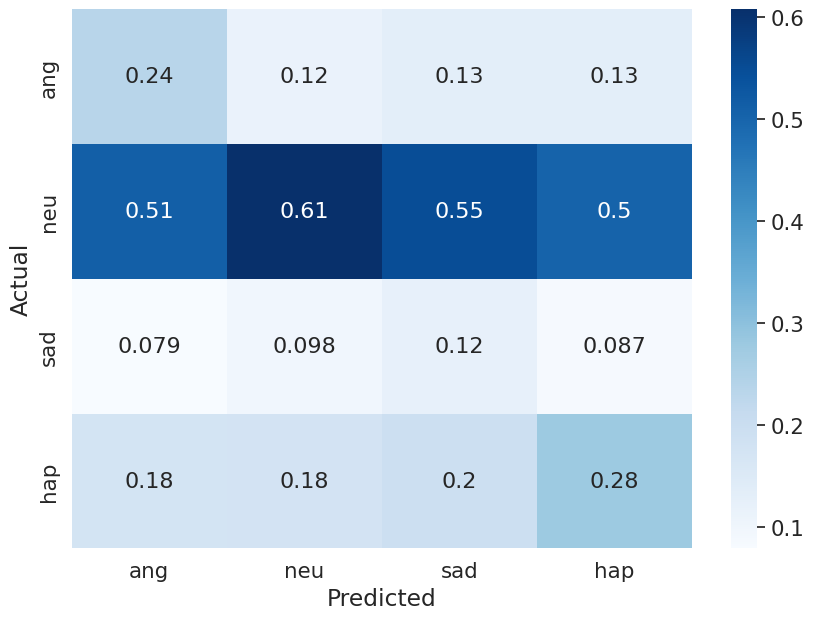

In [44]:
labels = dataset_config.target_labels
a = cm.detach().cpu()
# a /= reduce(a, 'y yh -> y 1', 'sum')
a = a / reduce(a, 'y yh -> 1 yh', 'sum')
df_cm = pd.DataFrame(a, columns=labels, index = labels)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4) #for label size
sns.heatmap(
    df_cm, cmap="Blues", 
    annot=True,
    annot_kws={"size": 16})# font size

<Axes: xlabel='Predicted', ylabel='Actual'>

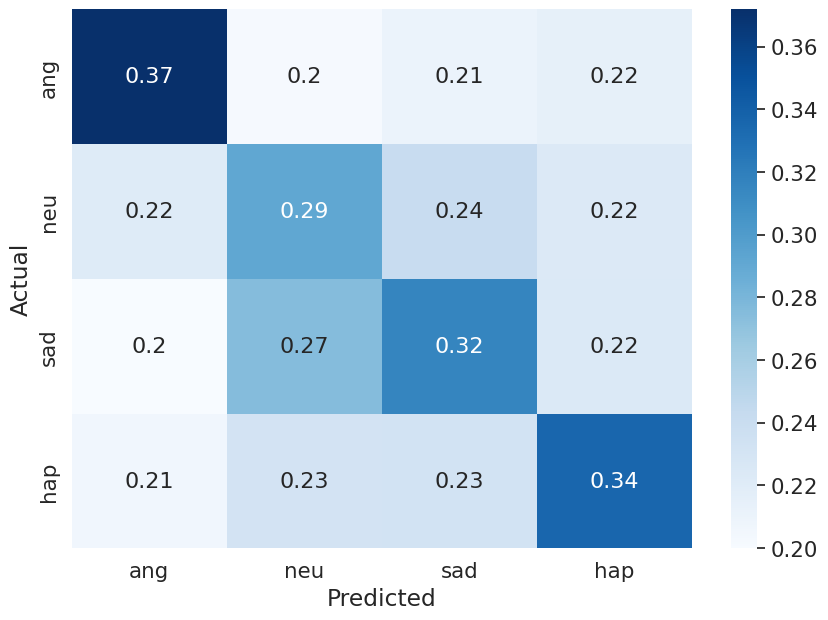

In [45]:
a = cm.detach().cpu()
a = a / reduce(a, 'y yh -> y 1', 'sum')
a /= reduce(a, 'y yh -> 1 yh', 'sum')
df_cm = pd.DataFrame(a, columns=labels, index = labels)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4) #for label size
sns.heatmap(
    df_cm, cmap="Blues", 
    annot=True,
    annot_kws={"size": 16})# font size

In [46]:
dt = []
for i, ld in enumerate(trainer.train_losses_detail):
    d = {'loss': trainer.train_losses[i]}
    for j, k in enumerate(ld._fields):
        d[k] = ld[j]
    dt.append(d)
loss_df = pd.DataFrame(dt)
trained_epoch = trainer.current_epoch
n = len(trainer.train_losses)
trained_steps = n - (n % trained_epoch)
train_losses = reduce(np.array(
    trainer.train_losses[:trained_steps]), '(n k) -> n', 'mean', n=trained_epoch)

Text(0.5, 1.0, 'Test accuracy per 10 epochs')

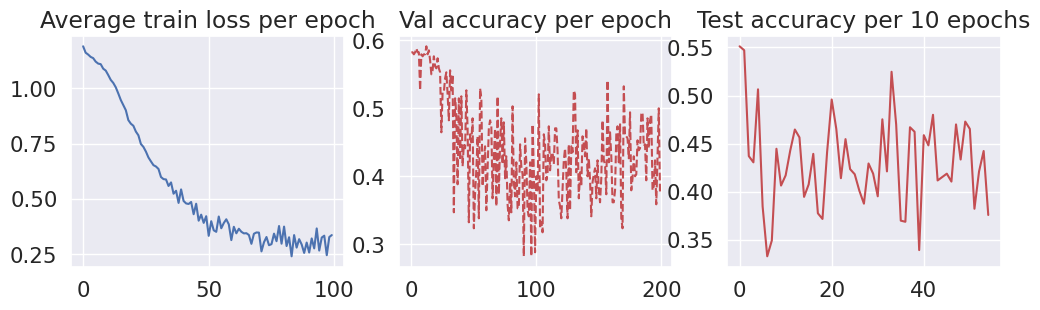

In [47]:
fig, axes = plt.subplots(1, 3, figsize=(12,3))
axes[0].plot(train_losses, color="b")
axes[0].set_title("Average train loss per epoch")
axes[1].plot(trainer.val_accuracy, color="r", linestyle="dashed")
axes[1].set_title("Val accuracy per epoch")
axes[2].plot(trainer.test_accuracy, color="r")
axes[2].set_title("Test accuracy per 10 epochs")

Text(0.5, 1.0, 'Test accuracy per 10 epochs')

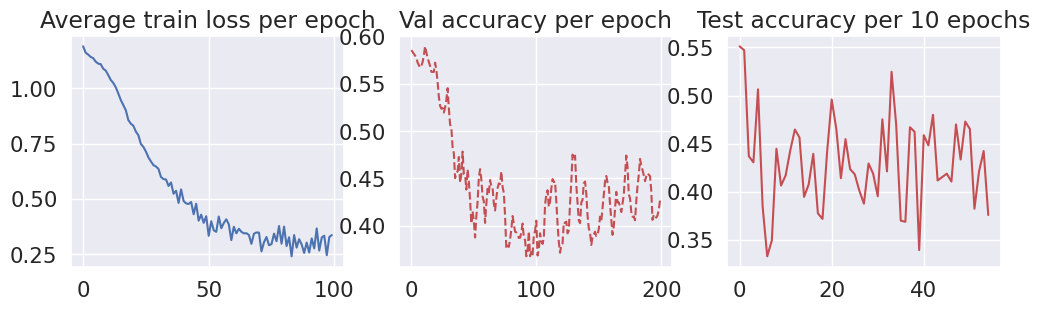

In [48]:
fig, axes = plt.subplots(1, 3, figsize=(12,3))
axes[0].plot(train_losses, color="b")
axes[0].set_title("Average train loss per epoch")
axes[1].plot(savgol_filter(trainer.val_accuracy, 10, 2), color="r", linestyle="dashed")
axes[1].set_title("Val accuracy per epoch")
axes[2].plot(trainer.test_accuracy, color="r")
axes[2].set_title("Test accuracy per 10 epochs")

In [49]:
train_log = {
    'train_loss': torch.tensor(train_losses),
    'val_acc': torch.tensor(trainer.val_accuracy),
    'test_acc': torch.tensor(trainer.test_accuracy),
    'test_confusion_matrix': cm,
    'test_metrics': me,
    'test_metrics_detail': med,
    'best_epoch': 86
}
torch.save(train_log, log_dir+"train_metrics.pt")
loss_df.to_csv(log_dir+"train_losses.csv")